In [ ]:
import numpy as np
import tensorflow as tf
from keras import layers, regularizers
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import pathlib
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
import os
import warnings


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings('ignore')


print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)

data_dir = pathlib.Path("flower_photos")

img_height = 180
img_width = 180
batch_size = 32
num_classes = 5


train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
class_names


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.10.0
Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [2]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

class MacroF1(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.f1_scores = []
        y_true = []
        for _, y in validation_data:
            y_true.extend(y.numpy())
        self._y_true = np.array(y_true)

    def on_epoch_end(self, epoch, logs=None):
        preds = self.model.predict(self.validation_data, verbose=0)
        y_pred = np.argmax(preds, axis=1)
        macro_f1 = f1_score(self._y_true, y_pred, average="macro")
        self.f1_scores.append(macro_f1)
        logs = logs or {}
        logs["val_macro_f1"] = macro_f1
        print(f" — val_macro_f1: {macro_f1:.4f}")



In [3]:
class EpochTimer(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.epoch_times = []
        self.epoch_start_time = None
    
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()
    
    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)
        print(f" — epoch_time: {epoch_time:.2f}s (avg: {np.mean(self.epoch_times):.2f}s)")


In [ ]:
def build_model(
    conv_layers=2,
    dense_layers=1,
    dense_units=128,
    activation="relu",
    learning_rate=0.001,
    regularizer=None,
    reg_value=0.001,
    use_pooling=True,
    use_batchnorm=False,
    use_augmentation=True
):
    if regularizer == "l1":
        reg = regularizers.l1(reg_value)
    elif regularizer == "l2":
        reg = regularizers.l2(reg_value)
    else:
        reg = None
    
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(img_height, img_width, 3)))

    if use_augmentation:
        model.add(data_augmentation)

    model.add(layers.Rescaling(1. / 255))


    for i in range(conv_layers):
        filters = 32 * (2**i)

        model.add(layers.Conv2D(filters, 3, padding="same", kernel_regularizer=reg))
        if use_batchnorm:
            model.add(layers.BatchNormalization())
        model.add(layers.Activation(activation))

        model.add(layers.Conv2D(filters, 3, padding="same", kernel_regularizer=reg))
        if use_batchnorm:
            model.add(layers.BatchNormalization())
        model.add(layers.Activation(activation))

        if use_pooling:
            model.add(layers.MaxPooling2D())

    model.add(layers.GlobalAveragePooling2D())

    for _ in range(dense_layers):
        model.add(layers.Dense(dense_units, activation=activation, kernel_regularizer=reg))


    model.add(layers.Dense(num_classes))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

    return model


In [ ]:
def plot_training_history(history, f1_callback):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    axes[0].plot(history.history['loss'], label='Train Loss')
    axes[0].plot(history.history['val_loss'], label='Val Loss')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    axes[1].plot(history.history['accuracy'], label='Train Accuracy')
    axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    axes[2].plot(f1_callback.f1_scores, label='Val Macro F1', color='green')
    axes[2].set_title('Macro F1 Score')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Macro F1')
    axes[2].legend()
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()
    plt.close()


In [6]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    plt.close()


In [7]:
def evaluate_model(model, val_ds):
    y_true = []
    y_pred = []
    
    for x, y in val_ds:
        logits = model.predict(x, verbose=0)
        preds = tf.argmax(logits, axis=1).numpy()
        y_pred.extend(preds)
        y_true.extend(y.numpy())
    
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    
    return y_true, y_pred, macro_f1

def print_model_weights_info(model):
    print("MODEL ARCHITECTURE & WEIGHTS INFO")
    
    for i, layer in enumerate(model.layers):
        weights = layer.get_weights()
        if len(weights) > 0:
            print(f"\nLayer {i}: {layer.name} ({layer.__class__.__name__})")
            for j, w in enumerate(weights):
                weight_type = "Kernel" if j == 0 else "Bias" if j == 1 else f"Param_{j}"
                print(f"  {weight_type}: shape={w.shape}, "
                      f"mean={w.mean():.6f}, std={w.std():.6f}, "
                      f"min={w.min():.6f}, max={w.max():.6f}")


In [ ]:
grid_search_configs = [
    #Baseline
    {"conv_layers": 2, "dense_layers": 1, "dense_units": 128, "activation": "relu",
     "learning_rate": 0.001, "use_pooling": True, "use_batchnorm": True, 
     "regularizer": None, "reg_value": 0},
    #Learning rate
    {"conv_layers": 2, "dense_layers": 1, "dense_units": 128, "activation": "relu",
     "learning_rate": 0.0005, "use_pooling": True, "use_batchnorm": True, 
     "regularizer": None, "reg_value": 0},
    
    {"conv_layers": 2, "dense_layers": 1, "dense_units": 128, "activation": "relu",
     "learning_rate": 0.0003, "use_pooling": True, "use_batchnorm": True, 
     "regularizer": None, "reg_value": 0},
    
    {"conv_layers": 2, "dense_layers": 1, "dense_units": 128, "activation": "relu",
     "learning_rate": 0.0001, "use_pooling": True, "use_batchnorm": True, 
     "regularizer": None, "reg_value": 0},
    #Conv_layers
    {"conv_layers": 3, "dense_layers": 1, "dense_units": 128, "activation": "relu",
     "learning_rate": 0.001, "use_pooling": True, "use_batchnorm": True, 
     "regularizer": None, "reg_value": 0},

    {"conv_layers": 4, "dense_layers": 1, "dense_units": 128, "activation": "relu",
     "learning_rate": 0.001, "use_pooling": True, "use_batchnorm": True, 
     "regularizer": None, "reg_value": 0},
    #Hidden layers
    {"conv_layers": 2, "dense_layers": 2, "dense_units": 128, "activation": "relu",
     "learning_rate": 0.001, "use_pooling": True, "use_batchnorm": True, 
     "regularizer": None, "reg_value": 0},

    #No pooling
    {"conv_layers": 2, "dense_layers": 1, "dense_units": 128, "activation": "relu",
     "learning_rate": 0.001, "use_pooling": False, "use_batchnorm": True, 
     "regularizer": None, "reg_value": 0},

    #No norm
    {"conv_layers": 2, "dense_layers": 1, "dense_units": 128, "activation": "relu",
     "learning_rate": 0.001, "use_pooling": True, "use_batchnorm": False, 
     "regularizer": None, "reg_value": 0},

    #L1
    {"conv_layers": 2, "dense_layers": 1, "dense_units": 128, "activation": "relu",
     "learning_rate": 0.001, "use_pooling": True, "use_batchnorm": True, 
     "regularizer": 'l1', "reg_value": 0.001},

    {"conv_layers": 2, "dense_layers": 1, "dense_units": 128, "activation": "relu",
     "learning_rate": 0.001, "use_pooling": True, "use_batchnorm": True, 
     "regularizer": 'l1', "reg_value": 0.00001},

     {"conv_layers": 2, "dense_layers": 1, "dense_units": 128, "activation": "relu",
     "learning_rate": 0.001, "use_pooling": True, "use_batchnorm": True, 
     "regularizer": 'l1', "reg_value": 0.0005},

    #L2
    {"conv_layers": 2, "dense_layers": 1, "dense_units": 128, "activation": "relu",
     "learning_rate": 0.001, "use_pooling": True, "use_batchnorm": True, 
     "regularizer": 'l2', "reg_value": 0.001},

    {"conv_layers": 2, "dense_layers": 1, "dense_units": 128, "activation": "relu",
     "learning_rate": 0.001, "use_pooling": True, "use_batchnorm": True, 
     "regularizer": 'l2', "reg_value": 0.00001},

     {"conv_layers": 2, "dense_layers": 1, "dense_units": 128, "activation": "relu",
     "learning_rate": 0.001, "use_pooling": True, "use_batchnorm": True, 
     "regularizer": 'l2', "reg_value": 0.0005},

    #Neuronen
     {"conv_layers": 2, "dense_layers": 1, "dense_units": 64, "activation": "relu",
     "learning_rate": 0.001, "use_pooling": True, "use_batchnorm": True, 
     "regularizer": None, "reg_value": 0},

     {"conv_layers": 2, "dense_layers": 1, "dense_units": 256, "activation": "relu",
     "learning_rate": 0.001, "use_pooling": True, "use_batchnorm": True, 
     "regularizer": None, "reg_value": 0},

     #Activation functions

     {"conv_layers": 2, "dense_layers": 1, "dense_units": 128, "activation": "sigmoid",
     "learning_rate": 0.001, "use_pooling": True, "use_batchnorm": True, 
     "regularizer": None, "reg_value": 0},

     {"conv_layers": 2, "dense_layers": 1, "dense_units": 128, "activation": "tanh",
     "learning_rate": 0.001, "use_pooling": True, "use_batchnorm": True, 
     "regularizer": None, "reg_value": 0},

]

results = []
best_f1 = 0
best_model = None
best_config = None
best_history = None
best_f1_callback = None



EXPERIMENT 1/19
Config: {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}
Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 1.2225 - accuracy: 0.5003 — val_macro_f1: 0.1436
 — epoch_time: 39.41s (avg: 39.41s)
92/92 [==============================] - 39s 328ms/step - loss: 1.2225 - accuracy: 0.5003 - val_loss: 1.5997 - val_accuracy: 0.2711 - val_macro_f1: 0.1436
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 1.0248 - accuracy: 0.5978 — val_macro_f1: 0.0808
 — epoch_time: 28.17s (avg: 33.79s)
92/92 [==============================] - 28s 306ms/step - loss: 1.0248 - accuracy: 0.5978 - val_loss: 1.6360 - val_accuracy: 0.2411 - val_macro_f1: 0.0808
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 0.9531 - accuracy: 0.6301 — val_macro_f1: 0.2897
 — epoch_time: 28.19s (avg: 31.92s)
92/92 [=============

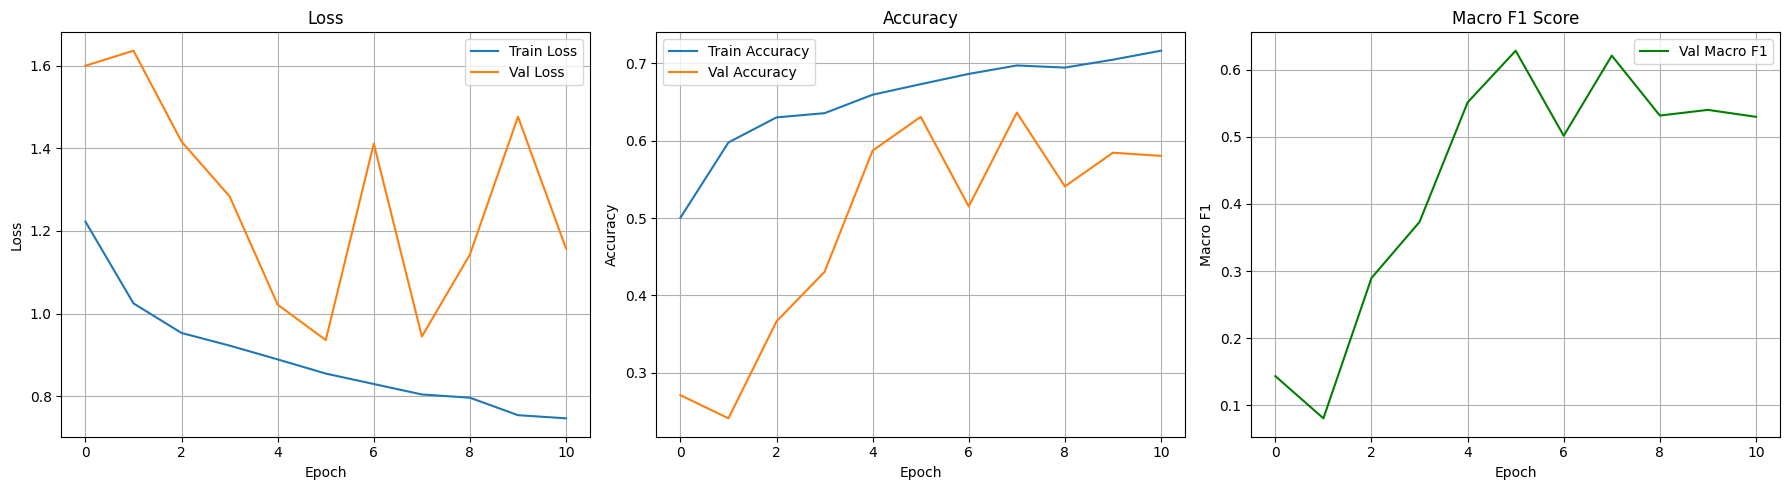

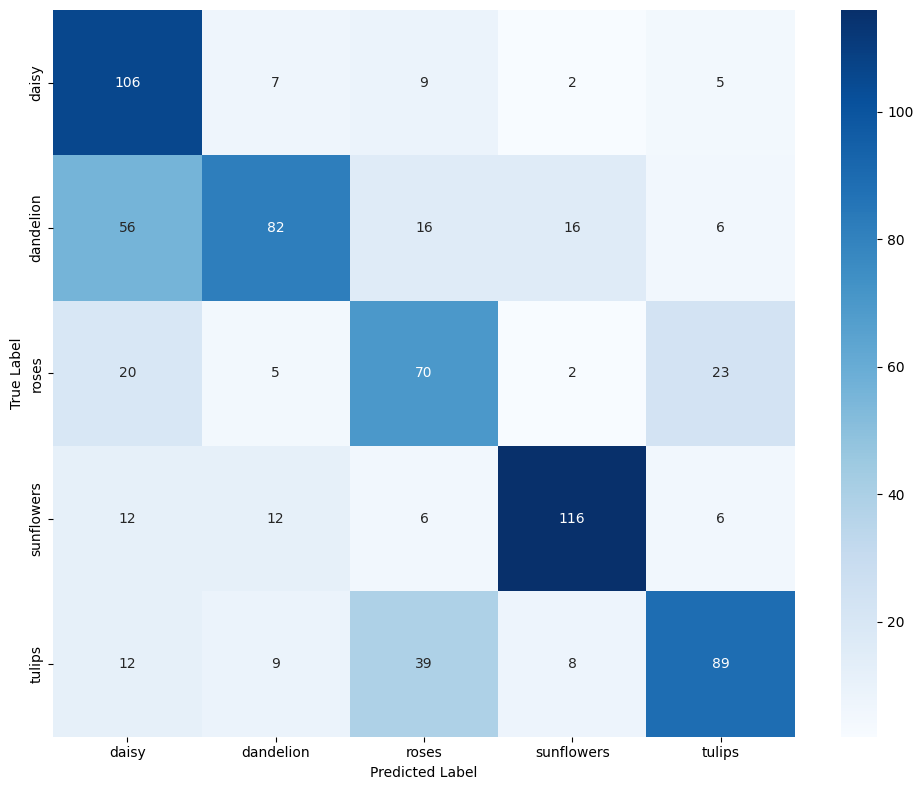


Results: Macro F1 = 0.6282, Time = 323.34s


EXPERIMENT 2/19
Config: {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.0005, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}
Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 1.1964 - accuracy: 0.5252 — val_macro_f1: 0.0906
 — epoch_time: 32.07s (avg: 32.07s)
92/92 [==============================] - 32s 312ms/step - loss: 1.1964 - accuracy: 0.5252 - val_loss: 1.6265 - val_accuracy: 0.2452 - val_macro_f1: 0.0906
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 1.0109 - accuracy: 0.6073 — val_macro_f1: 0.0774
 — epoch_time: 28.55s (avg: 30.31s)
92/92 [==============================] - 29s 310ms/step - loss: 1.0109 - accuracy: 0.6073 - val_loss: 1.6569 - val_accuracy: 0.2398 - val_macro_f1: 0.0774
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 0.9449 - accuracy: 0.6284 — val_macro_f1: 0.1290
 — epoch_ti

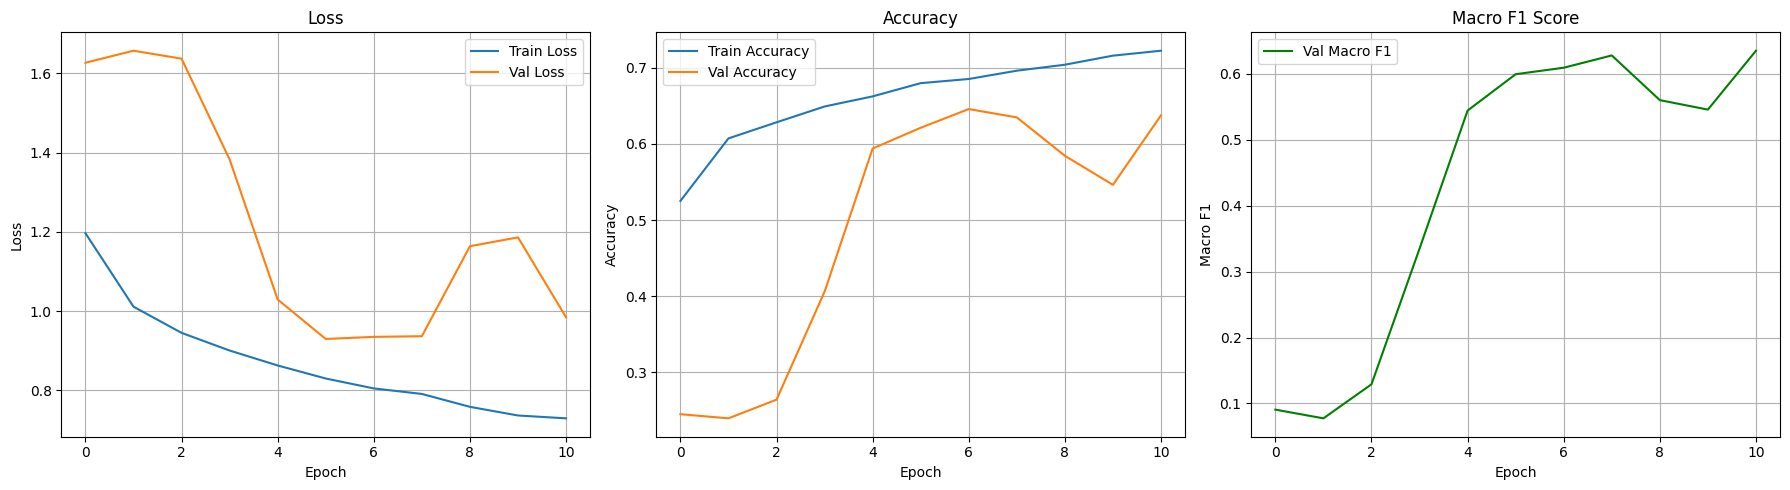

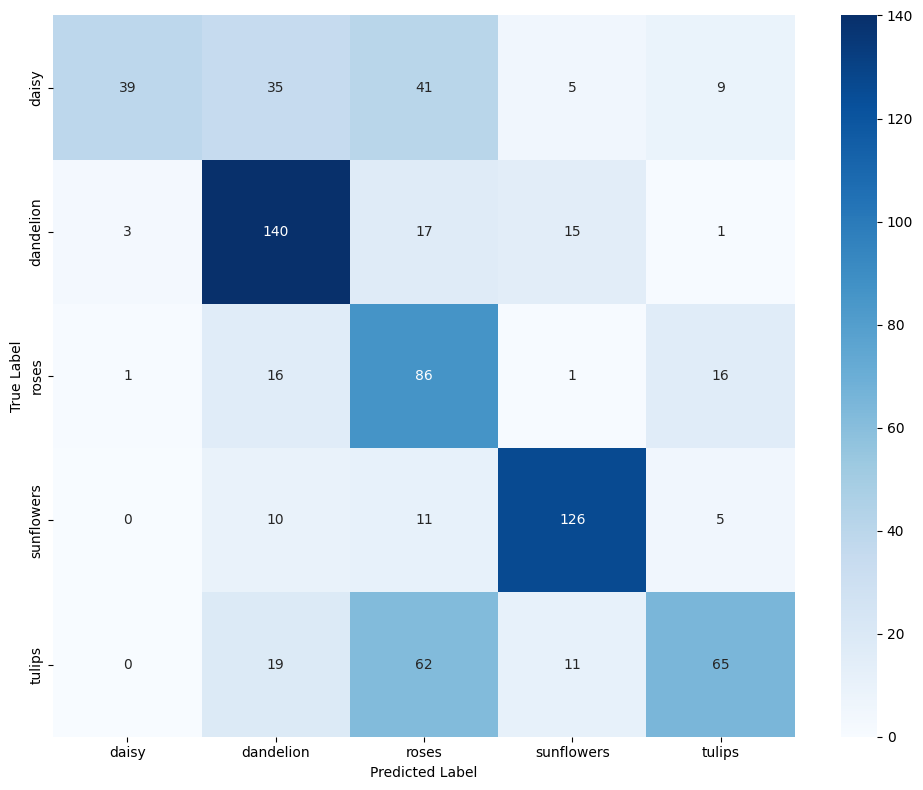



EXPERIMENT 3/19
Config: {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.0003, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}
Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 1.2108 - accuracy: 0.5136 — val_macro_f1: 0.0774
 — epoch_time: 31.97s (avg: 31.97s)
92/92 [==============================] - 32s 312ms/step - loss: 1.2108 - accuracy: 0.5136 - val_loss: 1.6469 - val_accuracy: 0.2398 - val_macro_f1: 0.0774
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 1.0195 - accuracy: 0.6039 — val_macro_f1: 0.0863
 — epoch_time: 28.29s (avg: 30.13s)
92/92 [==============================] - 28s 308ms/step - loss: 1.0195 - accuracy: 0.6039 - val_loss: 1.7317 - val_accuracy: 0.2425 - val_macro_f1: 0.0863
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 0.9463 - accuracy: 0.6451 — val_macro_f1: 0.1292
 — epoch_time: 28.29s (avg: 29.52s)
92/92 [============

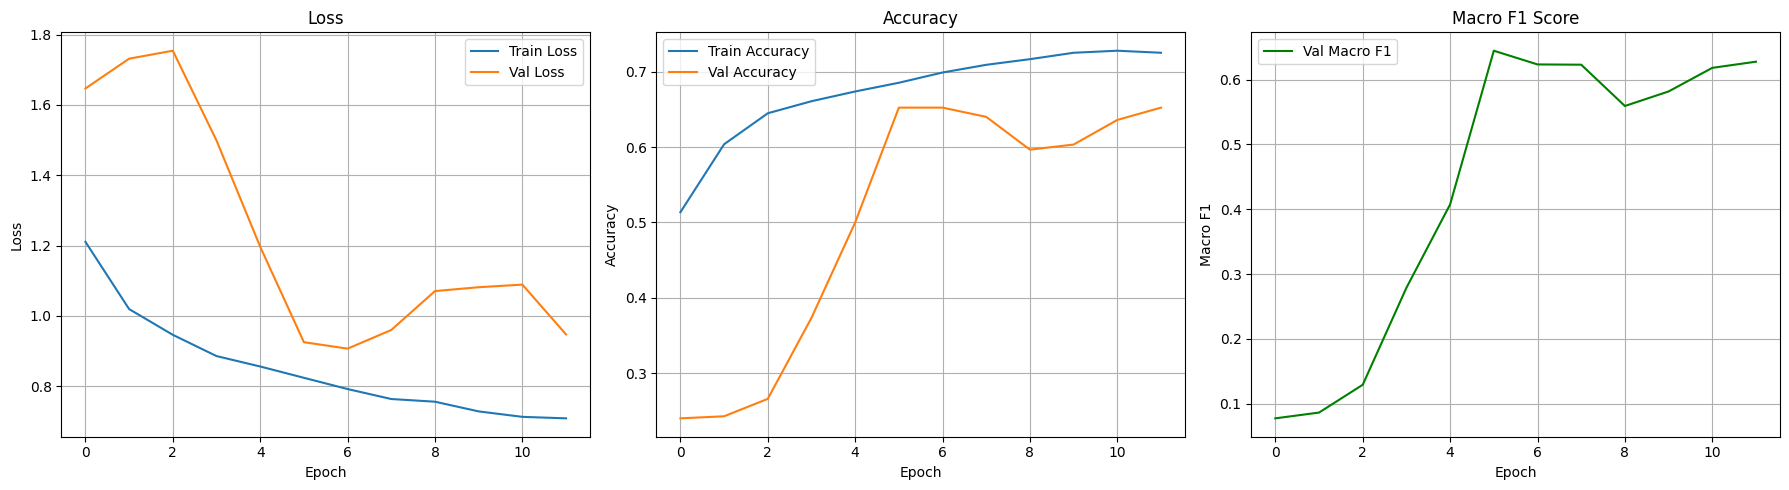

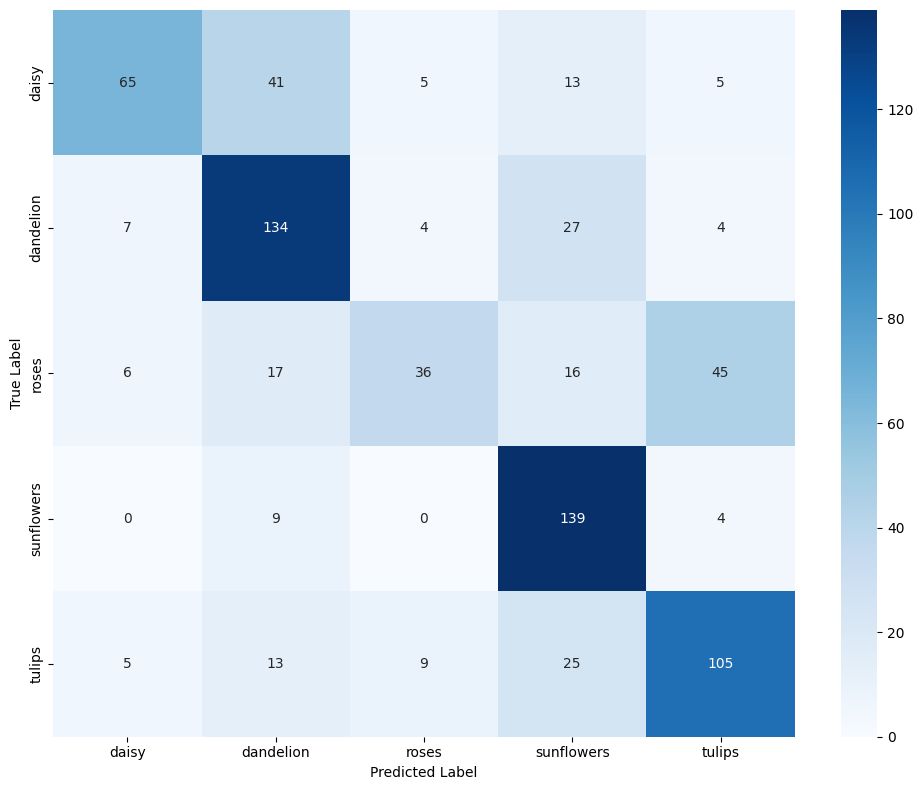



EXPERIMENT 4/19
Config: {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.0001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}
Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 1.2749 - accuracy: 0.4785 — val_macro_f1: 0.0774
 — epoch_time: 32.14s (avg: 32.14s)
92/92 [==============================] - 32s 313ms/step - loss: 1.2749 - accuracy: 0.4785 - val_loss: 1.6348 - val_accuracy: 0.2398 - val_macro_f1: 0.0774
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 1.0918 - accuracy: 0.5760 — val_macro_f1: 0.0774
 — epoch_time: 28.39s (avg: 30.27s)
92/92 [==============================] - 28s 309ms/step - loss: 1.0918 - accuracy: 0.5760 - val_loss: 1.7277 - val_accuracy: 0.2398 - val_macro_f1: 0.0774
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 1.0160 - accuracy: 0.6018 — val_macro_f1: 0.0860
 — epoch_time: 28.61s (avg: 29.71s)
92/92 [============

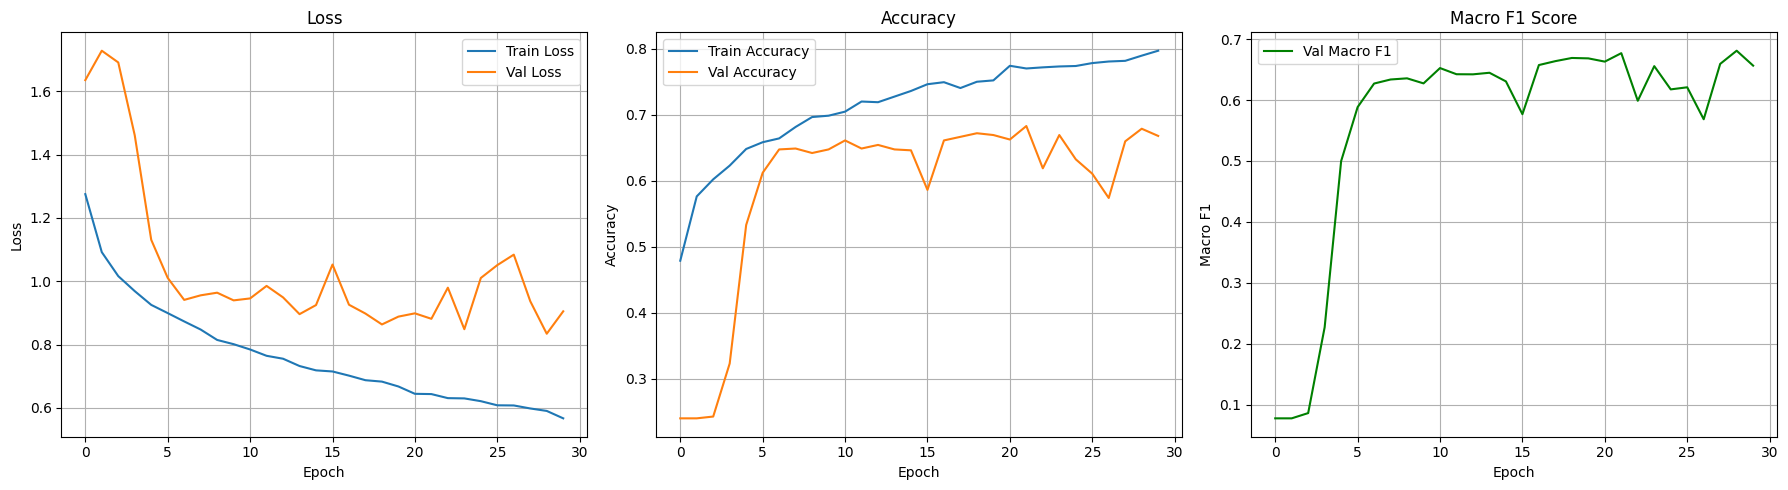

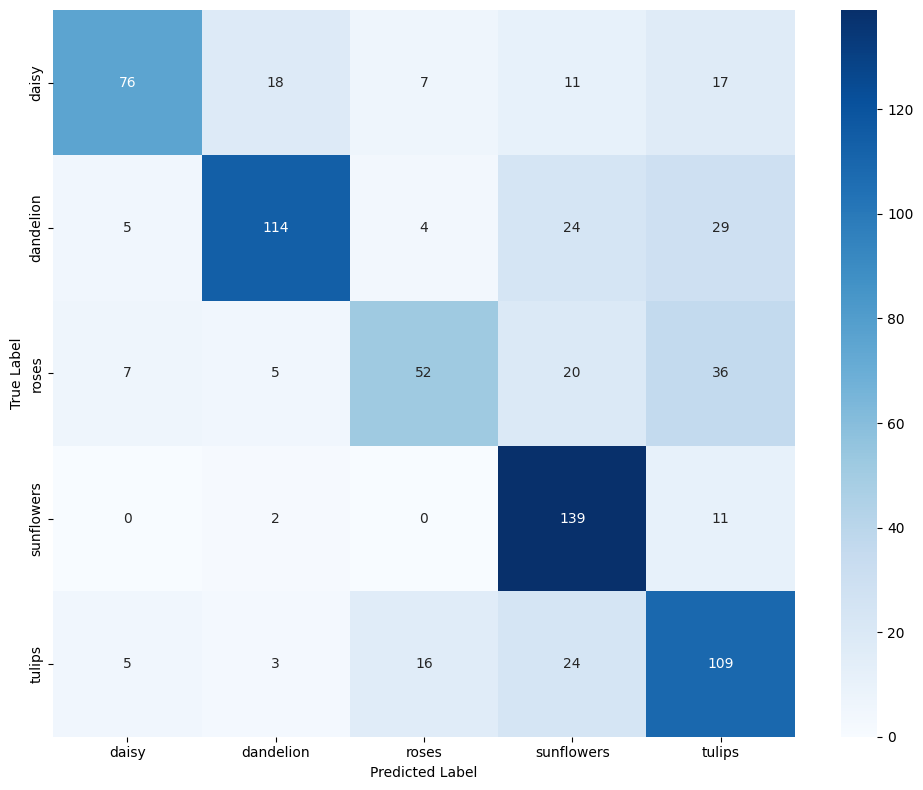


Results: Macro F1 = 0.6566, Time = 858.25s


EXPERIMENT 5/19
Config: {'conv_layers': 3, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}
Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 1.2014 - accuracy: 0.5276 — val_macro_f1: 0.0774
 — epoch_time: 35.45s (avg: 35.45s)
92/92 [==============================] - 35s 340ms/step - loss: 1.2014 - accuracy: 0.5276 - val_loss: 1.7334 - val_accuracy: 0.2398 - val_macro_f1: 0.0774
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 1.0130 - accuracy: 0.6114 — val_macro_f1: 0.0774
 — epoch_time: 30.59s (avg: 33.02s)
92/92 [==============================] - 31s 333ms/step - loss: 1.0130 - accuracy: 0.6114 - val_loss: 1.7586 - val_accuracy: 0.2398 - val_macro_f1: 0.0774
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 0.9412 - accuracy: 0.6376 — val_macro_f1: 0.0800
 — epoch_tim

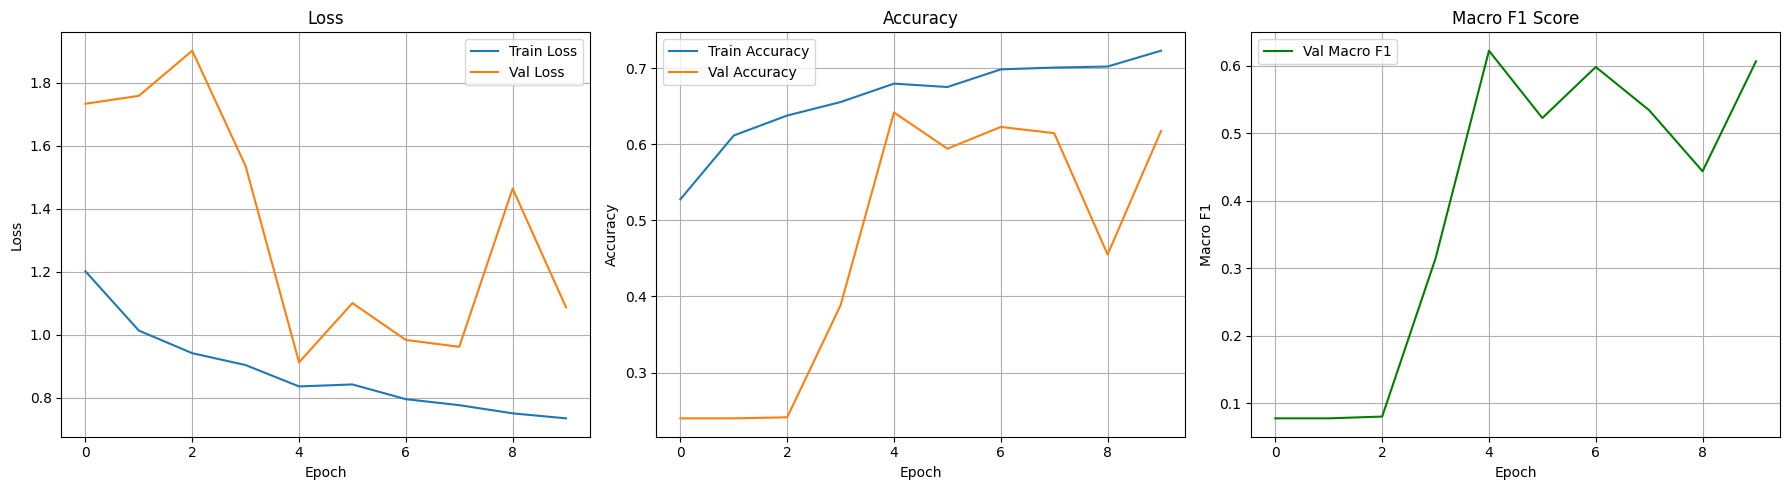

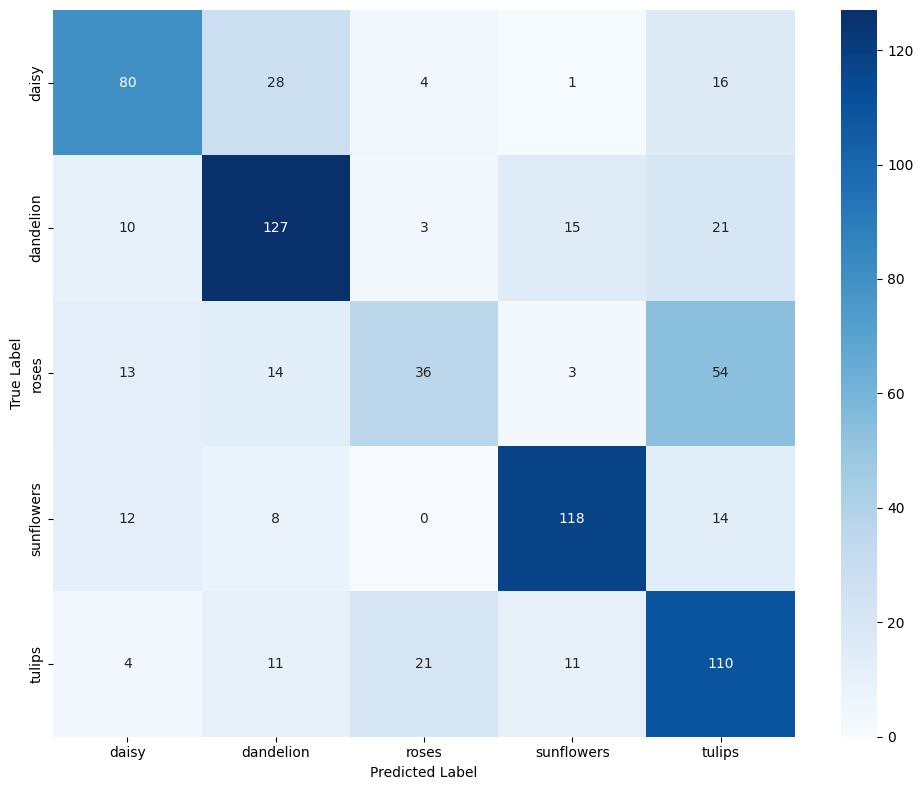



EXPERIMENT 6/19
Config: {'conv_layers': 4, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}
Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 1.1976 - accuracy: 0.5324 — val_macro_f1: 0.0774
 — epoch_time: 36.85s (avg: 36.85s)
92/92 [==============================] - 37s 356ms/step - loss: 1.1976 - accuracy: 0.5324 - val_loss: 1.6841 - val_accuracy: 0.2398 - val_macro_f1: 0.0774
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 1.0027 - accuracy: 0.6059 — val_macro_f1: 0.0774
 — epoch_time: 31.94s (avg: 34.39s)
92/92 [==============================] - 32s 347ms/step - loss: 1.0027 - accuracy: 0.6059 - val_loss: 1.9935 - val_accuracy: 0.2398 - val_macro_f1: 0.0774
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 0.9281 - accuracy: 0.6407 — val_macro_f1: 0.3339
 — epoch_time: 32.07s (avg: 33.62s)
92/92 [=============

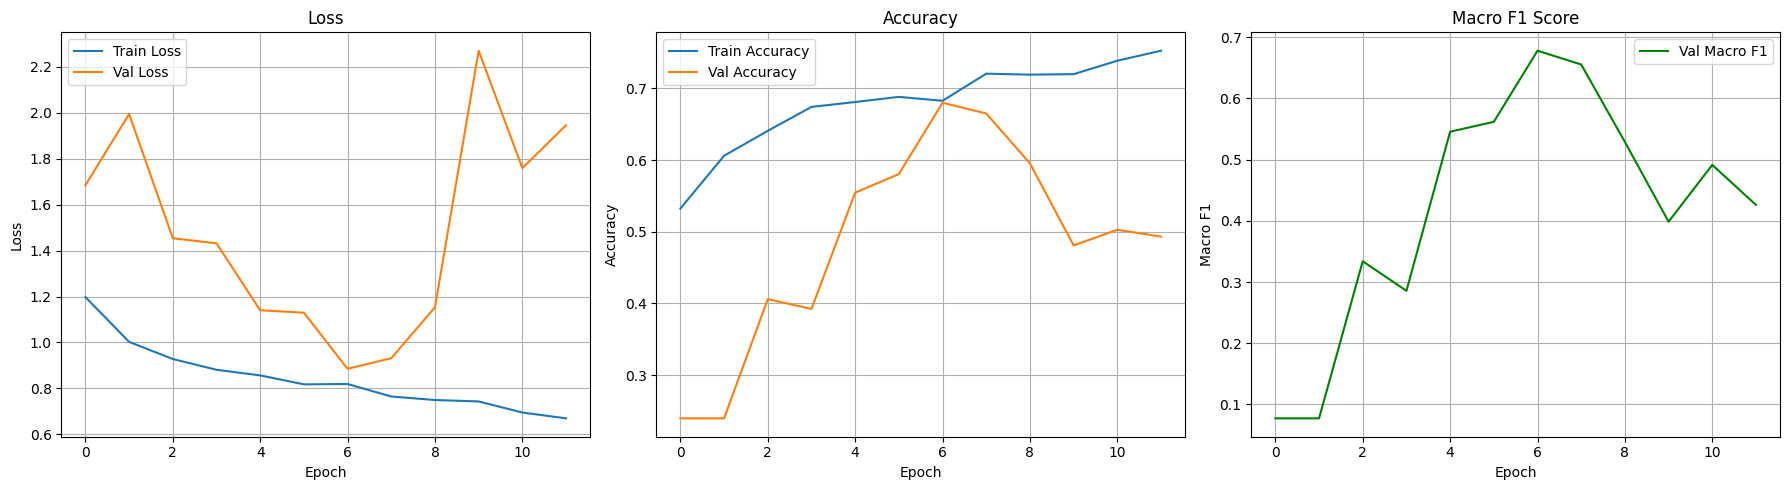

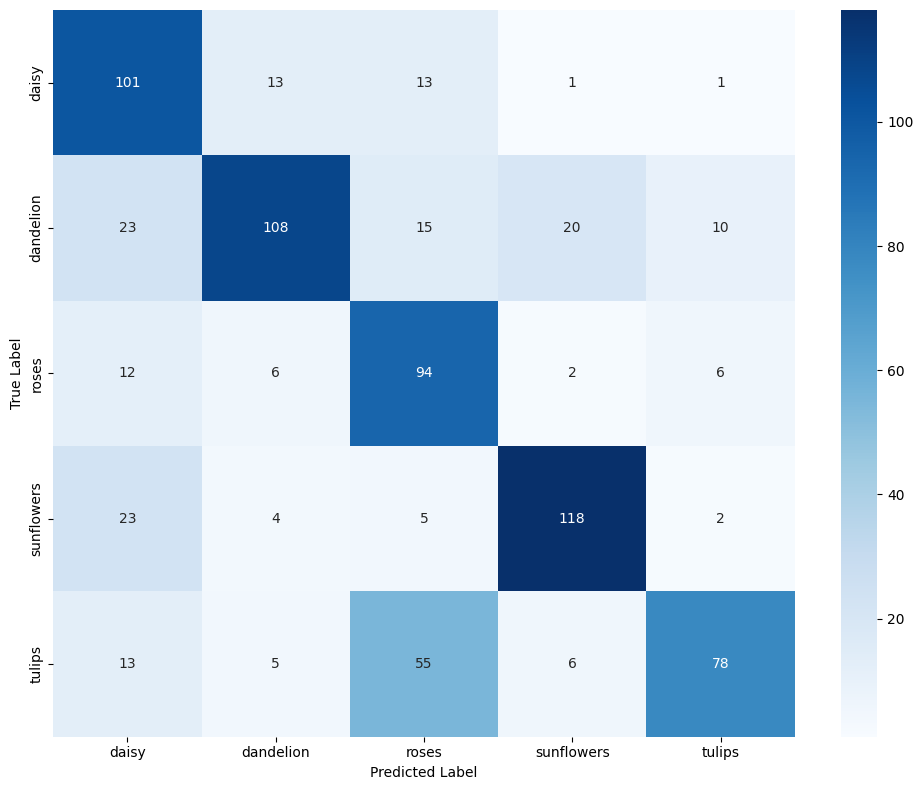


Results: Macro F1 = 0.6779, Time = 387.96s


EXPERIMENT 7/19
Config: {'conv_layers': 2, 'dense_layers': 2, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}
Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 1.2817 - accuracy: 0.4928 — val_macro_f1: 0.0774
 — epoch_time: 32.32s (avg: 32.32s)
92/92 [==============================] - 32s 314ms/step - loss: 1.2817 - accuracy: 0.4928 - val_loss: 1.6041 - val_accuracy: 0.2398 - val_macro_f1: 0.0774
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 1.0523 - accuracy: 0.5858 — val_macro_f1: 0.0774
 — epoch_time: 28.64s (avg: 30.48s)
92/92 [==============================] - 29s 311ms/step - loss: 1.0523 - accuracy: 0.5858 - val_loss: 1.6727 - val_accuracy: 0.2398 - val_macro_f1: 0.0774
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 0.9943 - accuracy: 0.6015 — val_macro_f1: 0.0993
 — epoch_tim

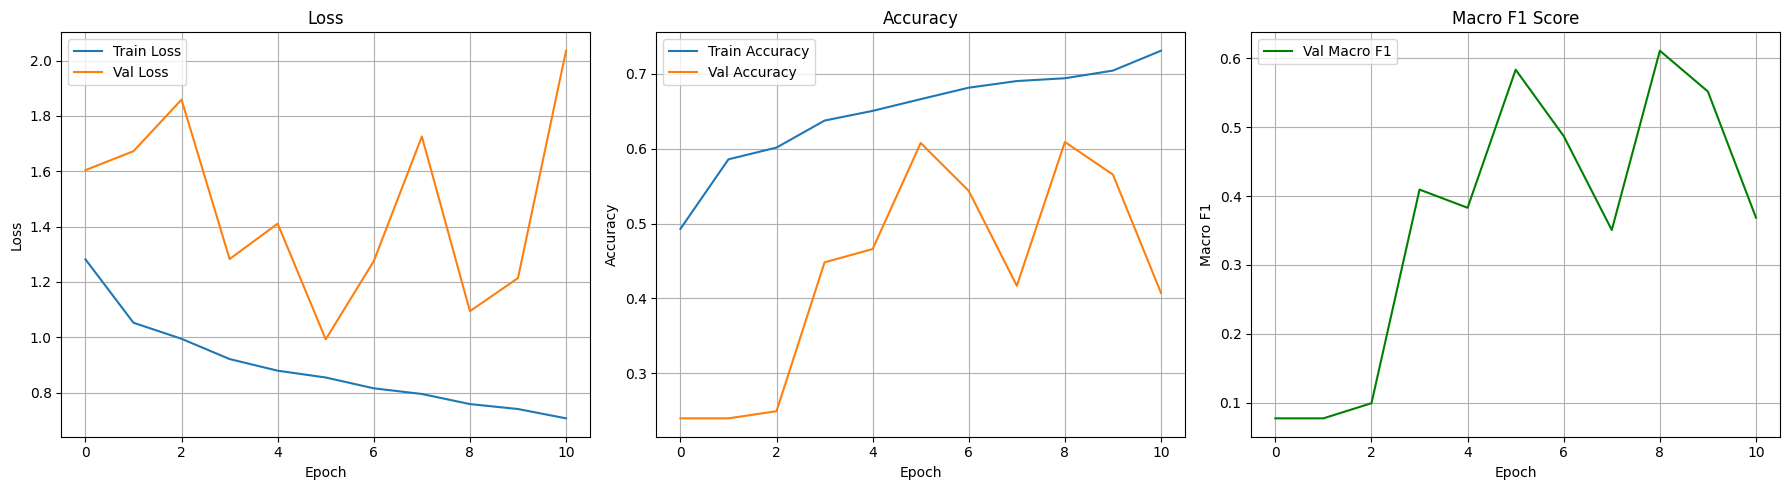

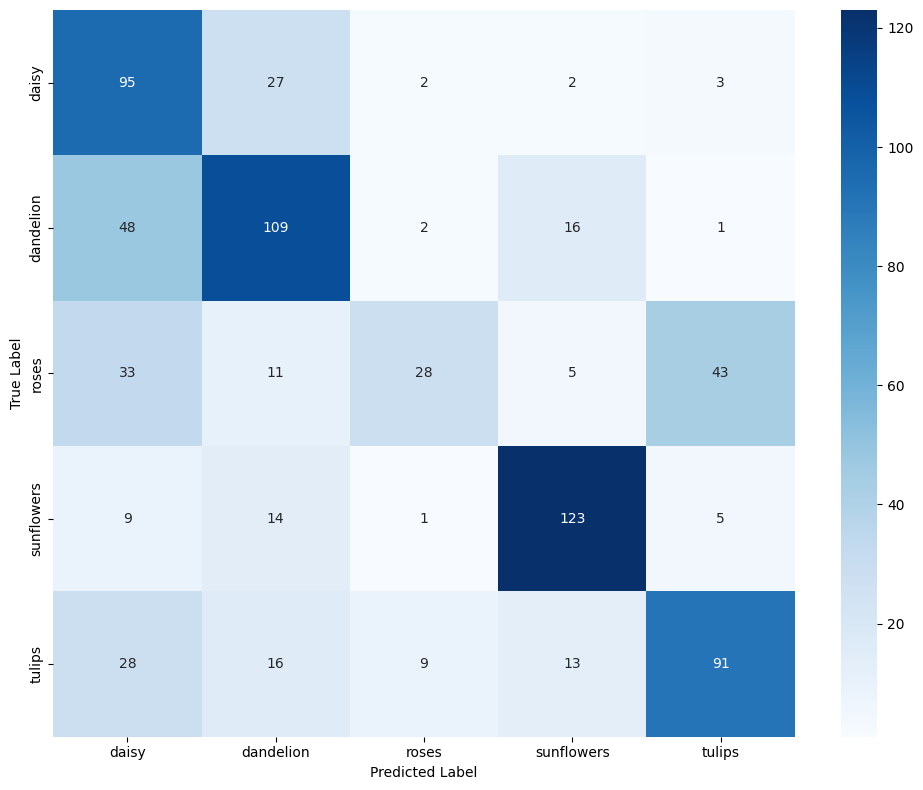



EXPERIMENT 8/19
Config: {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': False, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}
Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 1.2298 - accuracy: 0.4830 — val_macro_f1: 0.0775
 — epoch_time: 45.71s (avg: 45.71s)
92/92 [==============================] - 46s 443ms/step - loss: 1.2298 - accuracy: 0.4830 - val_loss: 1.5982 - val_accuracy: 0.2398 - val_macro_f1: 0.0775
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 1.0639 - accuracy: 0.5777 — val_macro_f1: 0.0874
 — epoch_time: 38.18s (avg: 41.95s)
92/92 [==============================] - 38s 415ms/step - loss: 1.0639 - accuracy: 0.5777 - val_loss: 1.6511 - val_accuracy: 0.2439 - val_macro_f1: 0.0874
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 1.0026 - accuracy: 0.6076 — val_macro_f1: 0.2012
 — epoch_time: 38.25s (avg: 40.71s)
92/92 [============

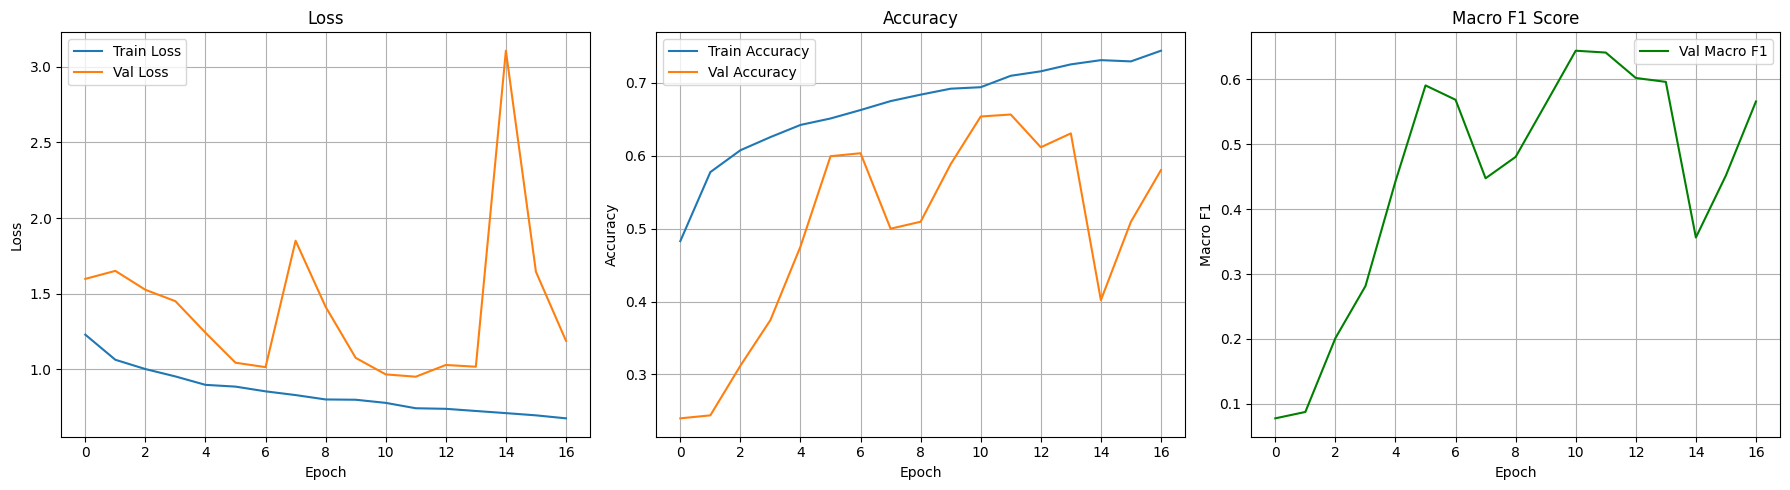

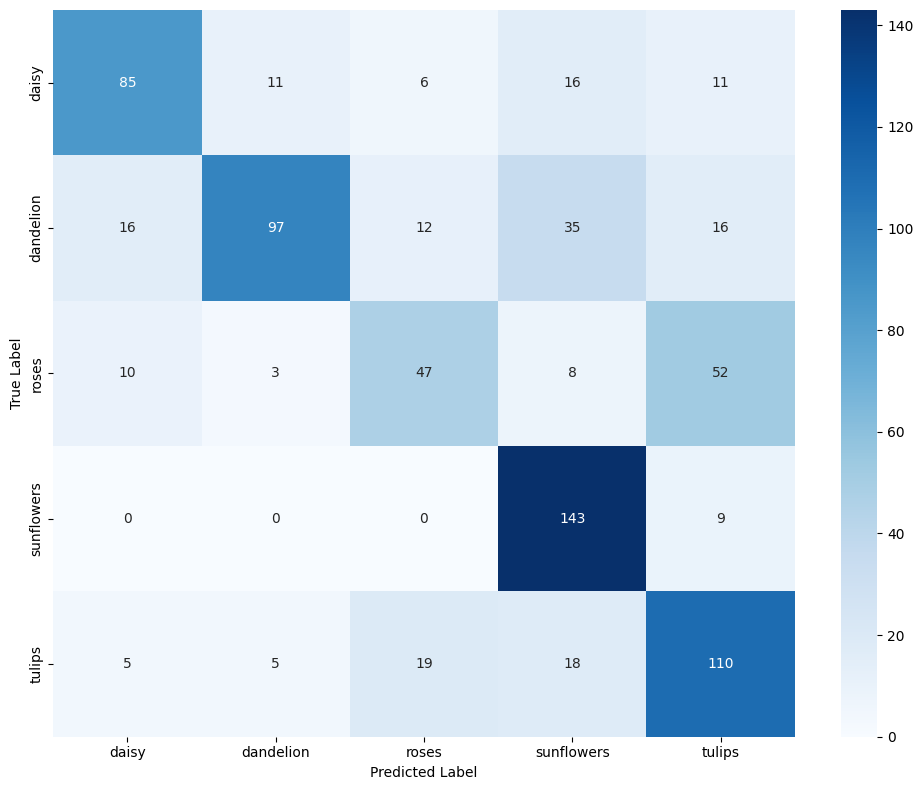



EXPERIMENT 9/19
Config: {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': False, 'regularizer': None, 'reg_value': 0}
Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 1.4348 - accuracy: 0.3535 — val_macro_f1: 0.3962
 — epoch_time: 31.47s (avg: 31.47s)
92/92 [==============================] - 31s 301ms/step - loss: 1.4348 - accuracy: 0.3535 - val_loss: 1.2475 - val_accuracy: 0.4755 - val_macro_f1: 0.3962
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 1.2213 - accuracy: 0.4728 — val_macro_f1: 0.4852
 — epoch_time: 26.18s (avg: 28.82s)
92/92 [==============================] - 26s 285ms/step - loss: 1.2213 - accuracy: 0.4728 - val_loss: 1.2202 - val_accuracy: 0.5150 - val_macro_f1: 0.4852
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 1.1611 - accuracy: 0.5112 — val_macro_f1: 0.5016
 — epoch_time: 26.21s (avg: 27.95s)
92/92 [============

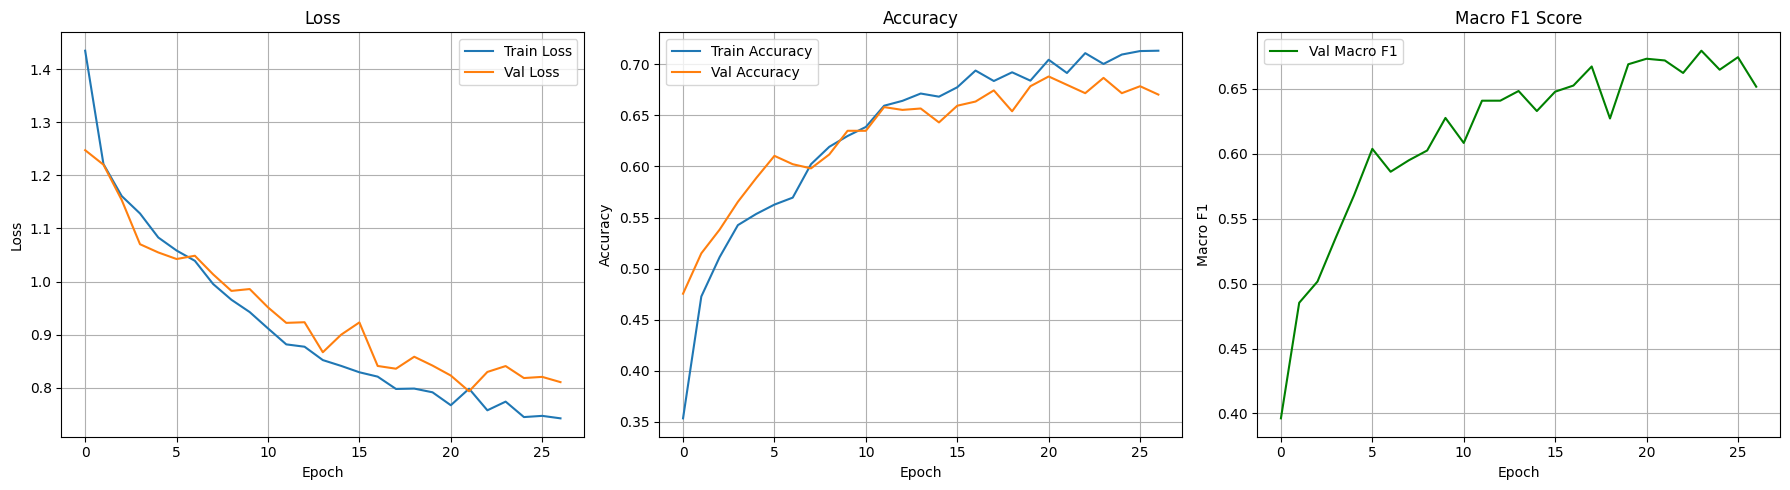

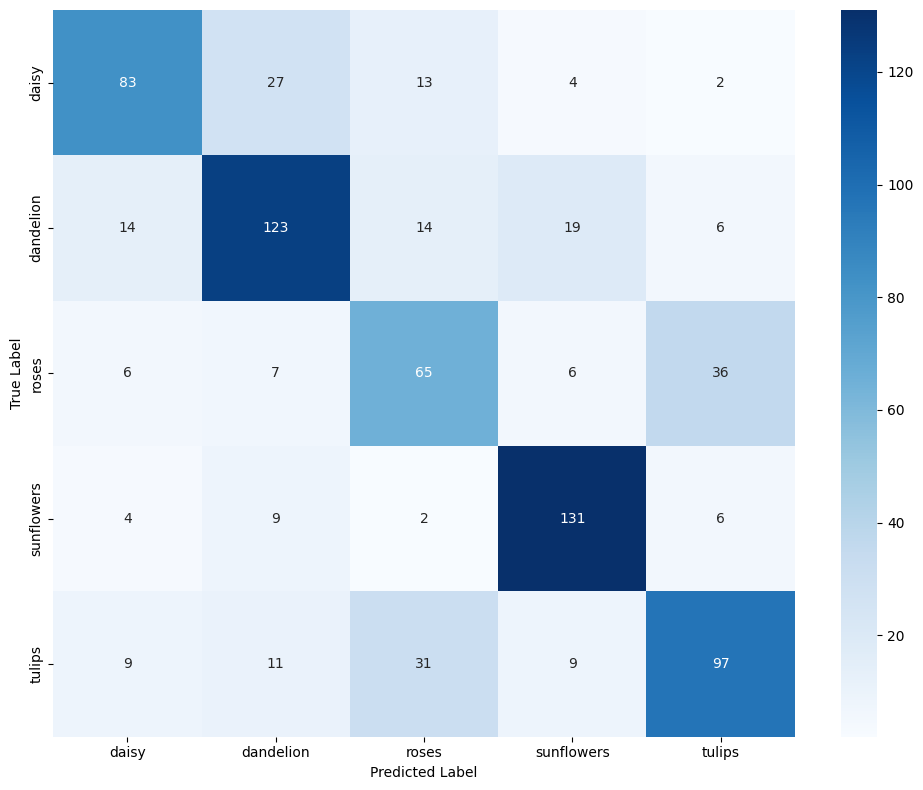



EXPERIMENT 10/19
Config: {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': 'l1', 'reg_value': 0.001}
Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 4.3669 - accuracy: 0.5399 — val_macro_f1: 0.0774
 — epoch_time: 32.88s (avg: 32.88s)
92/92 [==============================] - 33s 318ms/step - loss: 4.3669 - accuracy: 0.5399 - val_loss: 4.5730 - val_accuracy: 0.2398 - val_macro_f1: 0.0774
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 3.7780 - accuracy: 0.5777 — val_macro_f1: 0.0774
 — epoch_time: 28.61s (avg: 30.74s)
92/92 [==============================] - 29s 311ms/step - loss: 3.7780 - accuracy: 0.5777 - val_loss: 4.1287 - val_accuracy: 0.2398 - val_macro_f1: 0.0774
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 3.2600 - accuracy: 0.6178 — val_macro_f1: 0.0981
 — epoch_time: 28.64s (avg: 30.04s)
92/92 [========

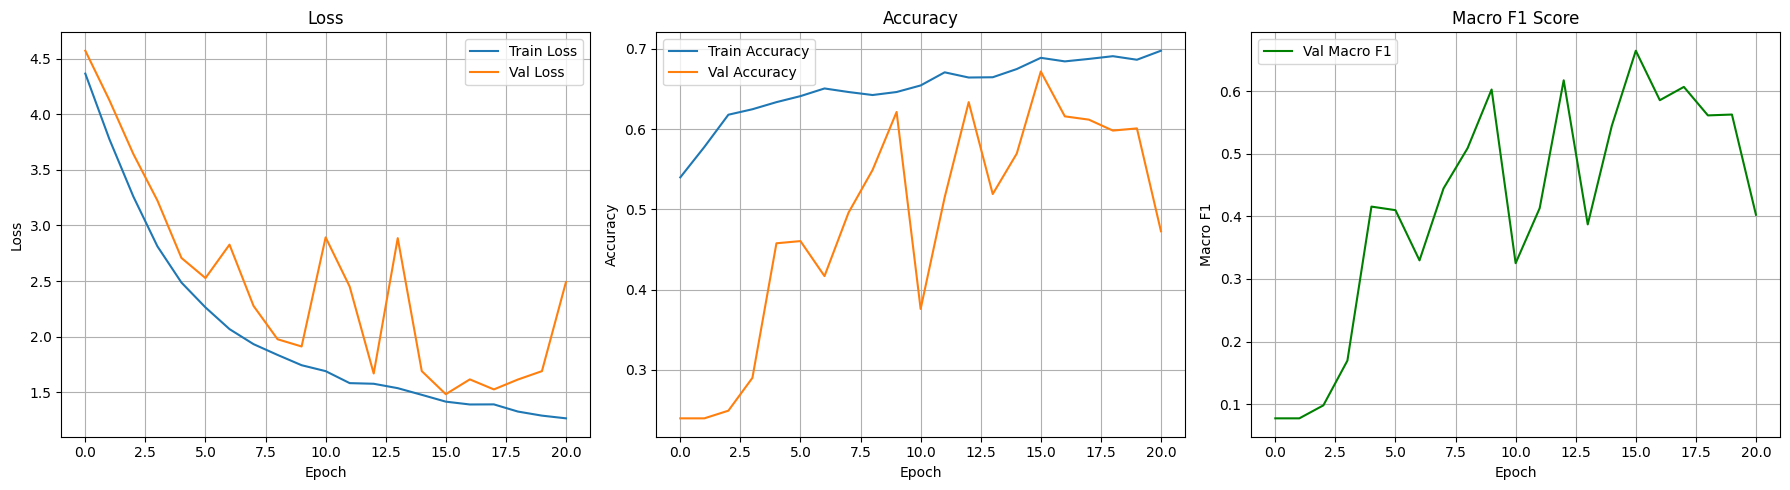

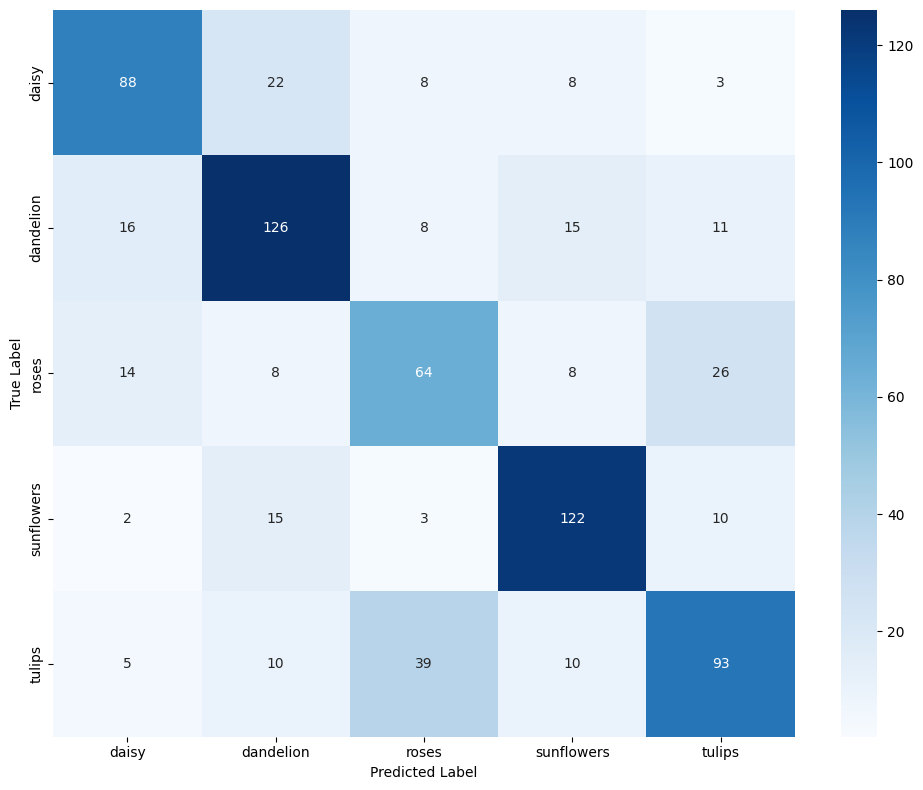



EXPERIMENT 11/19
Config: {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': 'l1', 'reg_value': 1e-05}
Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 1.2527 - accuracy: 0.5157 — val_macro_f1: 0.0774
 — epoch_time: 32.38s (avg: 32.38s)
92/92 [==============================] - 32s 315ms/step - loss: 1.2527 - accuracy: 0.5157 - val_loss: 1.6402 - val_accuracy: 0.2398 - val_macro_f1: 0.0774
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 1.0552 - accuracy: 0.6042 — val_macro_f1: 0.0774
 — epoch_time: 28.56s (avg: 30.47s)
92/92 [==============================] - 29s 311ms/step - loss: 1.0552 - accuracy: 0.6042 - val_loss: 1.6744 - val_accuracy: 0.2398 - val_macro_f1: 0.0774
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 0.9893 - accuracy: 0.6223 — val_macro_f1: 0.1568
 — epoch_time: 28.65s (avg: 29.87s)
92/92 [========

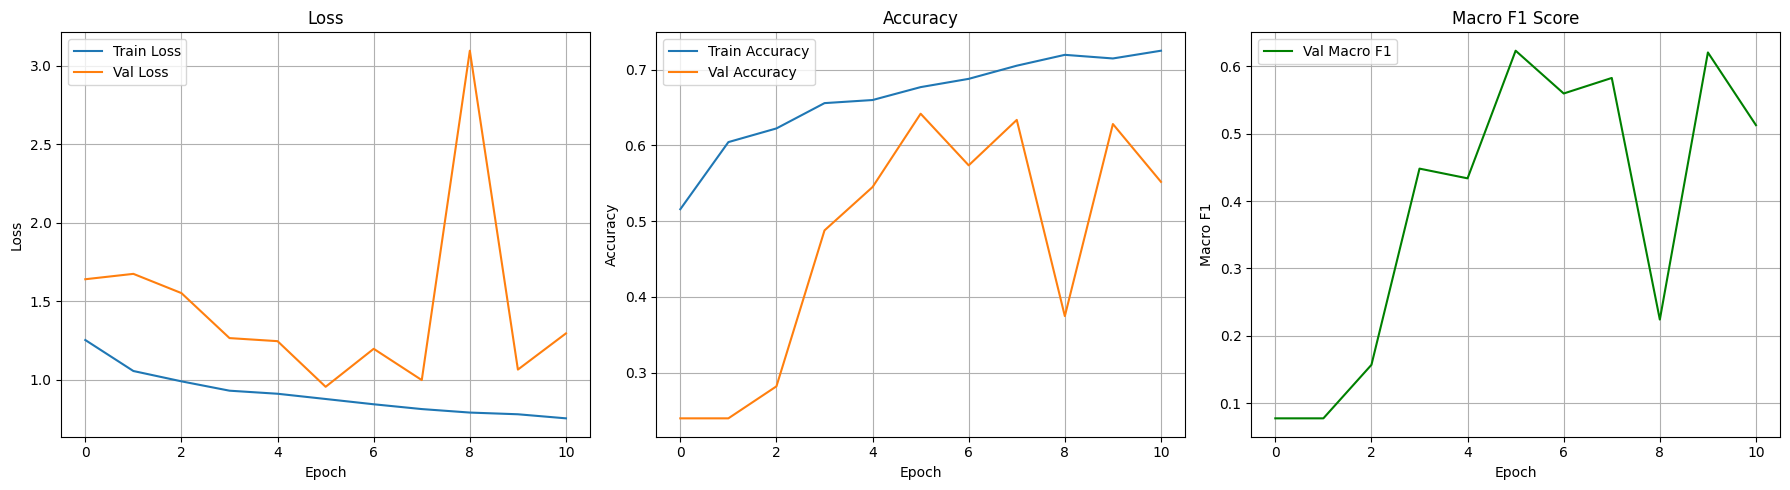

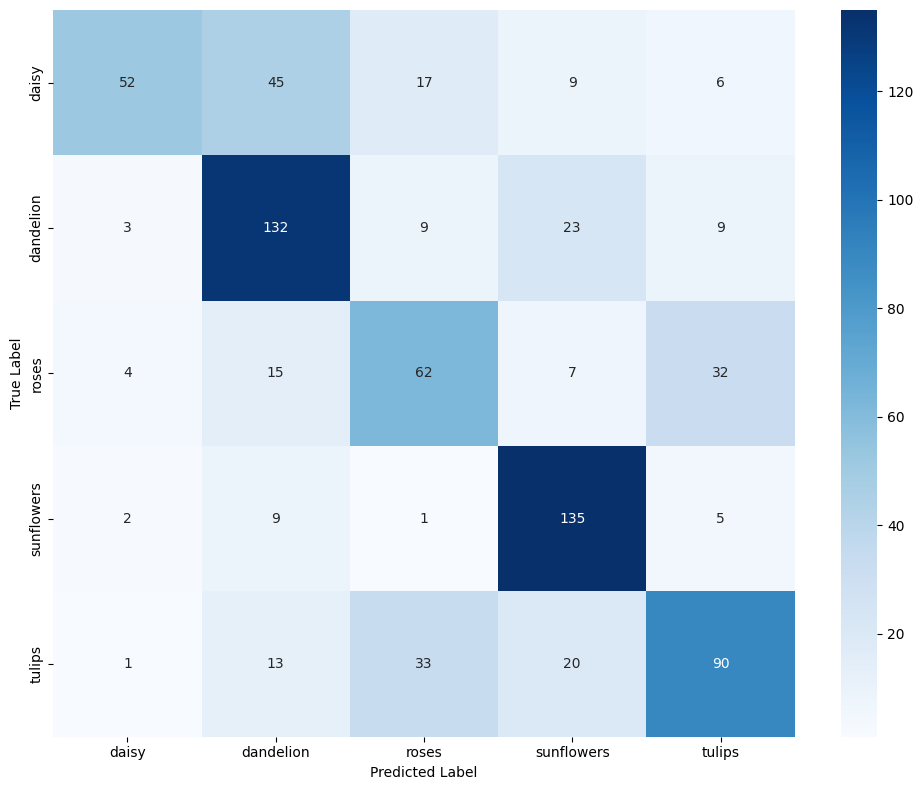



EXPERIMENT 12/19
Config: {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': 'l1', 'reg_value': 0.0005}
Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 2.8334 - accuracy: 0.5296 — val_macro_f1: 0.0874
 — epoch_time: 33.00s (avg: 33.00s)
92/92 [==============================] - 33s 317ms/step - loss: 2.8334 - accuracy: 0.5296 - val_loss: 3.1968 - val_accuracy: 0.2439 - val_macro_f1: 0.0874
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 2.5617 - accuracy: 0.6097 — val_macro_f1: 0.1326
 — epoch_time: 29.16s (avg: 31.08s)
92/92 [==============================] - 29s 317ms/step - loss: 2.5617 - accuracy: 0.6097 - val_loss: 3.0991 - val_accuracy: 0.2698 - val_macro_f1: 0.1326
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 2.3725 - accuracy: 0.6236 — val_macro_f1: 0.1490
 — epoch_time: 28.72s (avg: 30.29s)
92/92 [=======

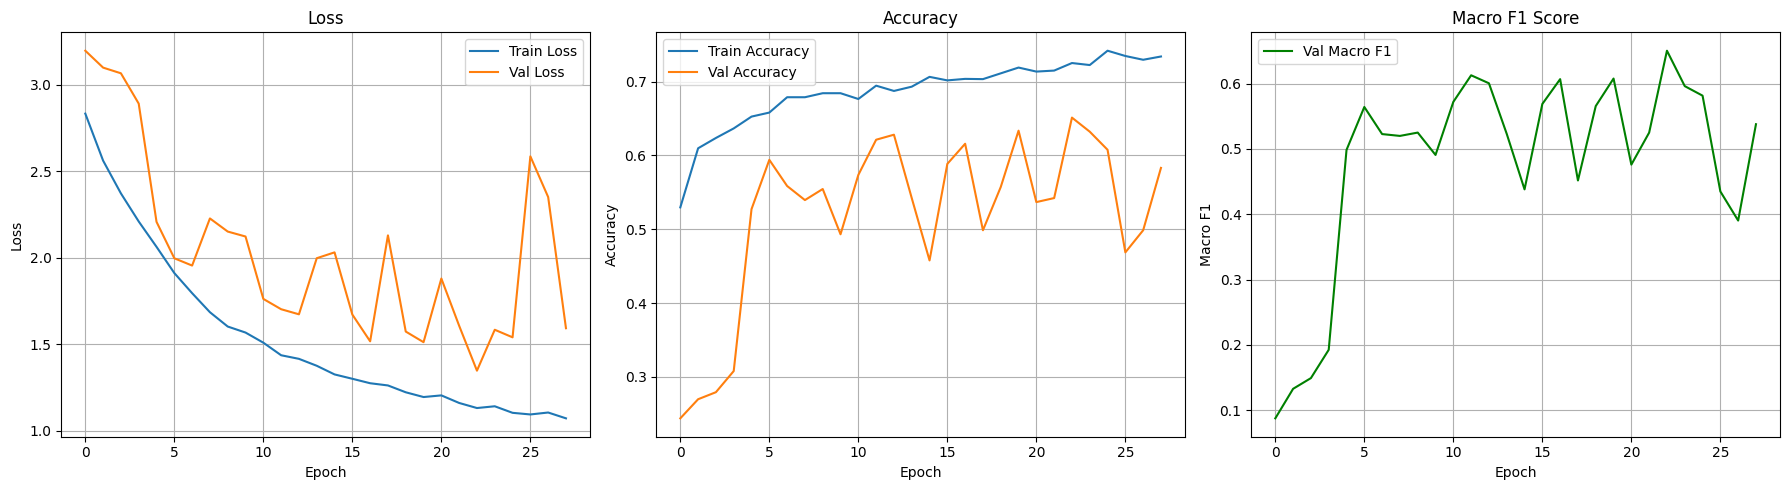

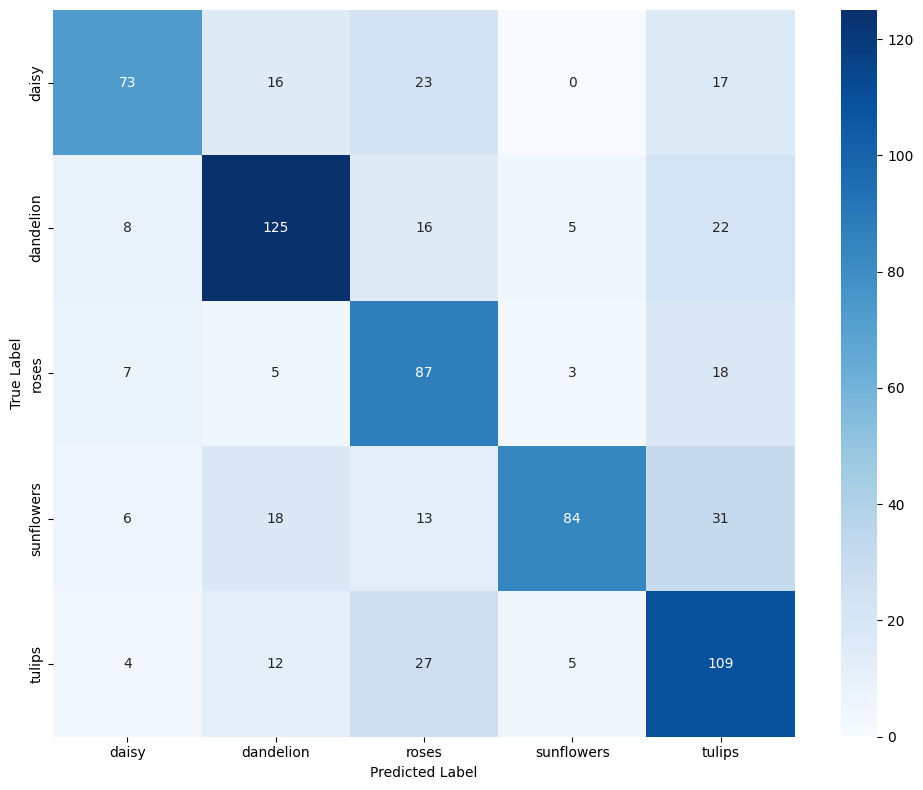



EXPERIMENT 13/19
Config: {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': 'l2', 'reg_value': 0.001}
Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 1.4125 - accuracy: 0.5341 — val_macro_f1: 0.0774
 — epoch_time: 32.27s (avg: 32.27s)
92/92 [==============================] - 32s 313ms/step - loss: 1.4125 - accuracy: 0.5341 - val_loss: 1.8423 - val_accuracy: 0.2398 - val_macro_f1: 0.0774
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 1.2183 - accuracy: 0.6178 — val_macro_f1: 0.0774
 — epoch_time: 28.55s (avg: 30.41s)
92/92 [==============================] - 29s 311ms/step - loss: 1.2183 - accuracy: 0.6178 - val_loss: 1.9327 - val_accuracy: 0.2398 - val_macro_f1: 0.0774
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 1.1587 - accuracy: 0.6376 — val_macro_f1: 0.2867
 — epoch_time: 28.29s (avg: 29.70s)
92/92 [========

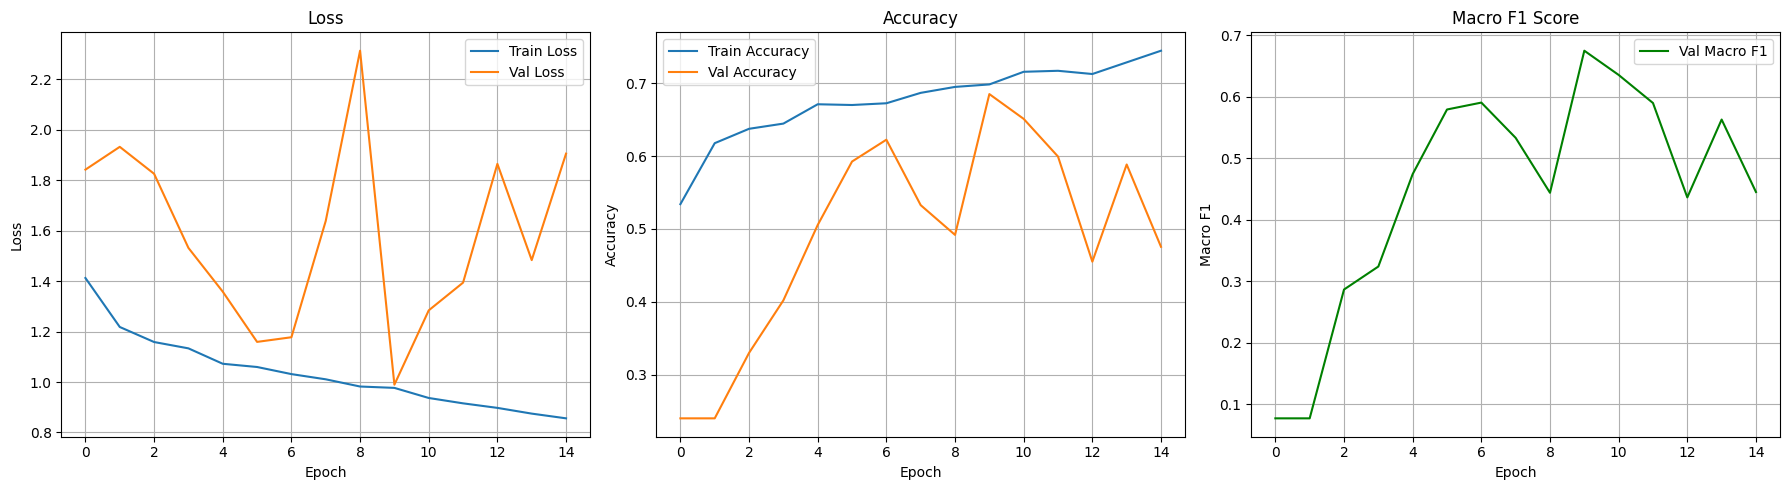

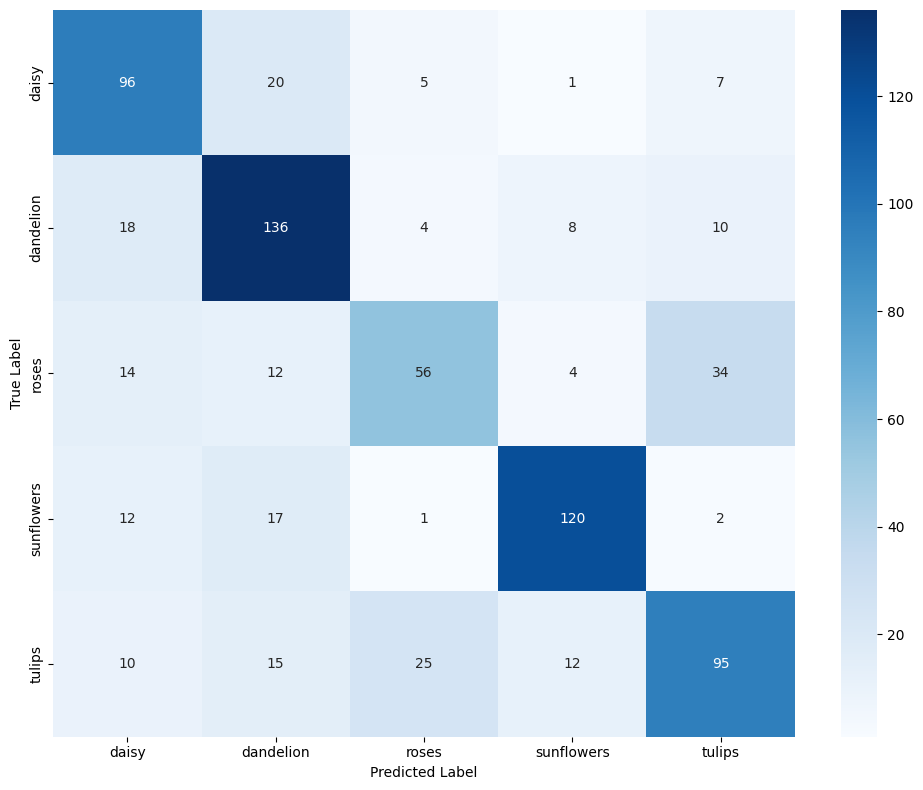



EXPERIMENT 14/19
Config: {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': 'l2', 'reg_value': 1e-05}
Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 1.2125 - accuracy: 0.5238 — val_macro_f1: 0.0969
 — epoch_time: 32.38s (avg: 32.38s)
92/92 [==============================] - 32s 312ms/step - loss: 1.2125 - accuracy: 0.5238 - val_loss: 1.6368 - val_accuracy: 0.2480 - val_macro_f1: 0.0969
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 1.0753 - accuracy: 0.5705 — val_macro_f1: 0.1423
 — epoch_time: 28.39s (avg: 30.38s)
92/92 [==============================] - 28s 309ms/step - loss: 1.0753 - accuracy: 0.5705 - val_loss: 1.5750 - val_accuracy: 0.2738 - val_macro_f1: 0.1423
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 0.9793 - accuracy: 0.6158 — val_macro_f1: 0.2270
 — epoch_time: 28.48s (avg: 29.75s)
92/92 [========

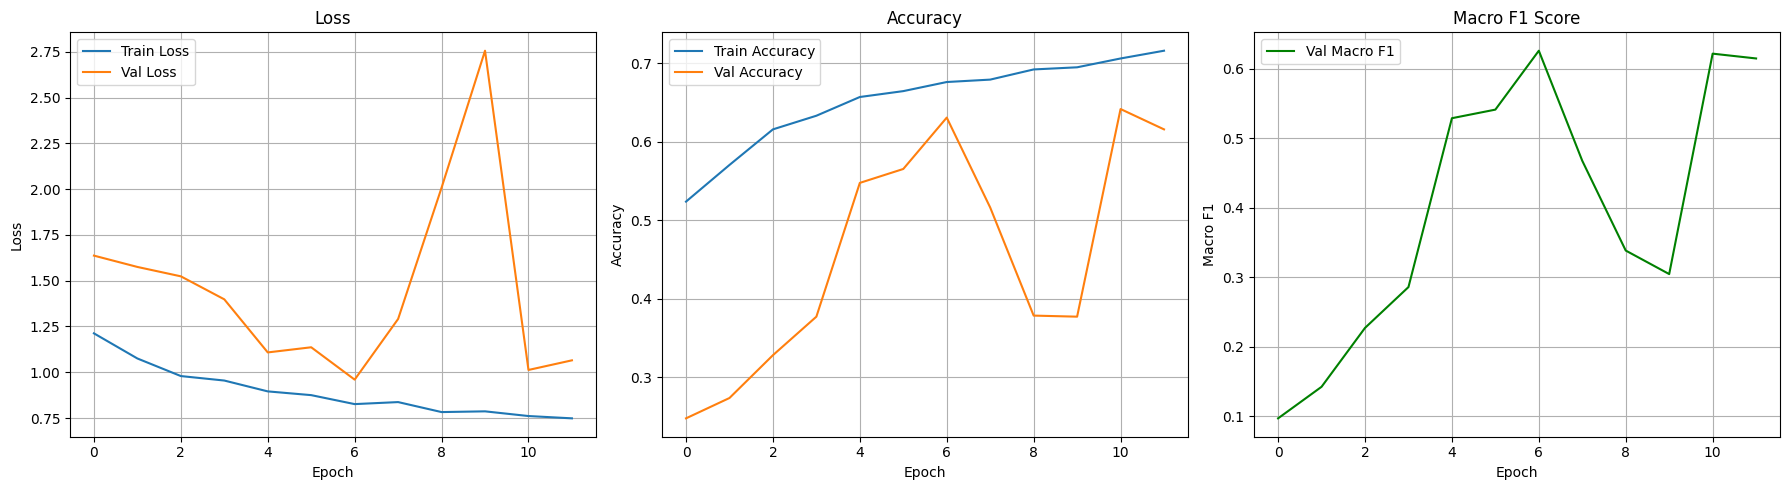

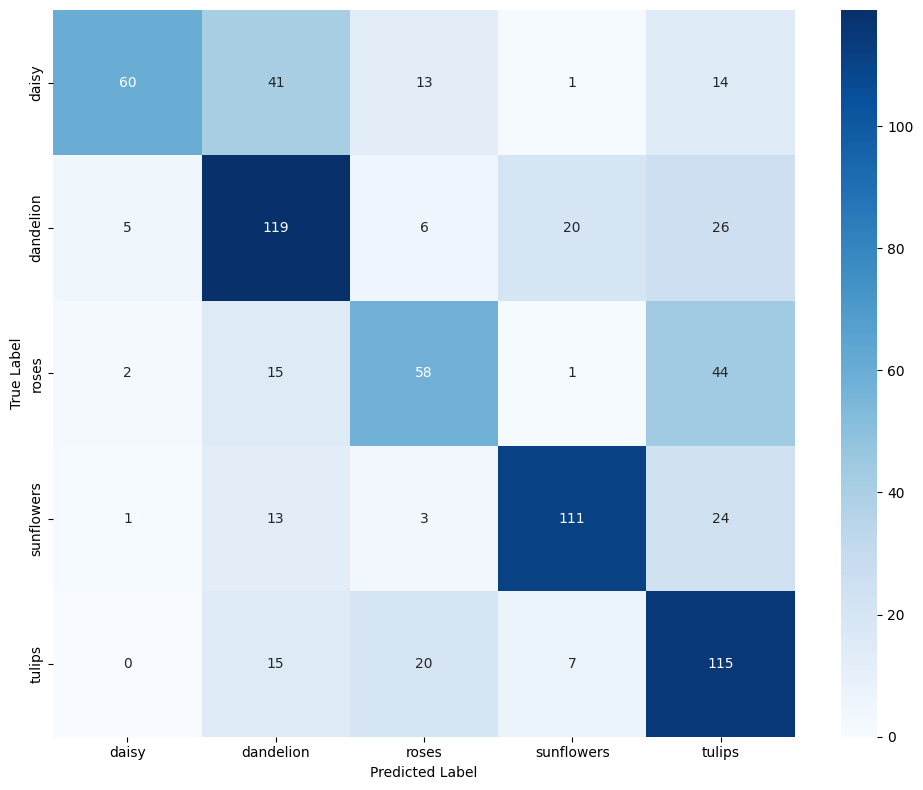



EXPERIMENT 15/19
Config: {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': 'l2', 'reg_value': 0.0005}
Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 1.2983 - accuracy: 0.5361 — val_macro_f1: 0.0774
 — epoch_time: 31.92s (avg: 31.92s)
92/92 [==============================] - 32s 310ms/step - loss: 1.2983 - accuracy: 0.5361 - val_loss: 1.7391 - val_accuracy: 0.2398 - val_macro_f1: 0.0774
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 1.1300 - accuracy: 0.6035 — val_macro_f1: 0.0774
 — epoch_time: 28.17s (avg: 30.04s)
92/92 [==============================] - 28s 306ms/step - loss: 1.1300 - accuracy: 0.6035 - val_loss: 1.7726 - val_accuracy: 0.2398 - val_macro_f1: 0.0774
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 1.0539 - accuracy: 0.6308 — val_macro_f1: 0.0918
 — epoch_time: 28.16s (avg: 29.42s)
92/92 [=======

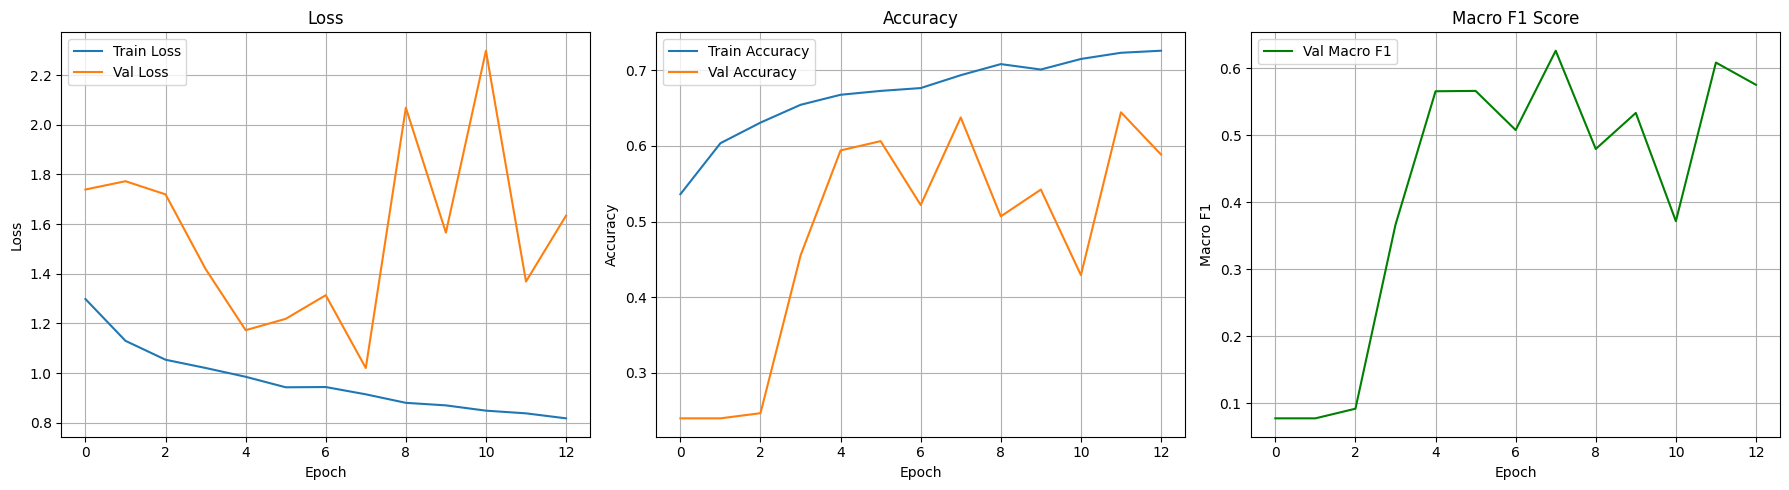

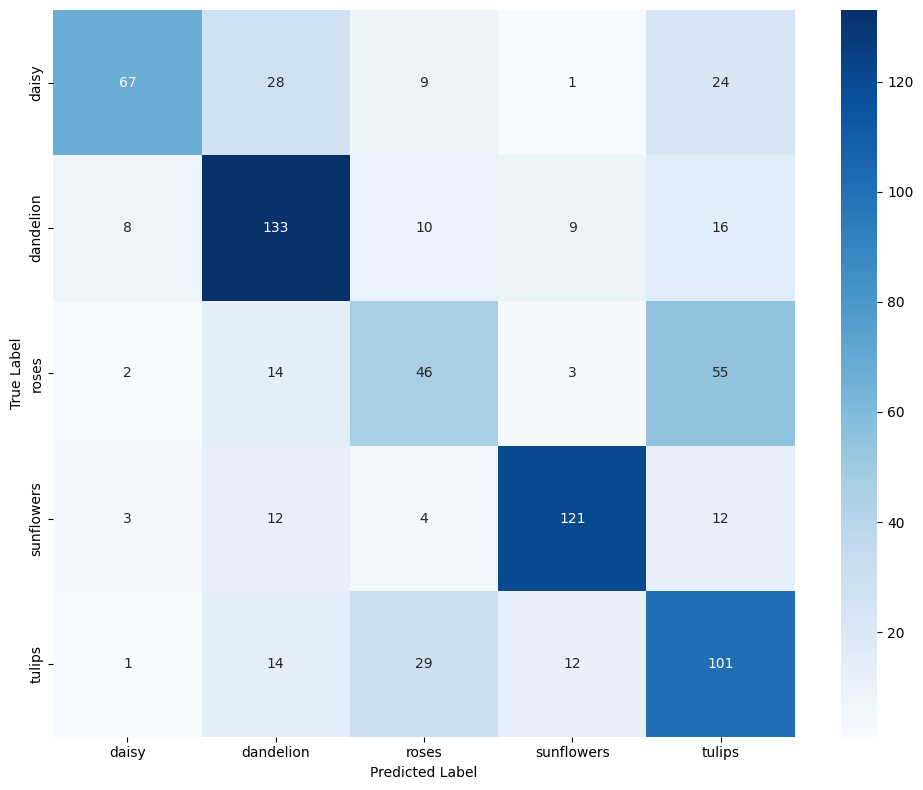



EXPERIMENT 16/19
Config: {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 64, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}
Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 1.1928 - accuracy: 0.5249 — val_macro_f1: 0.0774
 — epoch_time: 31.79s (avg: 31.79s)
92/92 [==============================] - 32s 310ms/step - loss: 1.1928 - accuracy: 0.5249 - val_loss: 1.6590 - val_accuracy: 0.2398 - val_macro_f1: 0.0774
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 1.0384 - accuracy: 0.6001 — val_macro_f1: 0.0829
 — epoch_time: 28.39s (avg: 30.09s)
92/92 [==============================] - 28s 310ms/step - loss: 1.0384 - accuracy: 0.6001 - val_loss: 1.6201 - val_accuracy: 0.2425 - val_macro_f1: 0.0829
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 0.9607 - accuracy: 0.6213 — val_macro_f1: 0.2102
 — epoch_time: 28.39s (avg: 29.52s)
92/92 [=============

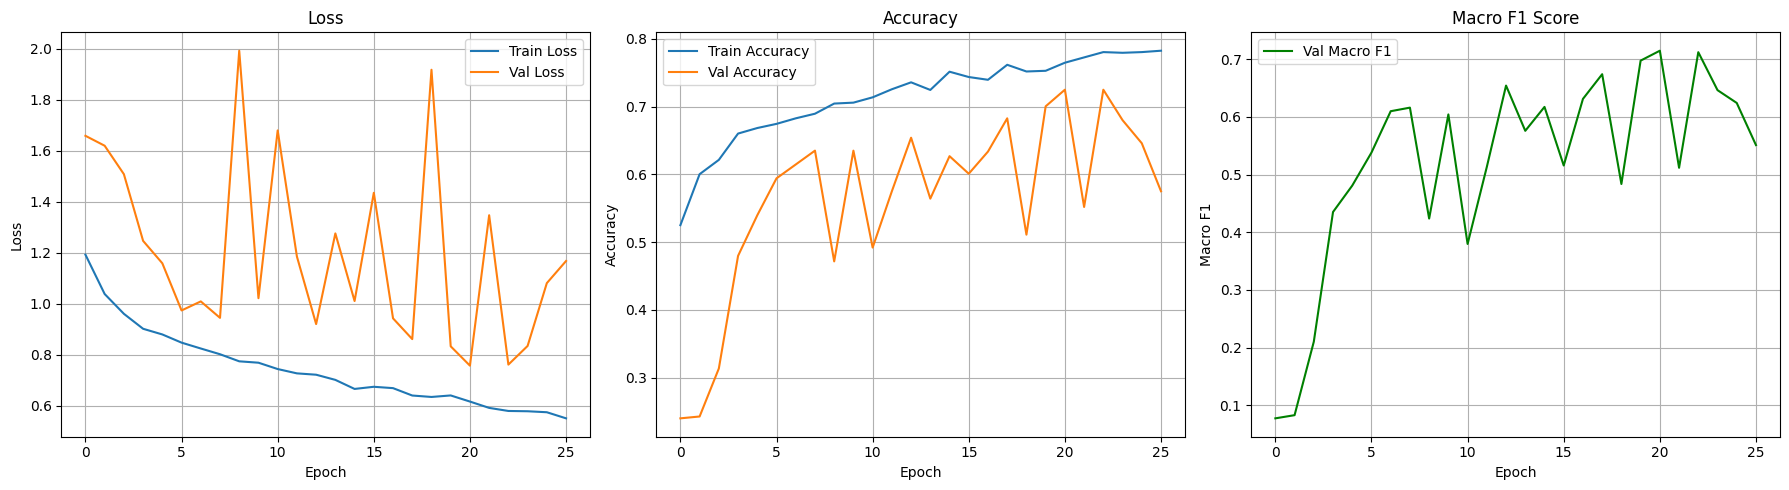

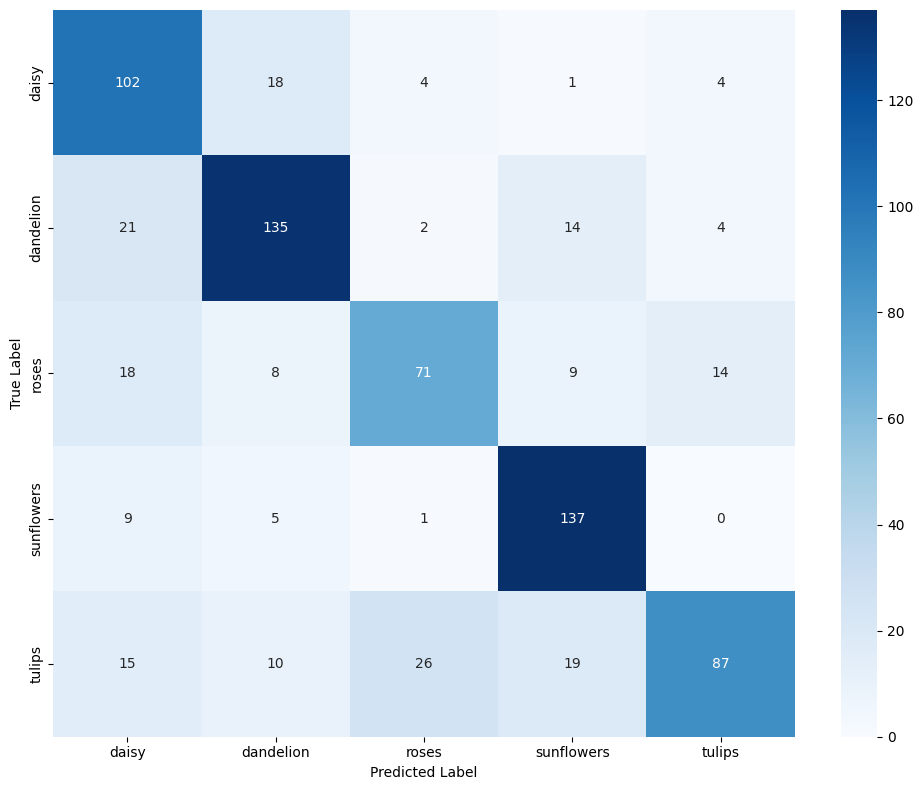


Results: Macro F1 = 0.7149, Time = 743.07s


EXPERIMENT 17/19
Config: {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 256, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}
Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 1.1953 - accuracy: 0.5296 — val_macro_f1: 0.0774
 — epoch_time: 32.49s (avg: 32.49s)
92/92 [==============================] - 32s 317ms/step - loss: 1.1953 - accuracy: 0.5296 - val_loss: 1.6167 - val_accuracy: 0.2398 - val_macro_f1: 0.0774
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 1.0094 - accuracy: 0.6066 — val_macro_f1: 0.0774
 — epoch_time: 28.89s (avg: 30.69s)
92/92 [==============================] - 29s 314ms/step - loss: 1.0094 - accuracy: 0.6066 - val_loss: 1.6548 - val_accuracy: 0.2398 - val_macro_f1: 0.0774
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 0.9485 - accuracy: 0.6335 — val_macro_f1: 0.0954
 — epoch_ti

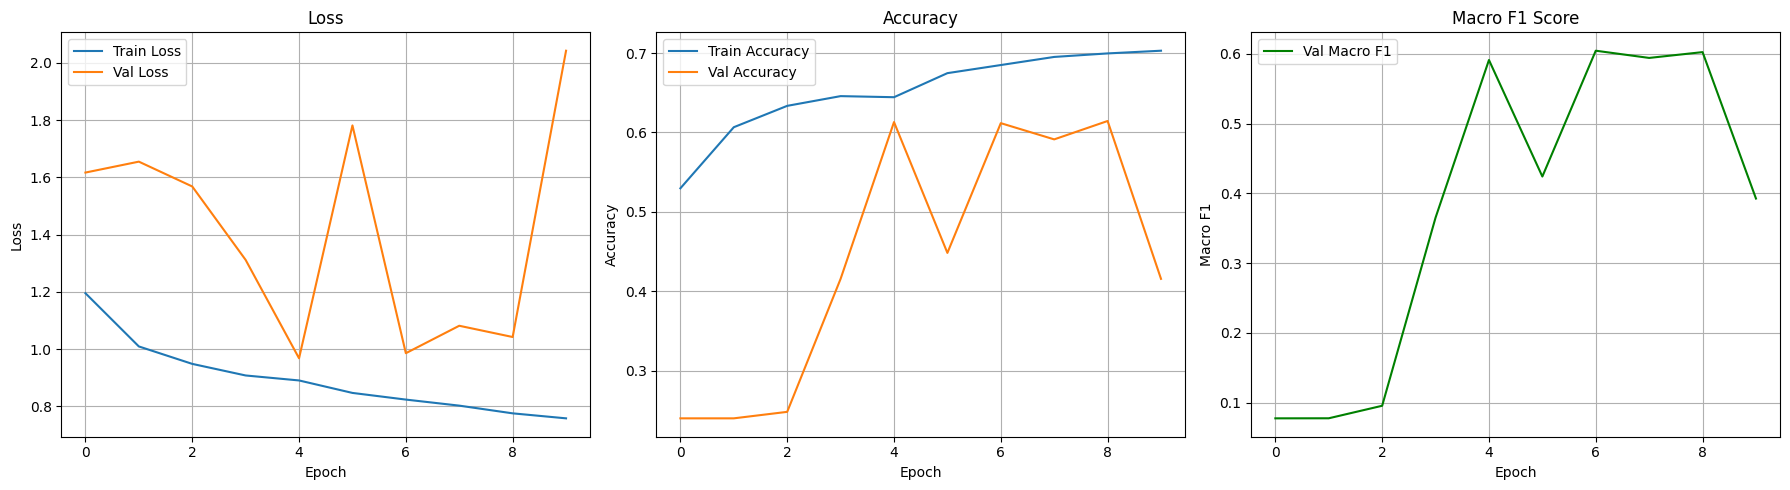

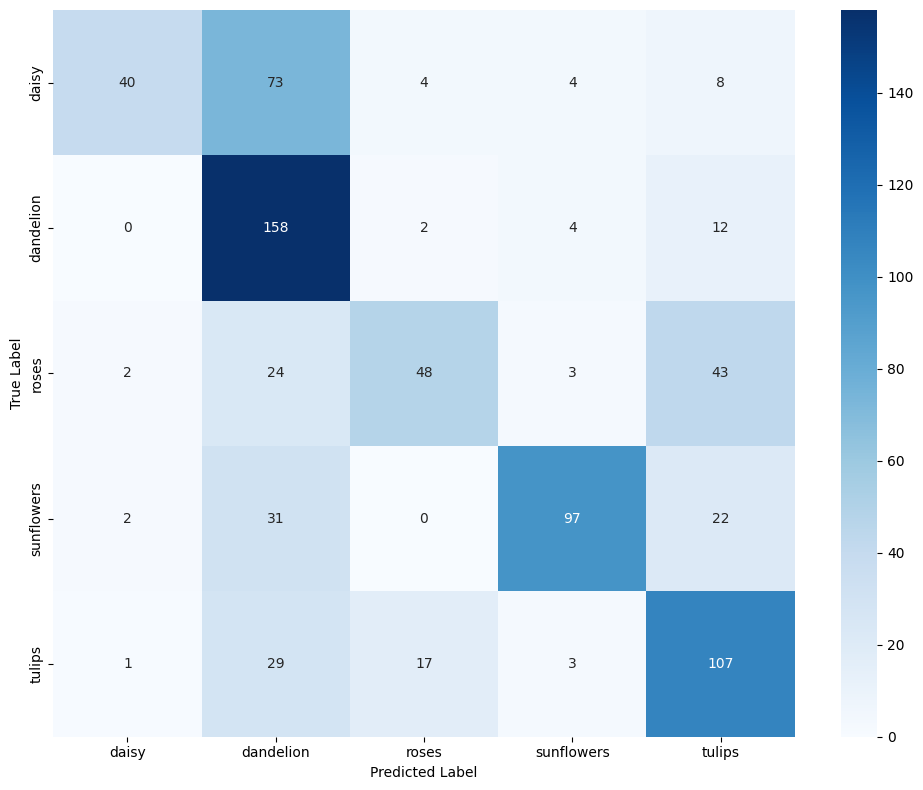



EXPERIMENT 18/19
Config: {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'sigmoid', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}
Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 1.4186 - accuracy: 0.3811 — val_macro_f1: 0.0705
 — epoch_time: 32.29s (avg: 32.29s)
92/92 [==============================] - 32s 315ms/step - loss: 1.4186 - accuracy: 0.3811 - val_loss: 1.7164 - val_accuracy: 0.2139 - val_macro_f1: 0.0705
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 1.3278 - accuracy: 0.4366 — val_macro_f1: 0.0705
 — epoch_time: 28.70s (avg: 30.49s)
92/92 [==============================] - 29s 312ms/step - loss: 1.3278 - accuracy: 0.4366 - val_loss: 1.7325 - val_accuracy: 0.2139 - val_macro_f1: 0.0705
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 1.3102 - accuracy: 0.4619 — val_macro_f1: 0.0705
 — epoch_time: 28.74s (avg: 29.91s)
92/92 [=========

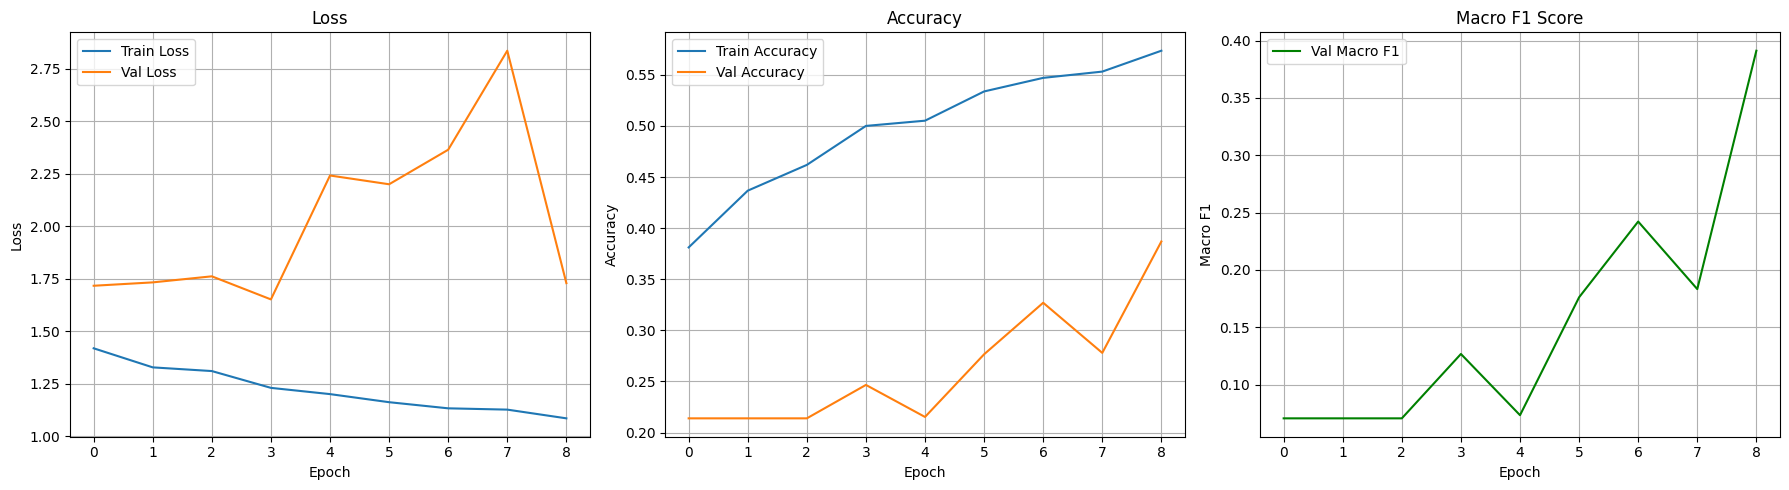

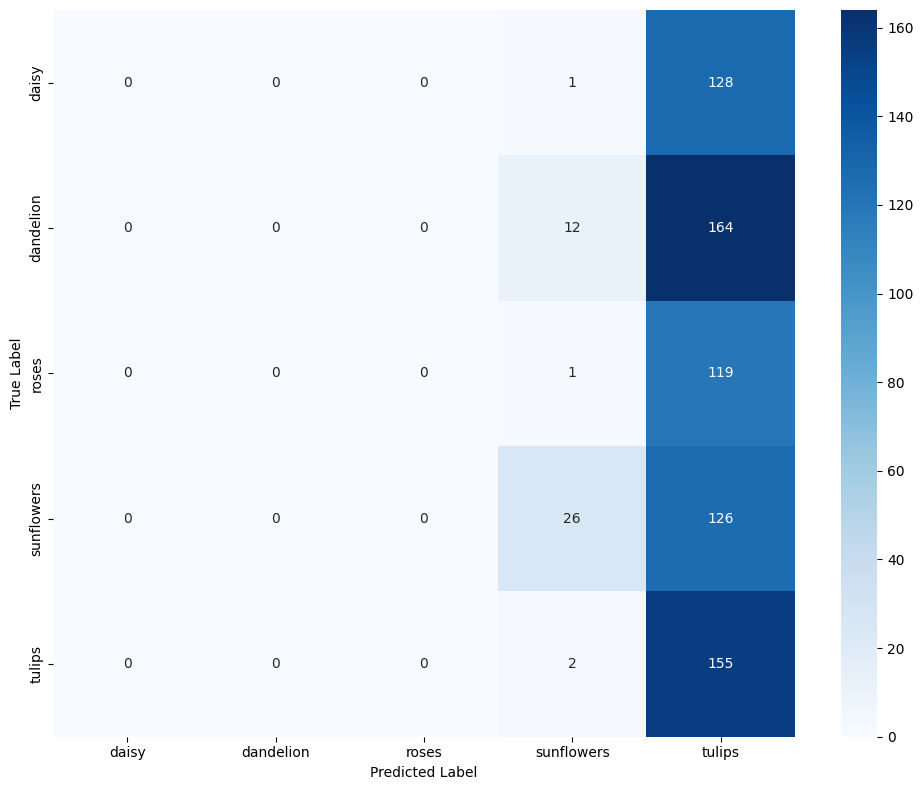



EXPERIMENT 19/19
Config: {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'tanh', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}
Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 1.4106 - accuracy: 0.4029 — val_macro_f1: 0.2728
 — epoch_time: 32.54s (avg: 32.54s)
92/92 [==============================] - 33s 319ms/step - loss: 1.4106 - accuracy: 0.4029 - val_loss: 1.4914 - val_accuracy: 0.3610 - val_macro_f1: 0.2728
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 1.2873 - accuracy: 0.4721 — val_macro_f1: 0.2605
 — epoch_time: 28.49s (avg: 30.52s)
92/92 [==============================] - 28s 310ms/step - loss: 1.2873 - accuracy: 0.4721 - val_loss: 1.4474 - val_accuracy: 0.3392 - val_macro_f1: 0.2605
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 1.2301 - accuracy: 0.5140 — val_macro_f1: 0.2758
 — epoch_time: 28.43s (avg: 29.82s)
92/92 [============

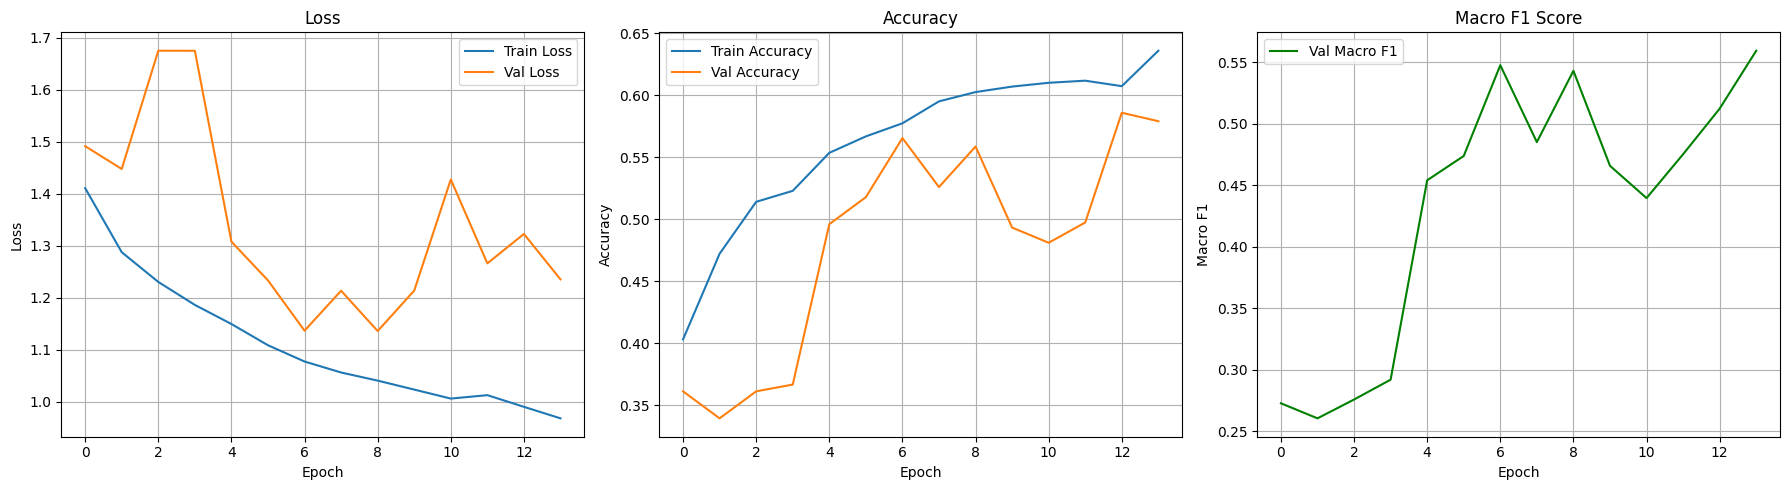

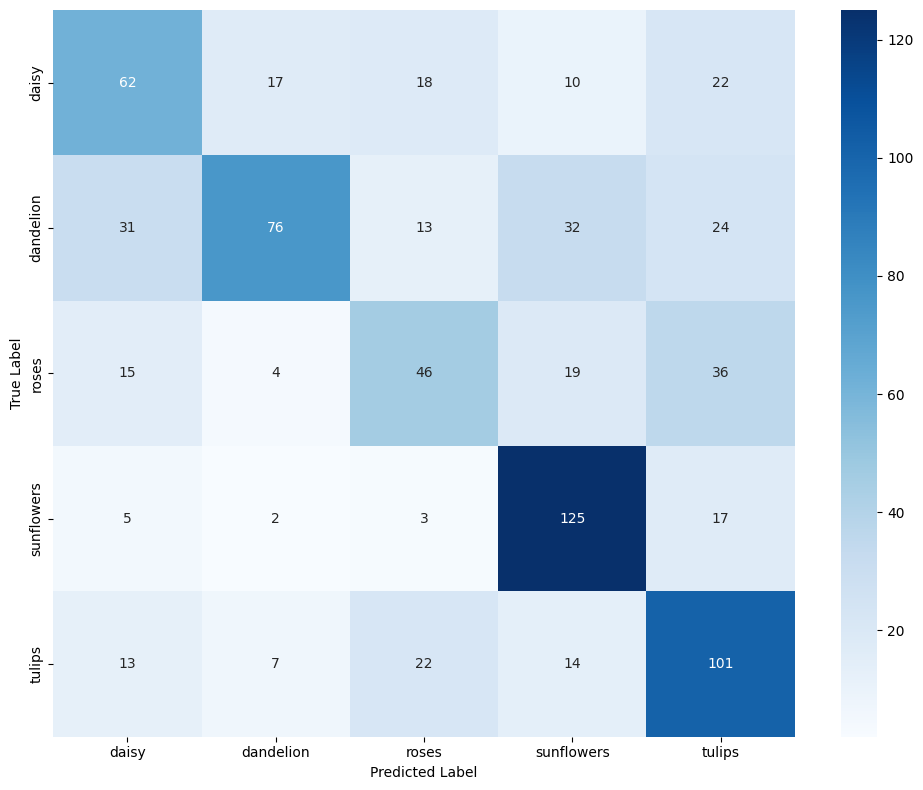

In [ ]:
epochs = 30
for idx, config in enumerate(grid_search_configs):
    print(f"\n\nEXPERIMENT {idx + 1}/{len(grid_search_configs)}")
    print(f"Config: {config}")
    experiment_name = f"exp_{idx+1}"

    model = build_model(**config)
    f1_callback = MacroF1(val_ds)
    early_stopping = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=5, restore_best_weights=True )
    epoch_timer = EpochTimer()

    start_time = time.time()
    with tf.device('/GPU:0'):
        history = model.fit( train_ds, validation_data=val_ds, epochs=epochs, callbacks=[f1_callback, early_stopping, epoch_timer], verbose=1 )
        training_time = time.time() - start_time
        y_true, y_pred, final_f1 = evaluate_model(model, val_ds)

        result = {
            "experiment": idx + 1,
            "config": config,
            "final_macro_f1": final_f1,
            "training_time_seconds": training_time,
            "epochs_trained": len(history.history['loss']),
            "final_val_loss": history.history['val_loss'][-1],
            "final_val_accuracy": history.history['val_accuracy'][-1]
        }
        results.append(result)

        plot_training_history(history, f1_callback)
        plot_confusion_matrix(y_true, y_pred, class_names)

        if final_f1 > best_f1:
            best_f1 = final_f1
            best_model = model
            best_config = config
            best_history = history
            best_f1_callback = f1_callback
        print(f"\nResults: Macro F1 = {final_f1:.4f}, Time = {training_time:.2f}s")


In [10]:
results_df = pd.DataFrame(results)

print(results_df.to_string(index=False))

print(f"Best Macro F1: {best_f1:.4f}")
print(f"Config: {best_config}")

 experiment                                                                                                                                                                                        config  final_macro_f1  training_time_seconds  epochs_trained  final_val_loss  final_val_accuracy
          1      {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}        0.628207             323.343255              11        1.157352            0.580381
          2     {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.0005, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}        0.599536             316.918317              11        0.984183            0.637602
          3     {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.0003, 

In [11]:
print_model_weights_info(best_model)

print(classification_report(y_true, y_pred, target_names=class_names))


MODEL ARCHITECTURE & WEIGHTS INFO

Layer 2: conv2d_66 (Conv2D)
  Kernel: shape=(3, 3, 3, 32), mean=-0.000060, std=0.093158, min=-0.241833, max=0.230193
  Bias: shape=(32,), mean=-0.001565, std=0.012799, min=-0.024489, max=0.034846

Layer 3: batch_normalization_77 (BatchNormalization)
  Kernel: shape=(32,), mean=0.989228, std=0.072724, min=0.811321, max=1.171776
  Bias: shape=(32,), mean=-0.054357, std=0.074926, min=-0.199487, max=0.128266
  Param_2: shape=(32,), mean=0.007064, std=0.165260, min=-0.291215, max=0.440022
  Param_3: shape=(32,), mean=0.016567, std=0.018577, min=0.001027, max=0.065993

Layer 5: conv2d_67 (Conv2D)
  Kernel: shape=(3, 3, 32, 32), mean=-0.002085, std=0.071126, min=-0.284239, max=0.266840
  Bias: shape=(32,), mean=-0.000158, std=0.001954, min=-0.005143, max=0.004883

Layer 6: batch_normalization_78 (BatchNormalization)
  Kernel: shape=(32,), mean=0.987203, std=0.055219, min=0.870230, max=1.104139
  Bias: shape=(32,), mean=-0.106934, std=0.060780, min=-0.327351,

In [ ]:
grid_search_configs = [
    #New Baseline
   #  {"conv_layers": 2, "dense_layers": 1, "dense_units": 64, "activation": "relu",
   #   "learning_rate": 0.001, "use_pooling": True, "use_batchnorm": True, 
   #   "regularizer": None, "reg_value": 0},

     #Learning rate
      {"conv_layers": 2, "dense_layers": 1, "dense_units": 64, "activation": "relu",
     "learning_rate": 0.0001, "use_pooling": True, "use_batchnorm": True, 
     "regularizer": None, "reg_value": 0},


    #Convolution Layers

     {"conv_layers": 4, "dense_layers": 1, "dense_units": 64, "activation": "relu",
     "learning_rate": 0.001, "use_pooling": True, "use_batchnorm": True, 
     "regularizer": None, "reg_value": 0},
     #Pooling 

      {"conv_layers": 2, "dense_layers": 1, "dense_units": 64, "activation": "relu",
     "learning_rate": 0.001, "use_pooling": False, "use_batchnorm": True, 
     "regularizer": None, "reg_value": 0},
     #Batch Norm
    {"conv_layers": 2, "dense_layers": 1, "dense_units": 64, "activation": "relu",
     "learning_rate": 0.001, "use_pooling": True, "use_batchnorm": False, 
     "regularizer": None, "reg_value": 0},
     
     # L1
     {"conv_layers": 2, "dense_layers": 1, "dense_units": 64, "activation": "relu",
     "learning_rate": 0.001, "use_pooling": True, "use_batchnorm": True, 
     "regularizer": 'l1', "reg_value": 0.001},

     #L2 
    {"conv_layers": 2, "dense_layers": 1, "dense_units": 64, "activation": "relu",
     "learning_rate": 0.001, "use_pooling": True, "use_batchnorm": True, 
     "regularizer": 'l2', "reg_value": 0.001},

     #Neuronen 
      {"conv_layers": 3, "dense_layers": 1, "dense_units": 256, "activation": "relu",
     "learning_rate": 0.001, "use_pooling": True, "use_batchnorm": True, 
     "regularizer": None, "reg_value": 0},
]

results = []
best_f1 = 0
best_model = None
best_config = None
best_history = None
best_f1_callback = None



EXPERIMENT 1/7
Config: {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 64, 'activation': 'relu', 'learning_rate': 0.0001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}
Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 1.2885 - accuracy: 0.4939 — val_macro_f1: 0.0774
 — epoch_time: 31.47s (avg: 31.47s)
92/92 [==============================] - 31s 304ms/step - loss: 1.2885 - accuracy: 0.4939 - val_loss: 1.6839 - val_accuracy: 0.2398 - val_macro_f1: 0.0774
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 1.0694 - accuracy: 0.5967 — val_macro_f1: 0.0774
 — epoch_time: 27.74s (avg: 29.61s)
92/92 [==============================] - 28s 302ms/step - loss: 1.0694 - accuracy: 0.5967 - val_loss: 1.8387 - val_accuracy: 0.2398 - val_macro_f1: 0.0774
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 1.0015 - accuracy: 0.6250 — val_macro_f1: 0.0927
 — epoch_time: 27.70s (avg: 28.97s)
92/92 [==============

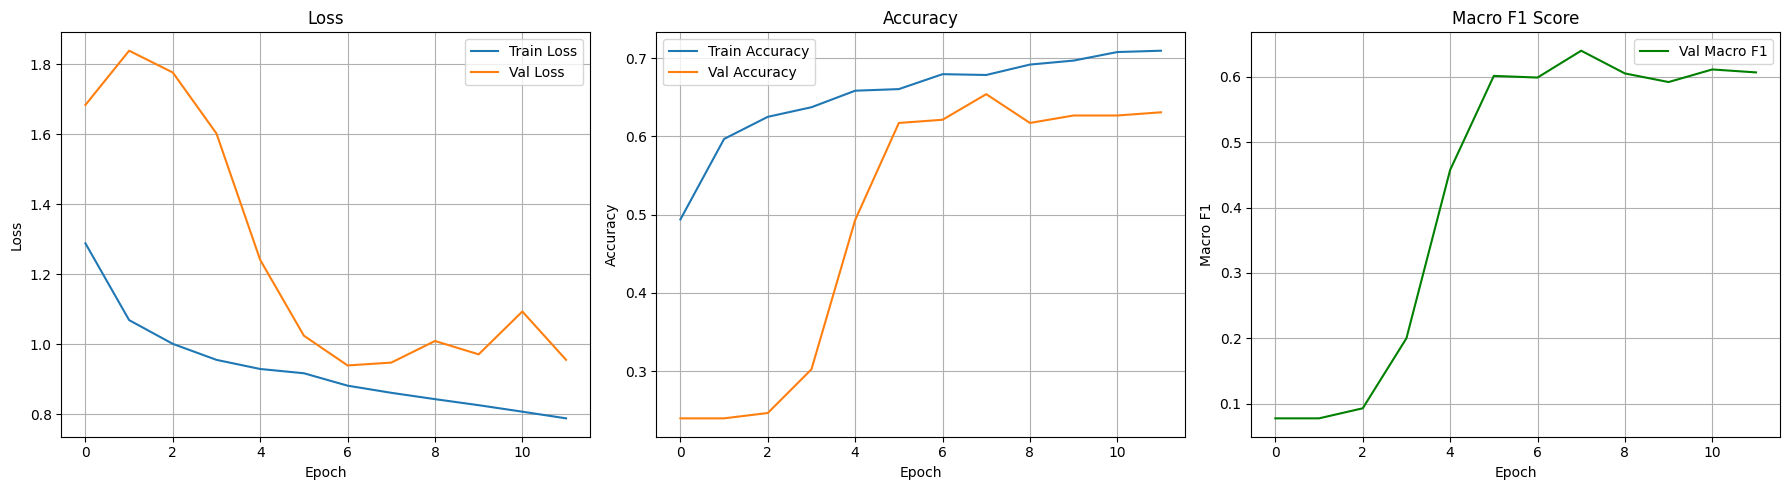

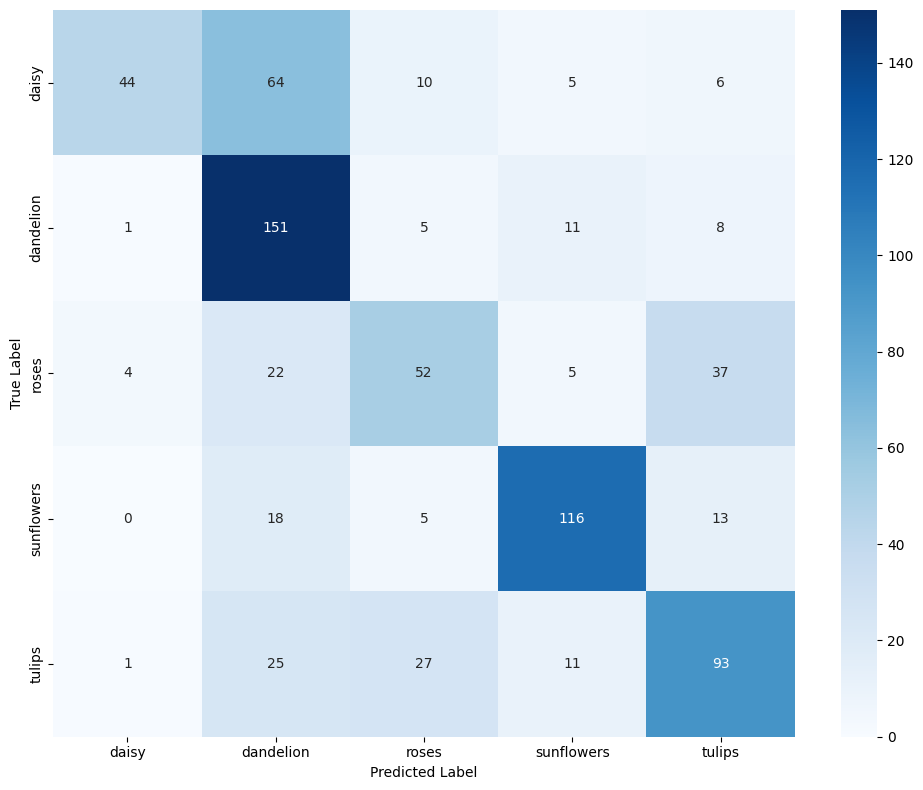


Results: Macro F1 = 0.5989, Time = 336.43s


EXPERIMENT 2/7
Config: {'conv_layers': 4, 'dense_layers': 1, 'dense_units': 64, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}
Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 1.2213 - accuracy: 0.5198 — val_macro_f1: 0.0774
 — epoch_time: 36.52s (avg: 36.52s)
92/92 [==============================] - 37s 352ms/step - loss: 1.2213 - accuracy: 0.5198 - val_loss: 1.8484 - val_accuracy: 0.2398 - val_macro_f1: 0.0774
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 1.0030 - accuracy: 0.6172 — val_macro_f1: 0.2091
 — epoch_time: 31.49s (avg: 34.00s)
92/92 [==============================] - 31s 343ms/step - loss: 1.0030 - accuracy: 0.6172 - val_loss: 1.7245 - val_accuracy: 0.3270 - val_macro_f1: 0.2091
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 0.9416 - accuracy: 0.6356 — val_macro_f1: 0.2781
 — epoch_time:

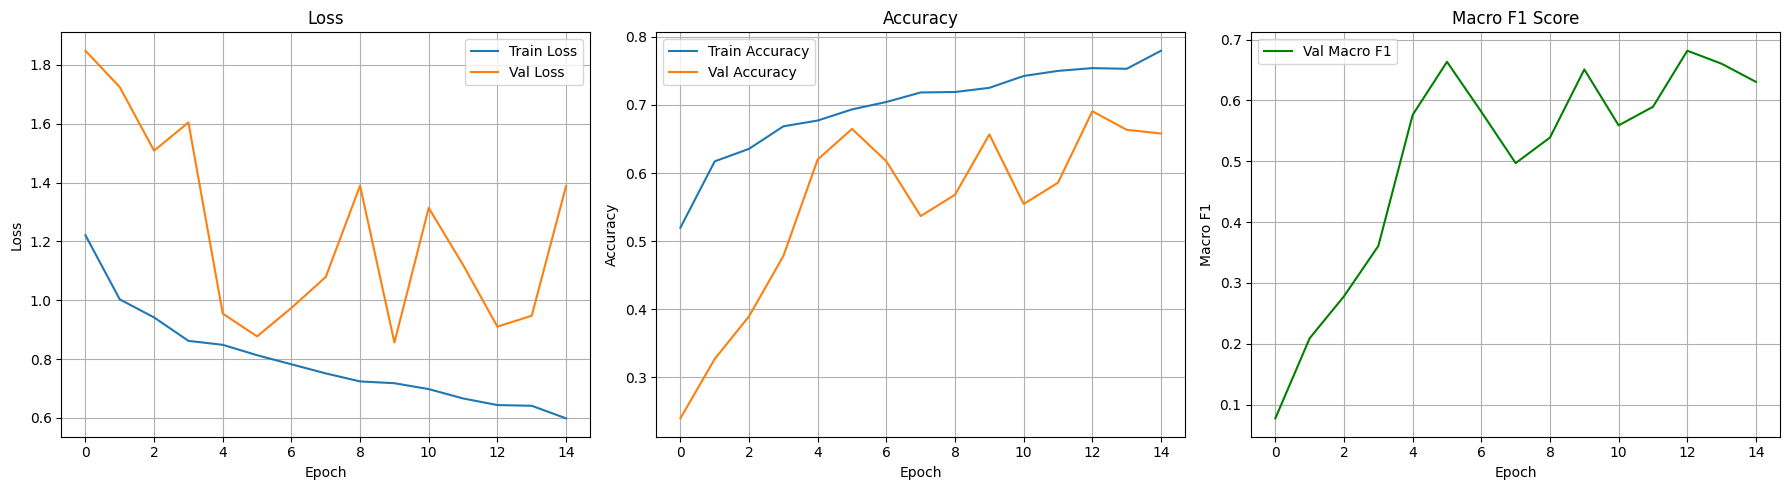

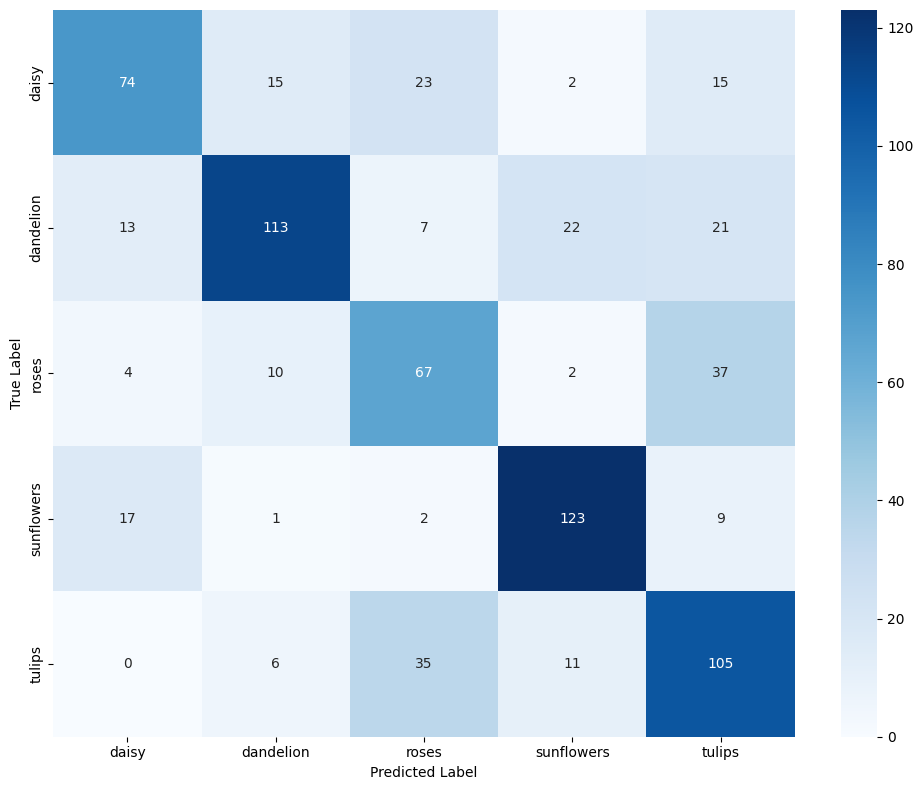


Results: Macro F1 = 0.6510, Time = 476.72s


EXPERIMENT 3/7
Config: {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 64, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': False, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}
Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 1.2686 - accuracy: 0.4608 — val_macro_f1: 0.0774
 — epoch_time: 44.68s (avg: 44.68s)
92/92 [==============================] - 45s 435ms/step - loss: 1.2686 - accuracy: 0.4608 - val_loss: 1.5871 - val_accuracy: 0.2398 - val_macro_f1: 0.0774
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 1.0721 - accuracy: 0.5766 — val_macro_f1: 0.0874
 — epoch_time: 37.87s (avg: 41.27s)
92/92 [==============================] - 38s 412ms/step - loss: 1.0721 - accuracy: 0.5766 - val_loss: 1.6683 - val_accuracy: 0.2439 - val_macro_f1: 0.0874
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 1.0175 - accuracy: 0.6151 — val_macro_f1: 0.1488
 — epoch_time

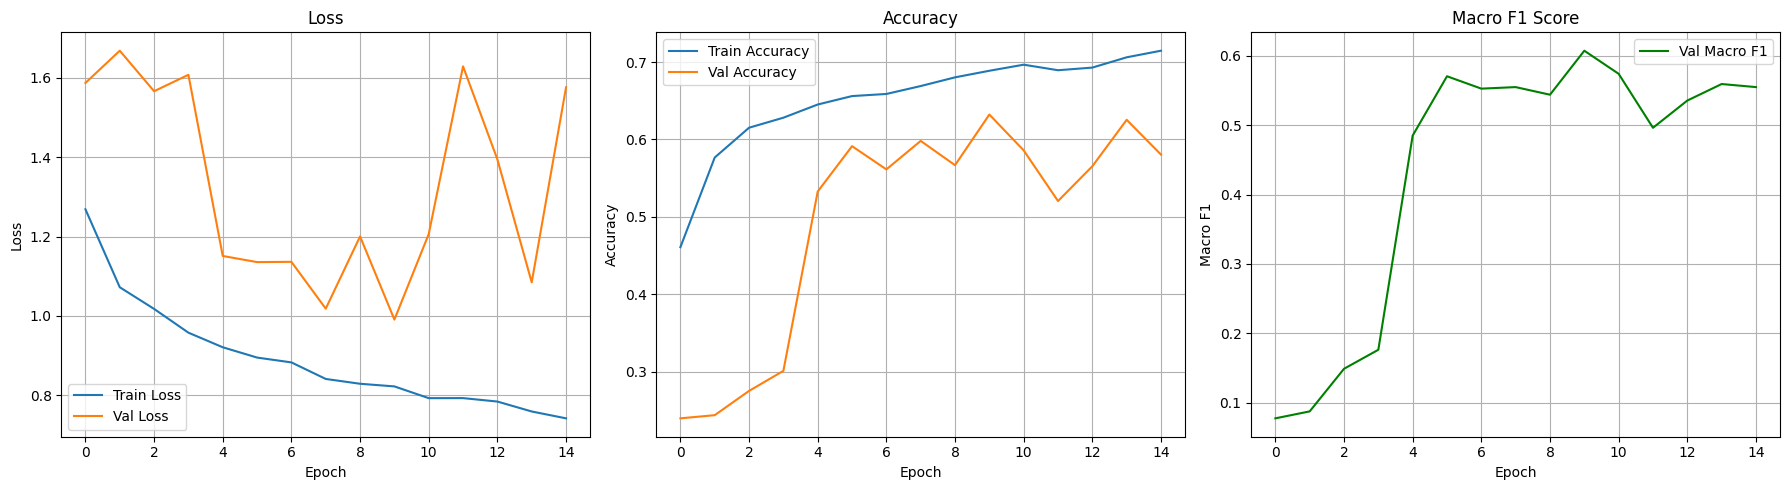

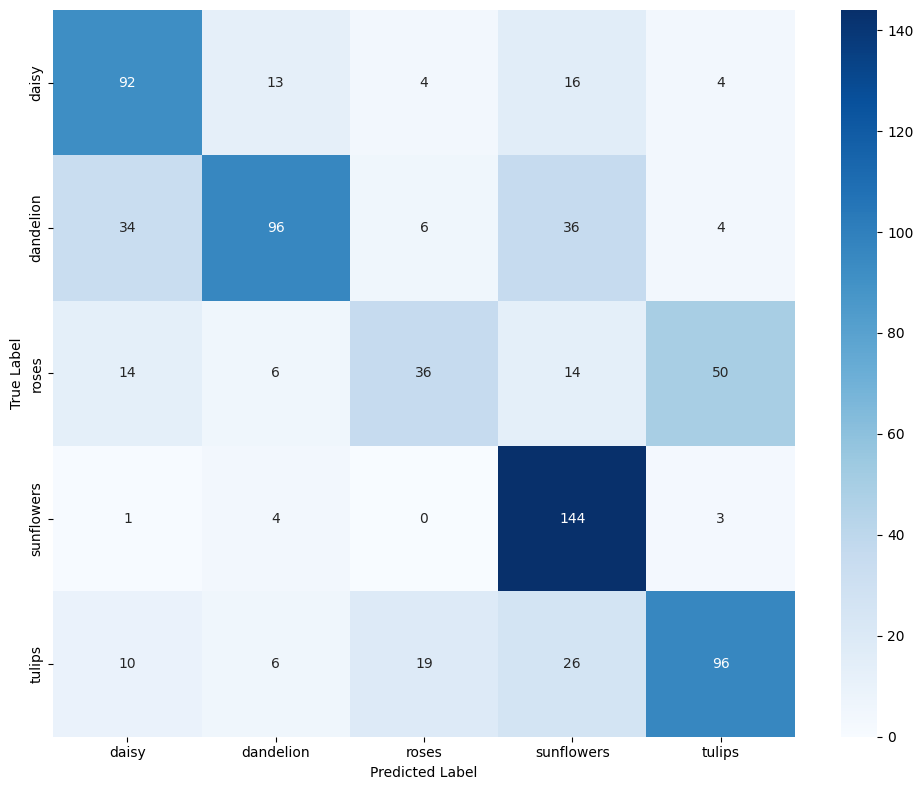


Results: Macro F1 = 0.6076, Time = 574.67s


EXPERIMENT 4/7
Config: {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 64, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': False, 'regularizer': None, 'reg_value': 0}
Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 1.4211 - accuracy: 0.3610 — val_macro_f1: 0.3285
 — epoch_time: 28.46s (avg: 28.46s)
92/92 [==============================] - 28s 278ms/step - loss: 1.4211 - accuracy: 0.3610 - val_loss: 1.3101 - val_accuracy: 0.4033 - val_macro_f1: 0.3285
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 1.2559 - accuracy: 0.4394 — val_macro_f1: 0.3761
 — epoch_time: 25.29s (avg: 26.88s)
92/92 [==============================] - 25s 275ms/step - loss: 1.2559 - accuracy: 0.4394 - val_loss: 1.2237 - val_accuracy: 0.4523 - val_macro_f1: 0.3761
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 1.2040 - accuracy: 0.4758 — val_macro_f1: 0.4227
 — epoch_time

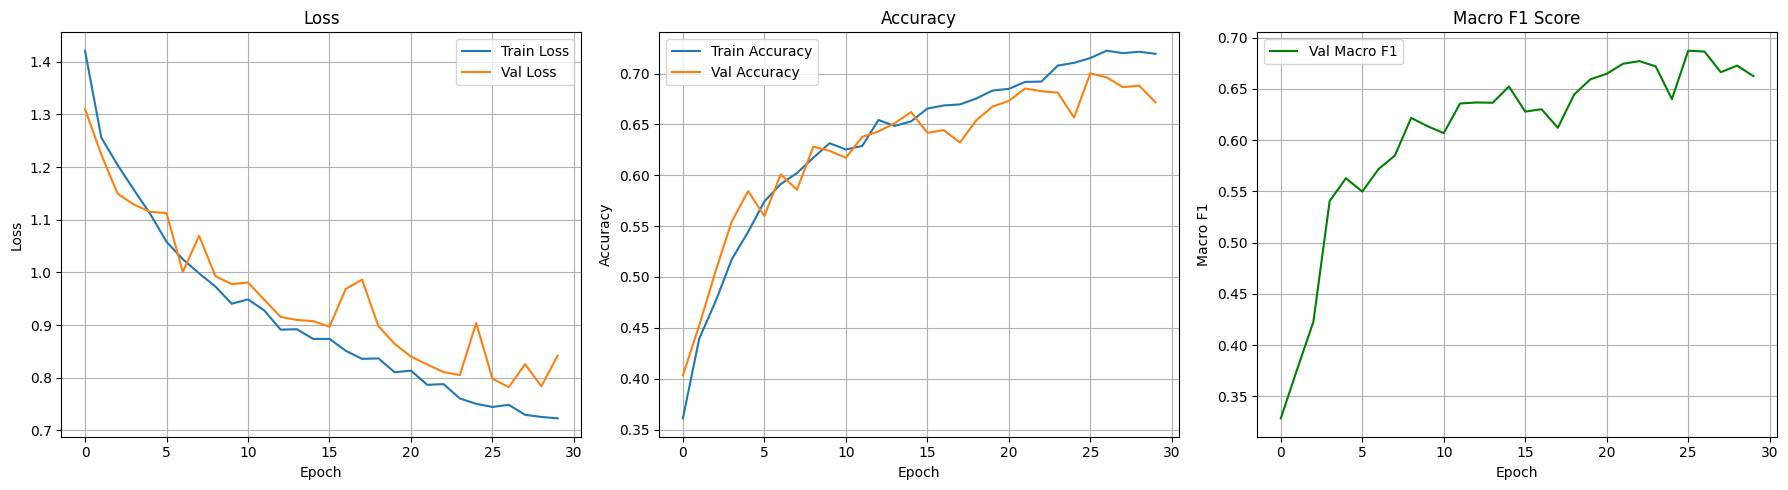

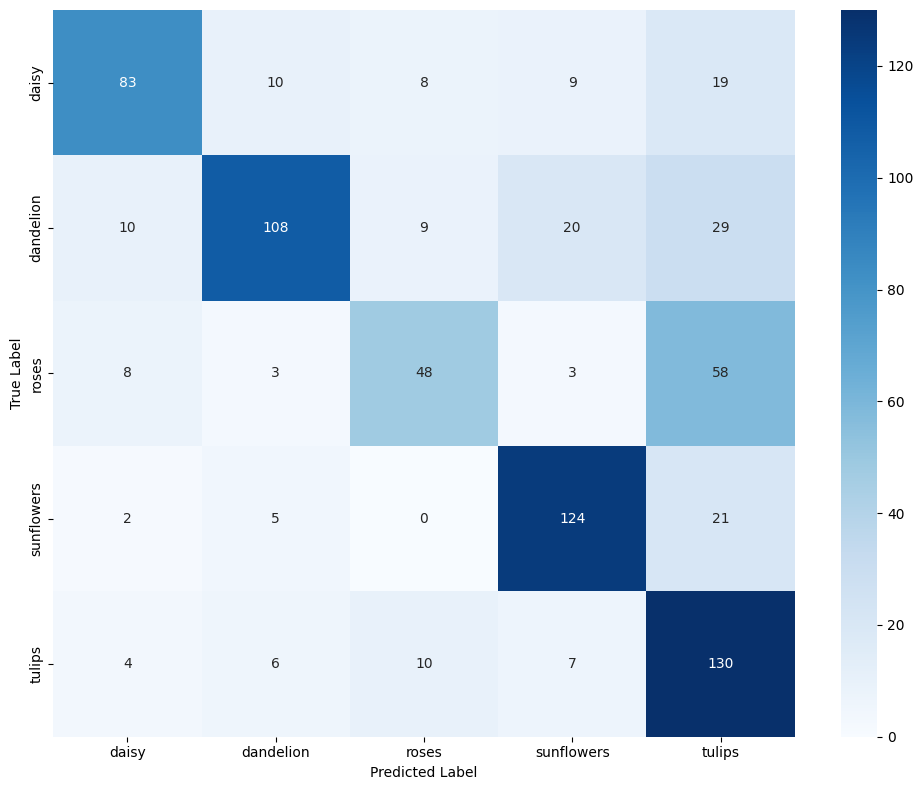


Results: Macro F1 = 0.6625, Time = 763.32s


EXPERIMENT 5/7
Config: {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 64, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': 'l1', 'reg_value': 0.001}
Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 4.1407 - accuracy: 0.5109 — val_macro_f1: 0.0841
 — epoch_time: 31.85s (avg: 31.85s)
92/92 [==============================] - 32s 305ms/step - loss: 4.1407 - accuracy: 0.5109 - val_loss: 4.3252 - val_accuracy: 0.2425 - val_macro_f1: 0.0841
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 3.5645 - accuracy: 0.5794 — val_macro_f1: 0.1134
 — epoch_time: 27.89s (avg: 29.87s)
92/92 [==============================] - 28s 303ms/step - loss: 3.5645 - accuracy: 0.5794 - val_loss: 3.9288 - val_accuracy: 0.2507 - val_macro_f1: 0.1134
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 3.0424 - accuracy: 0.6131 — val_macro_f1: 0.1029
 — epoch_t

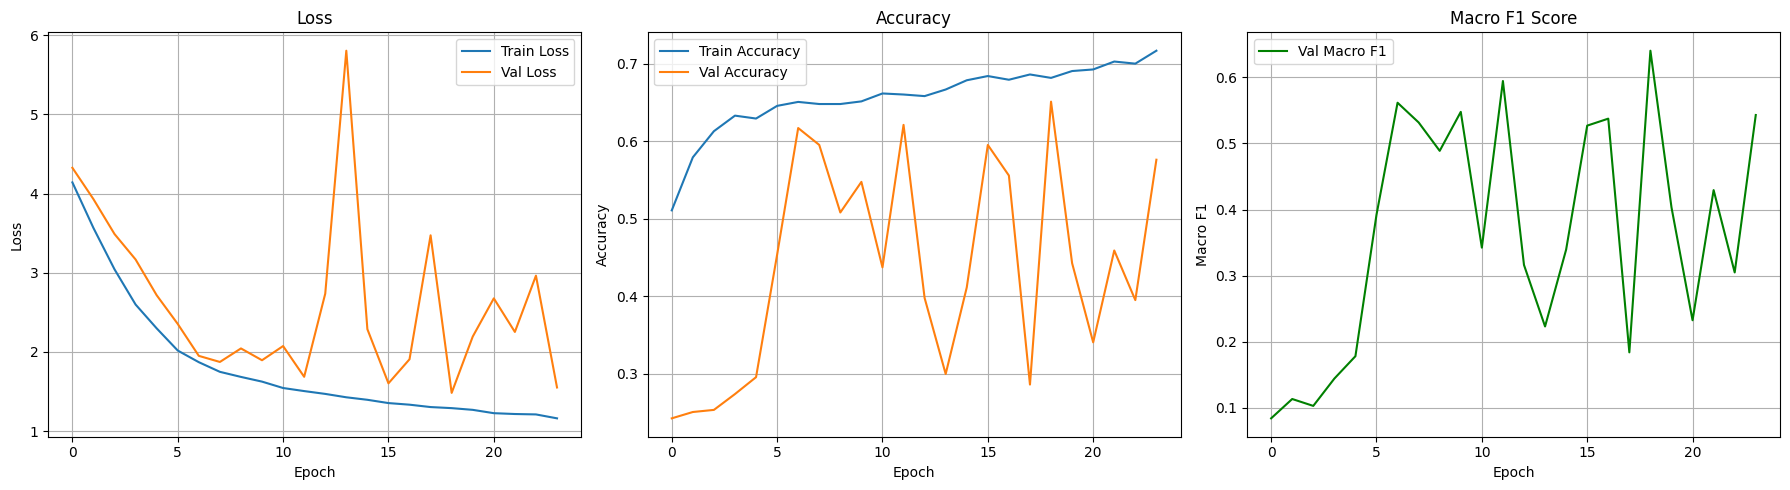

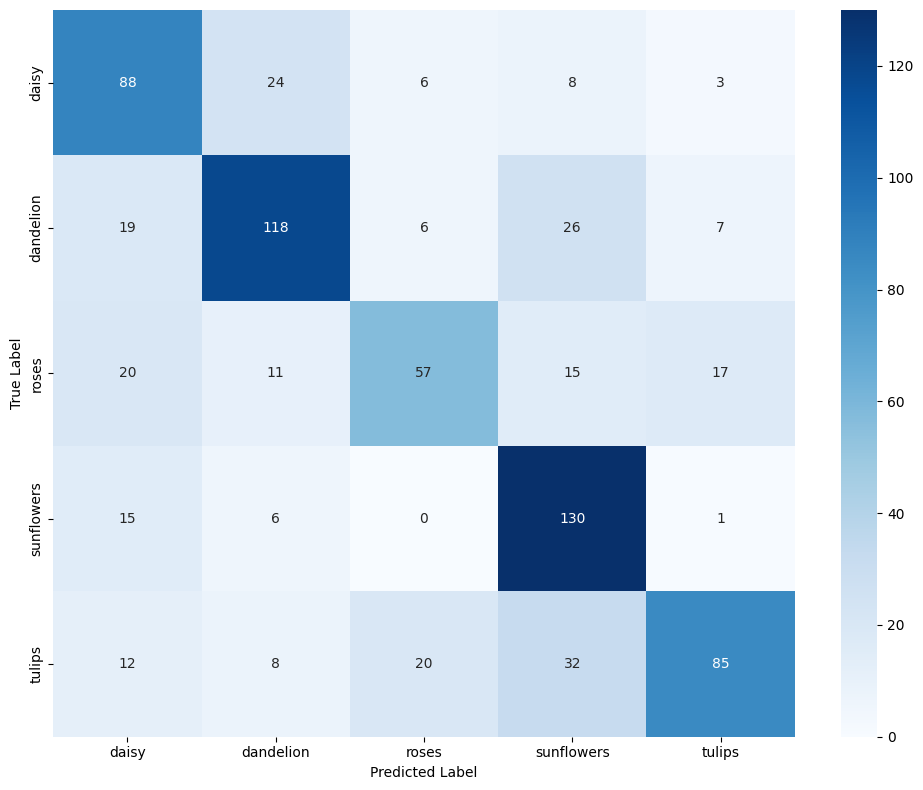


Results: Macro F1 = 0.6403, Time = 675.52s


EXPERIMENT 6/7
Config: {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 64, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': 'l2', 'reg_value': 0.001}
Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 1.4343 - accuracy: 0.4918 — val_macro_f1: 0.0841
 — epoch_time: 31.74s (avg: 31.74s)
92/92 [==============================] - 32s 310ms/step - loss: 1.4343 - accuracy: 0.4918 - val_loss: 1.8403 - val_accuracy: 0.2425 - val_macro_f1: 0.0841
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 1.2609 - accuracy: 0.5787 — val_macro_f1: 0.0937
 — epoch_time: 28.15s (avg: 29.95s)
92/92 [==============================] - 28s 306ms/step - loss: 1.2609 - accuracy: 0.5787 - val_loss: 1.8801 - val_accuracy: 0.2466 - val_macro_f1: 0.0937
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 1.1850 - accuracy: 0.6097 — val_macro_f1: 0.1016
 — epoch_t

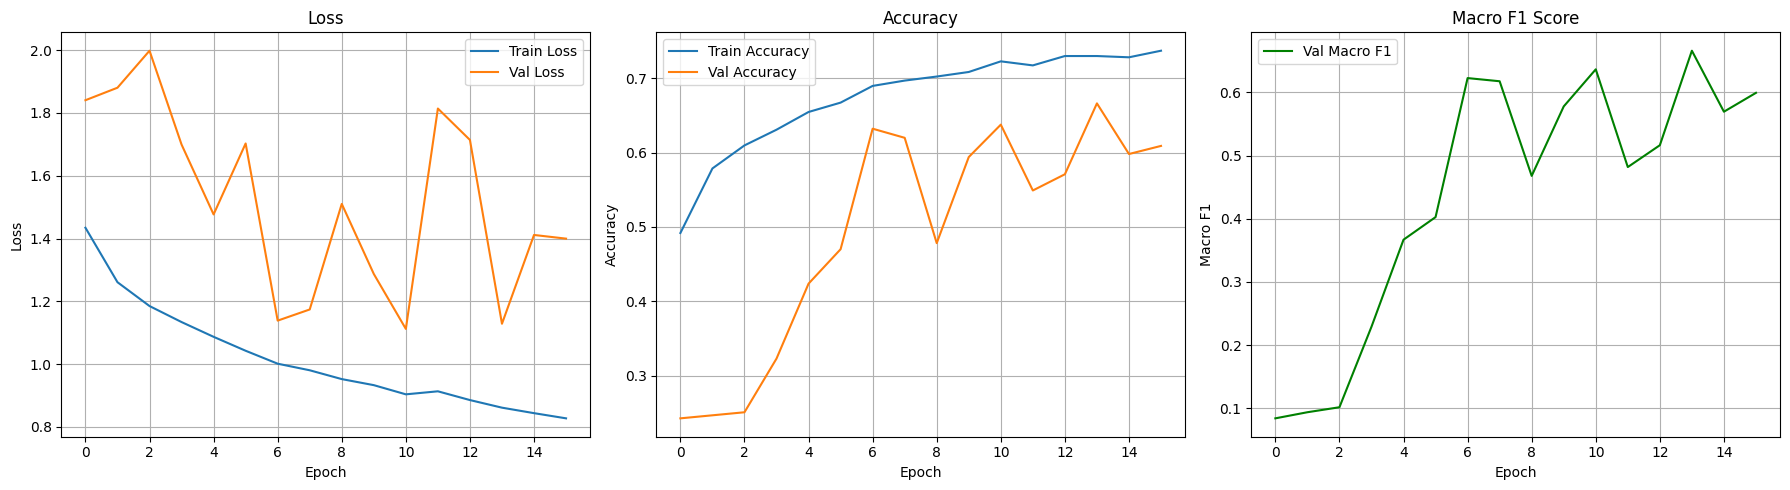

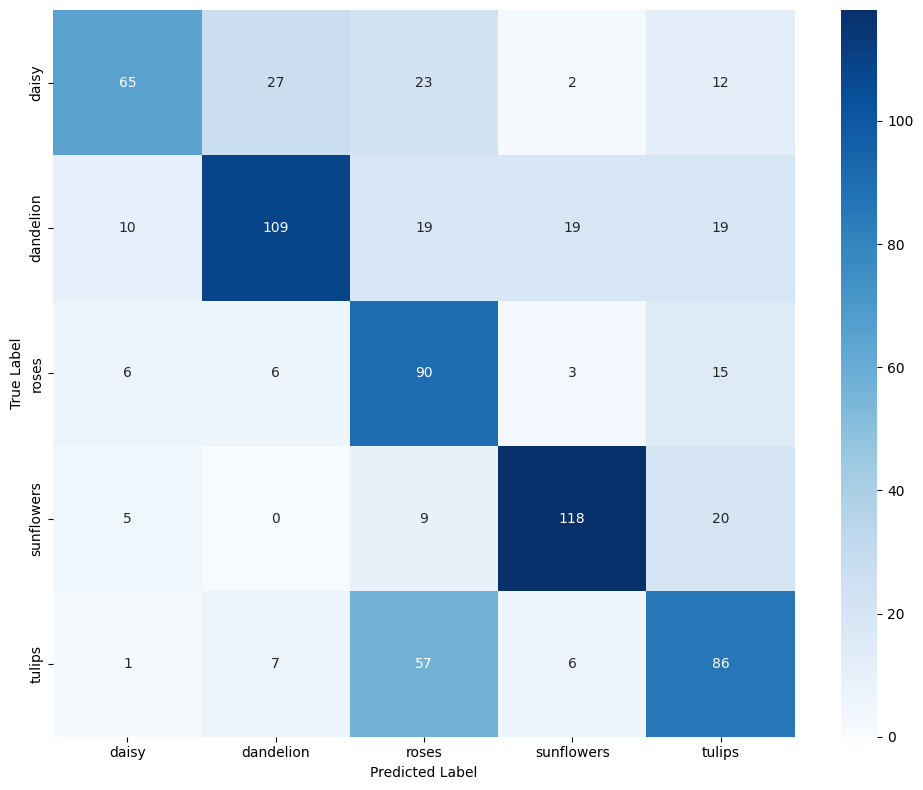


Results: Macro F1 = 0.6364, Time = 455.67s


EXPERIMENT 7/7
Config: {'conv_layers': 3, 'dense_layers': 1, 'dense_units': 256, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}
Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 1.2162 - accuracy: 0.5160 — val_macro_f1: 0.0774
 — epoch_time: 34.60s (avg: 34.60s)
92/92 [==============================] - 35s 335ms/step - loss: 1.2162 - accuracy: 0.5160 - val_loss: 1.6403 - val_accuracy: 0.2398 - val_macro_f1: 0.0774
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 1.0085 - accuracy: 0.6012 — val_macro_f1: 0.1027
 — epoch_time: 30.41s (avg: 32.50s)
92/92 [==============================] - 30s 331ms/step - loss: 1.0085 - accuracy: 0.6012 - val_loss: 1.6746 - val_accuracy: 0.2534 - val_macro_f1: 0.1027
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 0.9250 - accuracy: 0.6505 — val_macro_f1: 0.2920
 — epoch_time

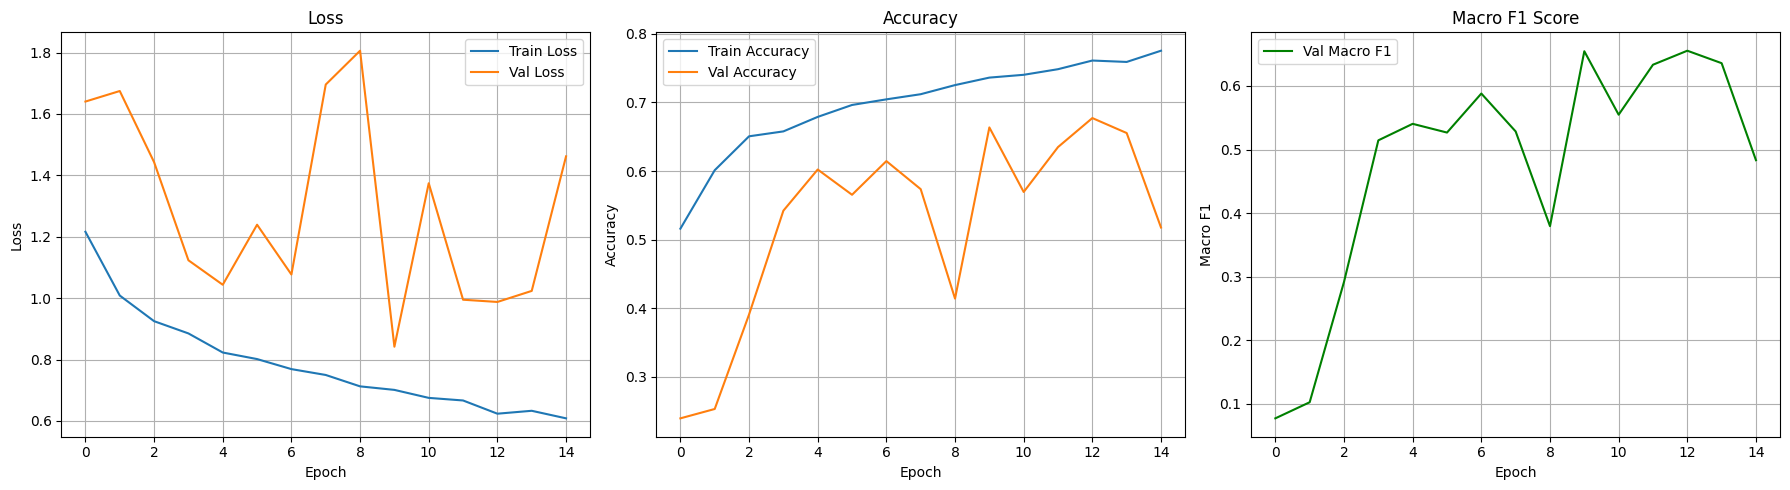

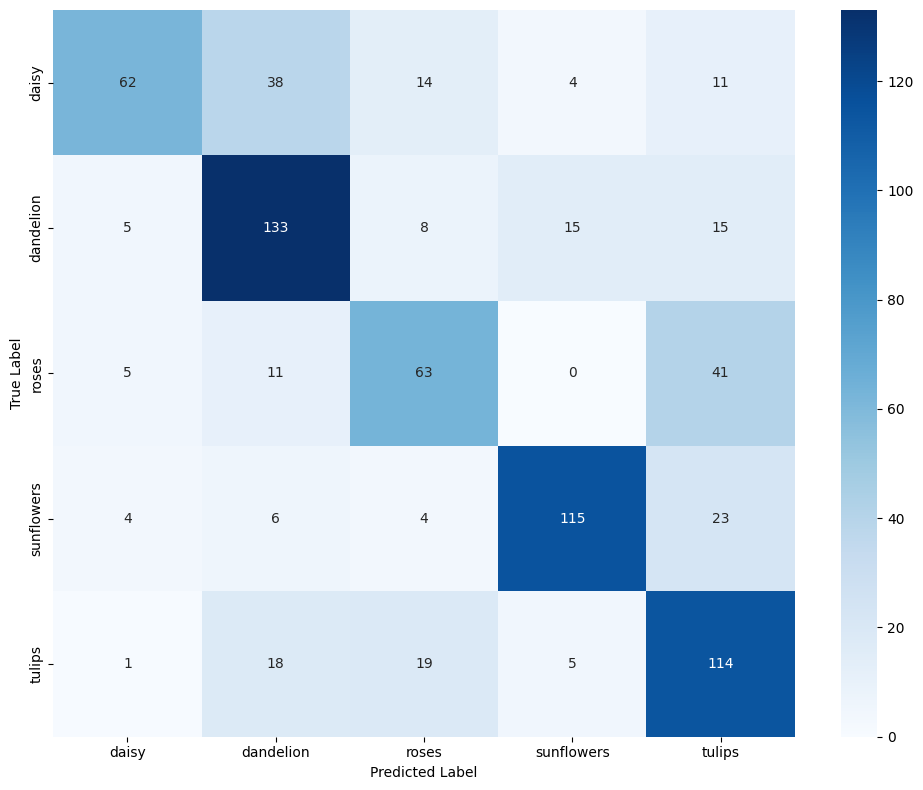


Results: Macro F1 = 0.6546, Time = 460.26s


In [ ]:
epochs = 30
for idx, config in enumerate(grid_search_configs):
    print(f"\n\nEXPERIMENT {idx + 1}/{len(grid_search_configs)}")
    print(f"Config: {config}")
    experiment_name = f"exp_{idx+1}"

    model = build_model(**config)
    f1_callback = MacroF1(val_ds)
    early_stopping = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=5, restore_best_weights=True )
    epoch_timer = EpochTimer()

    start_time = time.time()
    with tf.device('/GPU:0'):
        history = model.fit( train_ds, validation_data=val_ds, epochs=epochs, callbacks=[f1_callback, early_stopping, epoch_timer], verbose=1 )
        training_time = time.time() - start_time
        y_true, y_pred, final_f1 = evaluate_model(model, val_ds)

        result = {
            "experiment": idx + 1,
            "config": config,
            "final_macro_f1": final_f1,
            "training_time_seconds": training_time,
            "epochs_trained": len(history.history['loss']),
            "final_val_loss": history.history['val_loss'][-1],
            "final_val_accuracy": history.history['val_accuracy'][-1]
        }
        results.append(result)

        plot_training_history(history, f1_callback)
        plot_confusion_matrix(y_true, y_pred, class_names)

        if final_f1 > best_f1:
            best_f1 = final_f1
            best_model = model
            best_config = config
            best_history = history
            best_f1_callback = f1_callback
        print(f"\nResults: Macro F1 = {final_f1:.4f}, Time = {training_time:.2f}s")


In [15]:
results_df = pd.DataFrame(results)

print(results_df.to_string(index=False))

print(f"Best Macro F1: {best_f1:.4f}")
print(f"Config: {best_config}")

 experiment                                                                                                                                                                                      config  final_macro_f1  training_time_seconds  epochs_trained  final_val_loss  final_val_accuracy
          1    {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 64, 'activation': 'relu', 'learning_rate': 0.0001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}        0.598895             336.433989              12        0.956011            0.630790
          2     {'conv_layers': 4, 'dense_layers': 1, 'dense_units': 64, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}        0.651002             476.722899              15        1.388190            0.658038
          3    {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 64, 'activation': 'relu', 'learning_rate': 0.001, 'use_pool

This was the first result(I am not sure what I did but I can't get the same result again)

experiment                                                                                                                                                                                         config  final_macro_f1  training_time_seconds  epochs_trained  final_val_loss  final_val_accuracy


          1       {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}        0.614181             447.187886              10        1.115101            0.614441


          2      {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.0005, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}        0.658899             539.338370              13        1.061883            0.638965


          3      {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.0003, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}        0.643616             570.375563              14        1.106836            0.580381


          4      {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.0001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}        0.611759             484.312988              12        1.106908            0.576294

          
          5       {'conv_layers': 3, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}        0.745658             807.301239              19        1.255159            0.603542


          6       {'conv_layers': 4, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}        0.688127             667.268480              15        1.146019            0.588556


          7       {'conv_layers': 2, 'dense_layers': 2, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}        0.694681             959.804522              24        0.952443            0.655313


          8      {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': False, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}        0.669293            1091.634559              22        2.269153            0.452316


          9      {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': False, 'regularizer': None, 'reg_value': 0}        0.687900            1110.213070              30        0.762244            0.693460


         10   {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': 'l1', 'reg_value': 0.001}        0.611668             554.902385              14        4.823173            0.279292

         
         11   {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': 'l1', 'reg_value': 1e-05}        0.651909             478.521714              12        1.009472            0.633515

         
         12  {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': 'l1', 'reg_value': 0.0005}        0.632620             753.283516              19        2.437052            0.494550


         13   {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': 'l2', 'reg_value': 0.001}        0.657674             555.194419              14        1.339278            0.611717


         14   {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': 'l2', 'reg_value': 1e-05}        0.636508             516.938329              13        1.620976            0.486376


         15  {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': 'l2', 'reg_value': 0.0005}        0.593010             437.311409              11        1.261519            0.607629


         16        {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 64, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}        0.641929             594.955075              15        1.113271            0.641689


         17       {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 256, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}        0.689494             595.194941              15        1.209118            0.573569


         18    {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'sigmoid', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}        0.560925             831.254303              21        1.403624            0.444142


         19       {'conv_layers': 2, 'dense_layers': 1, 'dense_units': 128, 'activation': 'tanh', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}        0.490594             435.538504              11        1.266627            0.546322

Best Macro F1: 0.7457
Config: {'conv_layers': 3, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}

In [ ]:
grid_search_configs = [
    #New Baseline
    # {"conv_layers": 3, "dense_layers": 1, "dense_units": 128, "activation": "relu",
    #  "learning_rate": 0.001, "use_pooling": True, "use_batchnorm": True, 
    #  "regularizer": None, "reg_value": 0},

     #Learning rate
     {"conv_layers": 3, "dense_layers": 1, "dense_units": 128, "activation": "relu",
     "learning_rate": 0.0003, "use_pooling": True, "use_batchnorm": True, 
     "regularizer": None, "reg_value": 0},

     {"conv_layers": 3, "dense_layers": 1, "dense_units": 128, "activation": "relu",
     "learning_rate": 0.0005, "use_pooling": True, "use_batchnorm": True, 
     "regularizer": None, "reg_value": 0},
     
     #Hidden layers
     {"conv_layers": 3, "dense_layers": 2, "dense_units": 128, "activation": "relu",
     "learning_rate": 0.001, "use_pooling": True, "use_batchnorm": True, 
     "regularizer": None, "reg_value": 0},

     #Pooling 

    #   {"conv_layers": 3, "dense_layers": 1, "dense_units": 128, "activation": "relu",
    #  "learning_rate": 0.001, "use_pooling": False, "use_batchnorm": True, 
    #  "regularizer": None, "reg_value": 0}, - gives error

     #Batch Norm
      {"conv_layers": 3, "dense_layers": 1, "dense_units": 128, "activation": "relu",
     "learning_rate": 0.001, "use_pooling": True, "use_batchnorm": False, 
     "regularizer": None, "reg_value": 0},
     
     # L1
      {"conv_layers": 3, "dense_layers": 1, "dense_units": 128, "activation": "relu",
     "learning_rate": 0.001, "use_pooling": True, "use_batchnorm": True, 
     "regularizer": 'l1', "reg_value": 0.0001},

     #L2 
      {"conv_layers": 3, "dense_layers": 1, "dense_units": 128, "activation": "relu",
     "learning_rate": 0.001, "use_pooling": True, "use_batchnorm": True, 
     "regularizer": 'l2', "reg_value": 0.001},

     #Neuronen 
      {"conv_layers": 3, "dense_layers": 1, "dense_units": 256, "activation": "relu",
     "learning_rate": 0.001, "use_pooling": True, "use_batchnorm": True, 
     "regularizer": None, "reg_value": 0},
]

results = []
best_f1 = 0
best_model = None
best_config = None
best_history = None
best_f1_callback = None



EXPERIMENT 1/7
Config: {'conv_layers': 3, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.0003, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}
Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 1.1740 - accuracy: 0.5456 — val_macro_f1: 0.0774
 — epoch_time: 34.26s (avg: 34.26s)
92/92 [==============================] - 34s 332ms/step - loss: 1.1740 - accuracy: 0.5456 - val_loss: 1.7125 - val_accuracy: 0.2398 - val_macro_f1: 0.0774
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 0.9715 - accuracy: 0.6253 — val_macro_f1: 0.0808
 — epoch_time: 30.13s (avg: 32.20s)
92/92 [==============================] - 30s 328ms/step - loss: 0.9715 - accuracy: 0.6253 - val_loss: 1.8721 - val_accuracy: 0.2411 - val_macro_f1: 0.0808
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 0.8950 - accuracy: 0.6618 — val_macro_f1: 0.1721
 — epoch_time: 30.01s (avg: 31.47s)
92/92 [=============

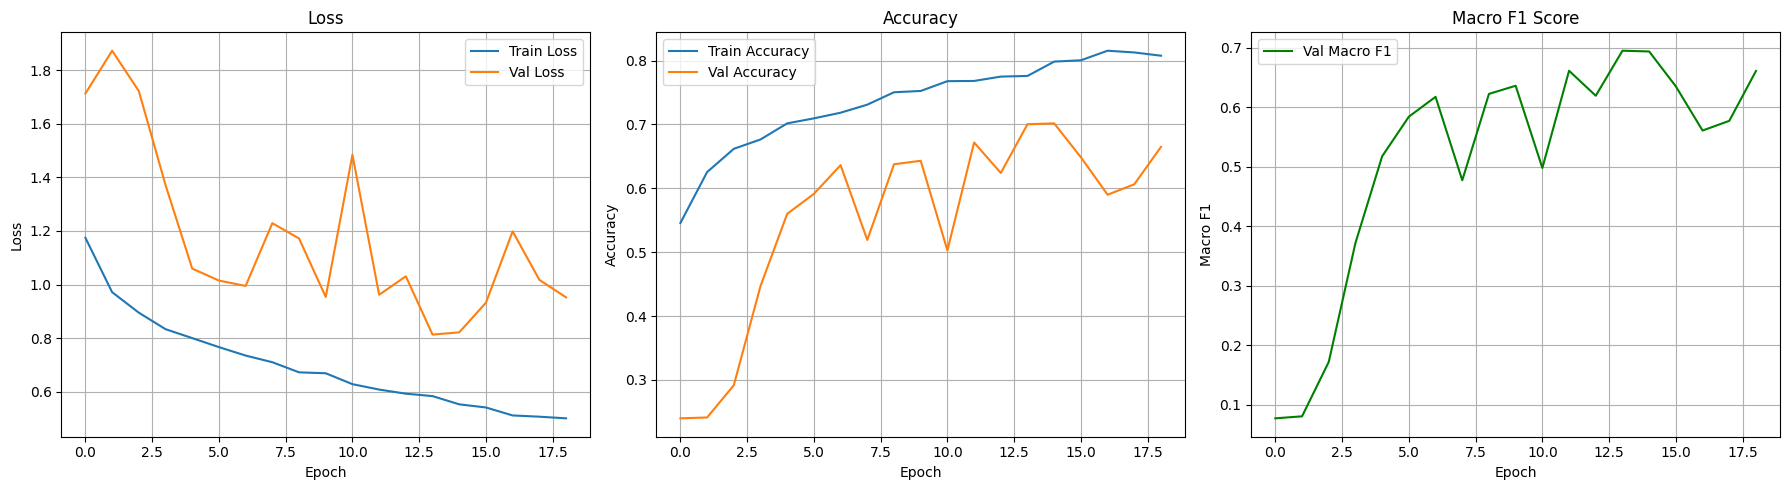

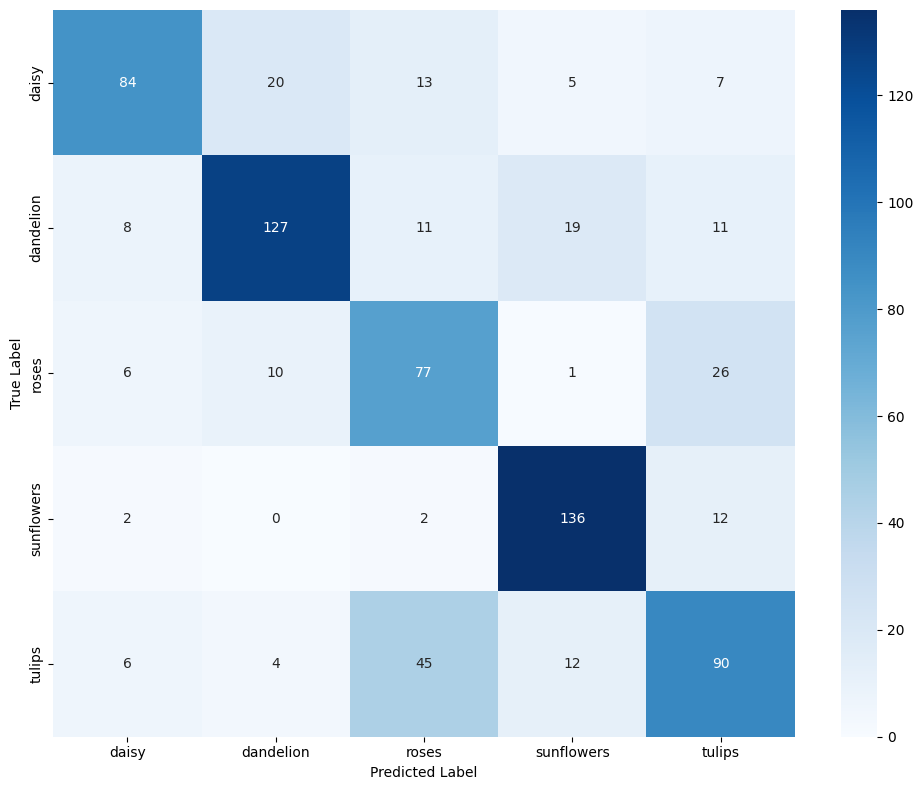


Results: Macro F1 = 0.6948, Time = 578.69s


EXPERIMENT 2/7
Config: {'conv_layers': 3, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.0005, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}
Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 1.1706 - accuracy: 0.5293 — val_macro_f1: 0.1441
 — epoch_time: 33.85s (avg: 33.85s)
92/92 [==============================] - 34s 331ms/step - loss: 1.1706 - accuracy: 0.5293 - val_loss: 1.6536 - val_accuracy: 0.2534 - val_macro_f1: 0.1441
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 0.9586 - accuracy: 0.6291 — val_macro_f1: 0.0774
 — epoch_time: 30.04s (avg: 31.94s)
92/92 [==============================] - 30s 327ms/step - loss: 0.9586 - accuracy: 0.6291 - val_loss: 1.9730 - val_accuracy: 0.2398 - val_macro_f1: 0.0774
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 0.8961 - accuracy: 0.6468 — val_macro_f1: 0.0801
 — epoch_tim

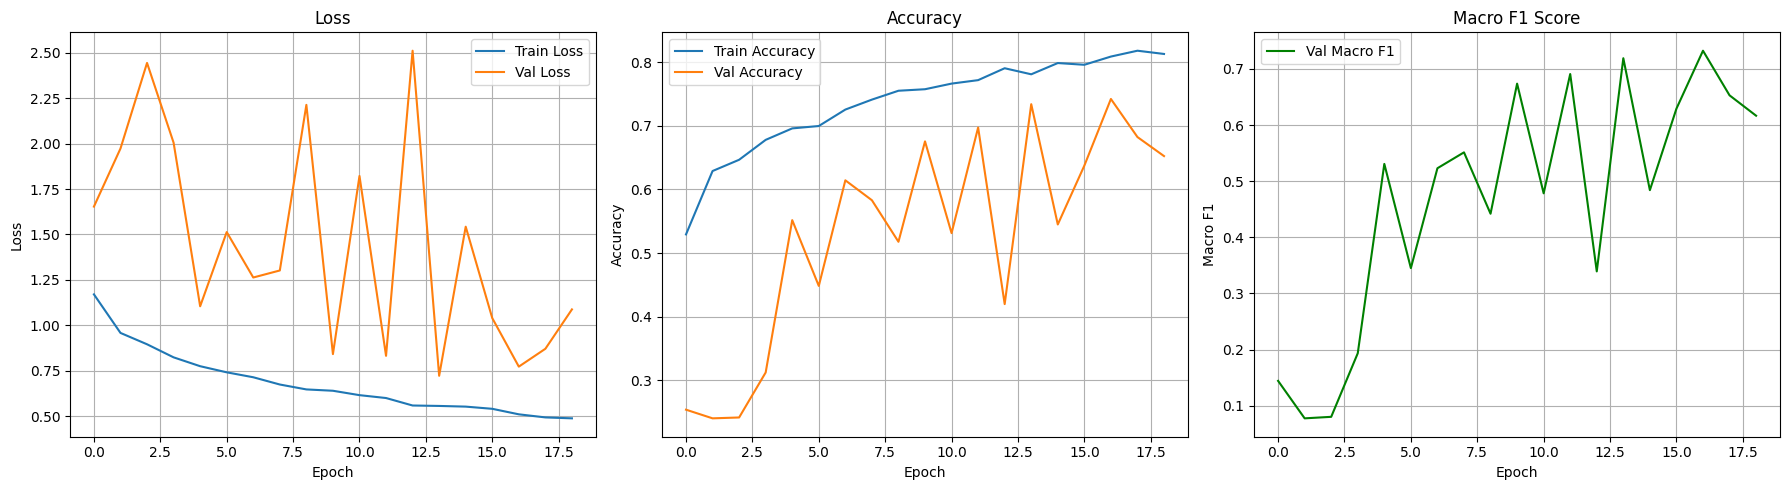

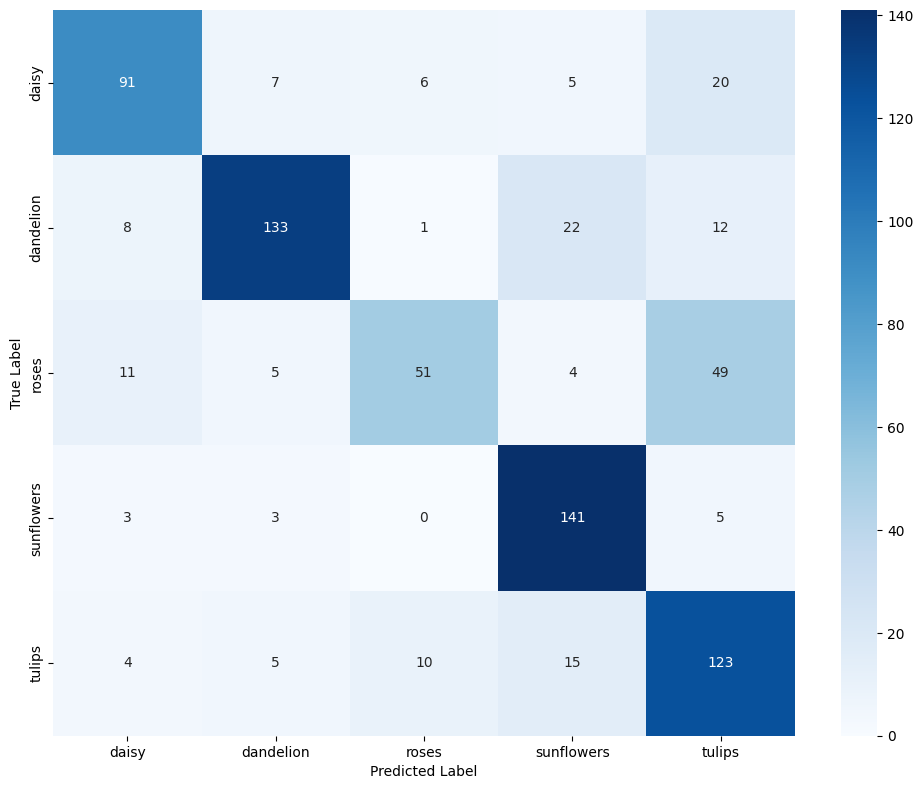


Results: Macro F1 = 0.7190, Time = 576.07s


EXPERIMENT 3/7
Config: {'conv_layers': 3, 'dense_layers': 2, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}
Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 1.2514 - accuracy: 0.5037 — val_macro_f1: 0.0774
 — epoch_time: 34.39s (avg: 34.39s)
92/92 [==============================] - 34s 333ms/step - loss: 1.2514 - accuracy: 0.5037 - val_loss: 1.7006 - val_accuracy: 0.2398 - val_macro_f1: 0.0774
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 1.0572 - accuracy: 0.5831 — val_macro_f1: 0.0905
 — epoch_time: 30.34s (avg: 32.37s)
92/92 [==============================] - 30s 330ms/step - loss: 1.0572 - accuracy: 0.5831 - val_loss: 1.8121 - val_accuracy: 0.2466 - val_macro_f1: 0.0905
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 0.9614 - accuracy: 0.6233 — val_macro_f1: 0.2508
 — epoch_time

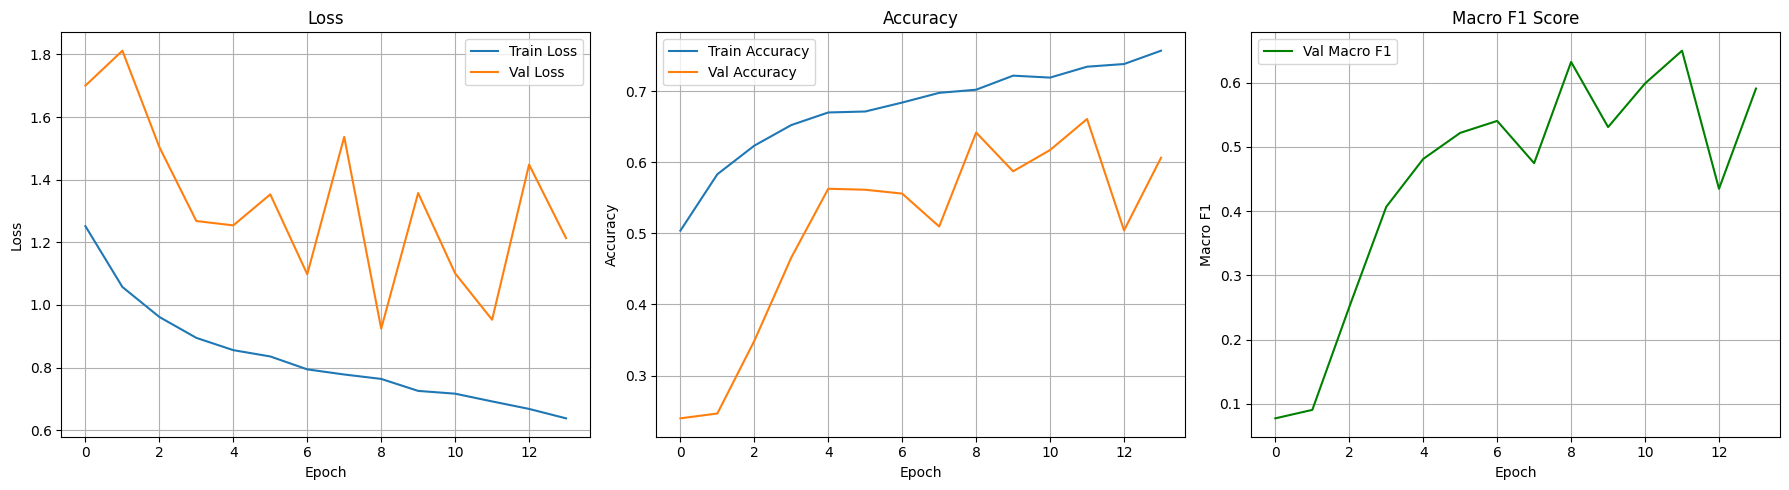

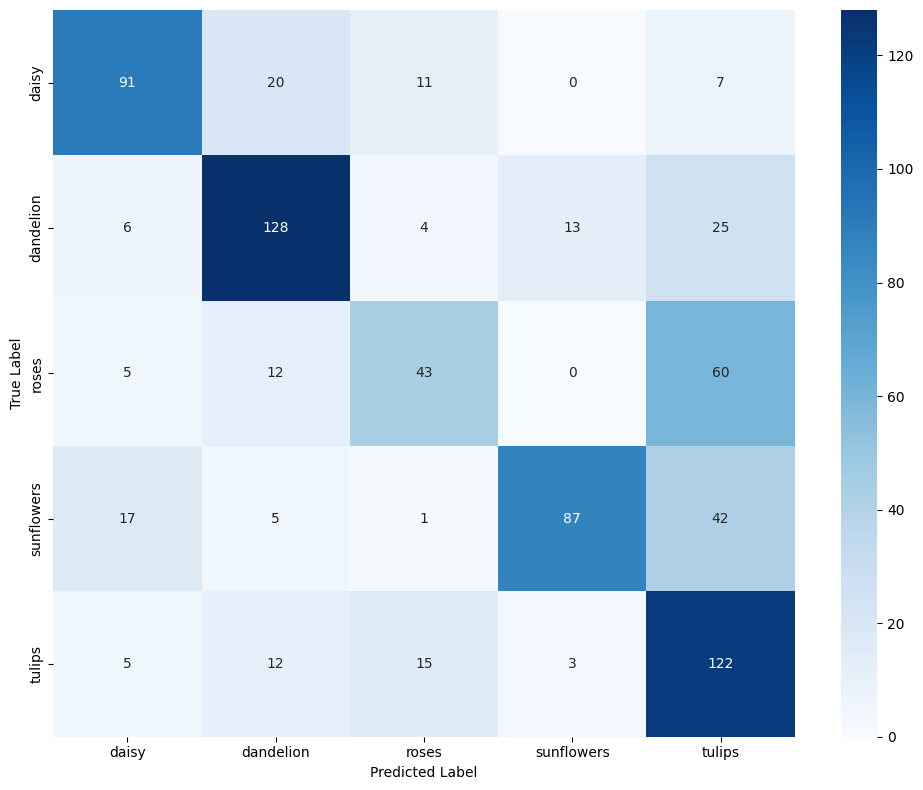



EXPERIMENT 4/7
Config: {'conv_layers': 3, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': False, 'regularizer': None, 'reg_value': 0}
Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 1.4282 - accuracy: 0.3546 — val_macro_f1: 0.3281
 — epoch_time: 32.80s (avg: 32.80s)
92/92 [==============================] - 33s 313ms/step - loss: 1.4282 - accuracy: 0.3546 - val_loss: 1.3385 - val_accuracy: 0.4346 - val_macro_f1: 0.3281
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 1.2591 - accuracy: 0.4401 — val_macro_f1: 0.3705
 — epoch_time: 26.68s (avg: 29.74s)
92/92 [==============================] - 27s 290ms/step - loss: 1.2591 - accuracy: 0.4401 - val_loss: 1.2158 - val_accuracy: 0.4591 - val_macro_f1: 0.3705
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 1.1736 - accuracy: 0.4888 — val_macro_f1: 0.5129
 — epoch_time: 26.37s (avg: 28.62s)
92/92 [=============

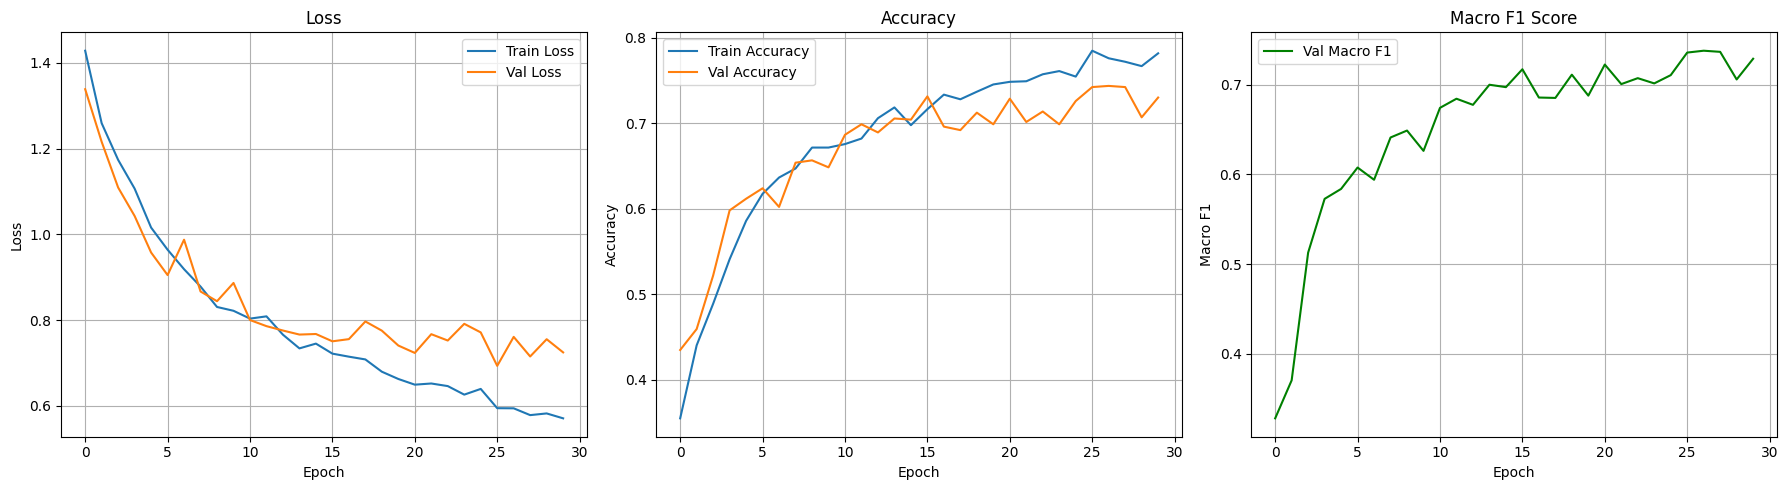

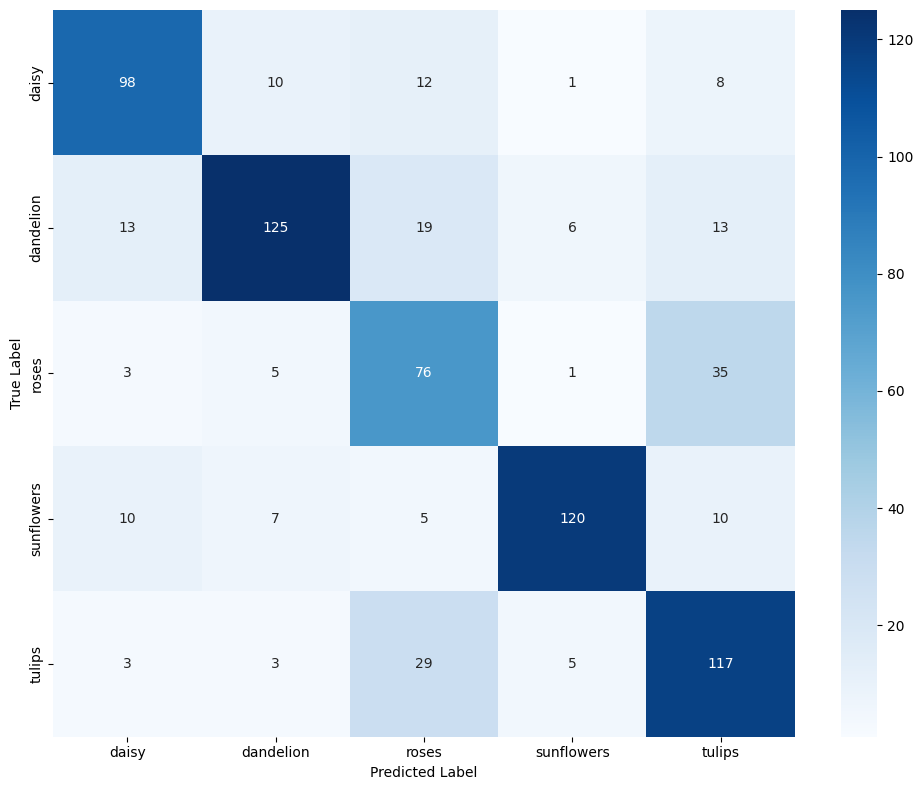


Results: Macro F1 = 0.7290, Time = 795.74s


EXPERIMENT 5/7
Config: {'conv_layers': 3, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': 'l1', 'reg_value': 0.0001}
Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 2.1490 - accuracy: 0.5324 — val_macro_f1: 0.0774
 — epoch_time: 34.10s (avg: 34.10s)
92/92 [==============================] - 34s 328ms/step - loss: 2.1490 - accuracy: 0.5324 - val_loss: 2.6252 - val_accuracy: 0.2398 - val_macro_f1: 0.0774
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 1.9506 - accuracy: 0.6080 — val_macro_f1: 0.0801
 — epoch_time: 29.86s (avg: 31.98s)
92/92 [==============================] - 30s 325ms/step - loss: 1.9506 - accuracy: 0.6080 - val_loss: 2.6523 - val_accuracy: 0.2411 - val_macro_f1: 0.0801
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 1.8304 - accuracy: 0.6322 — val_macro_f1: 0.2650
 — epoch

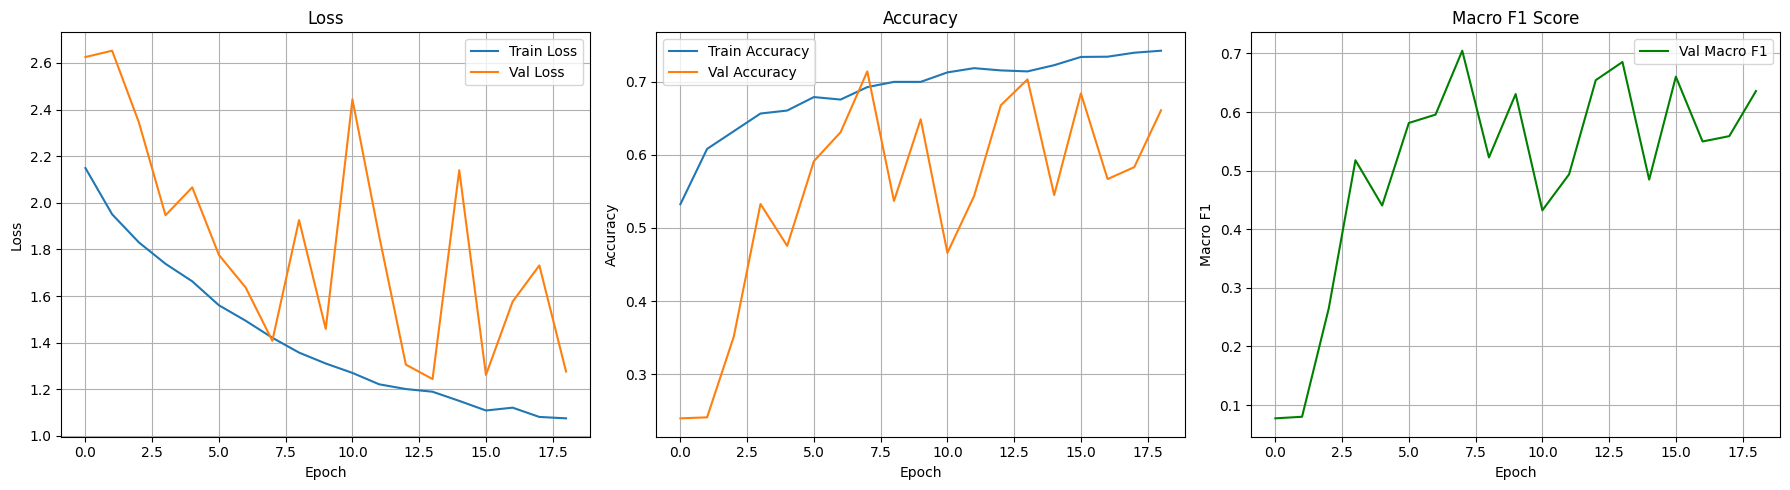

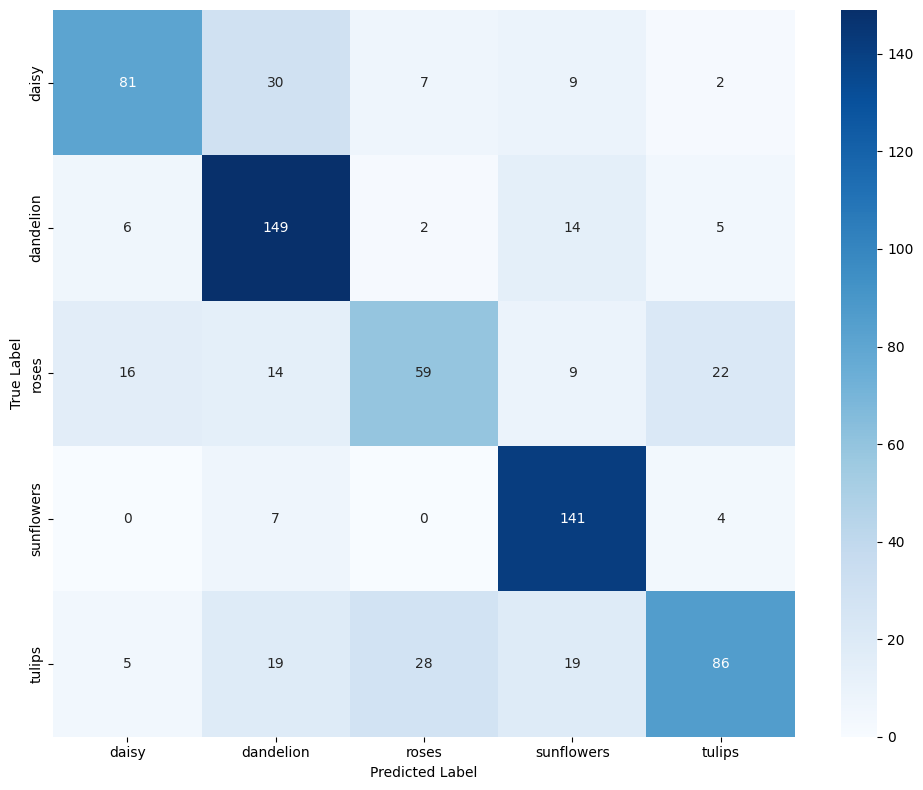



EXPERIMENT 6/7
Config: {'conv_layers': 3, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': 'l2', 'reg_value': 0.001}
Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 1.6452 - accuracy: 0.5337 — val_macro_f1: 0.0774
 — epoch_time: 33.79s (avg: 33.79s)
92/92 [==============================] - 34s 330ms/step - loss: 1.6452 - accuracy: 0.5337 - val_loss: 2.1390 - val_accuracy: 0.2398 - val_macro_f1: 0.0774
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 1.4633 - accuracy: 0.6158 — val_macro_f1: 0.0774
 — epoch_time: 29.11s (avg: 31.45s)
92/92 [==============================] - 29s 317ms/step - loss: 1.4633 - accuracy: 0.6158 - val_loss: 2.4701 - val_accuracy: 0.2398 - val_macro_f1: 0.0774
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 1.3785 - accuracy: 0.6410 — val_macro_f1: 0.0968
 — epoch_time: 29.21s (avg: 30.70s)
92/92 [==========

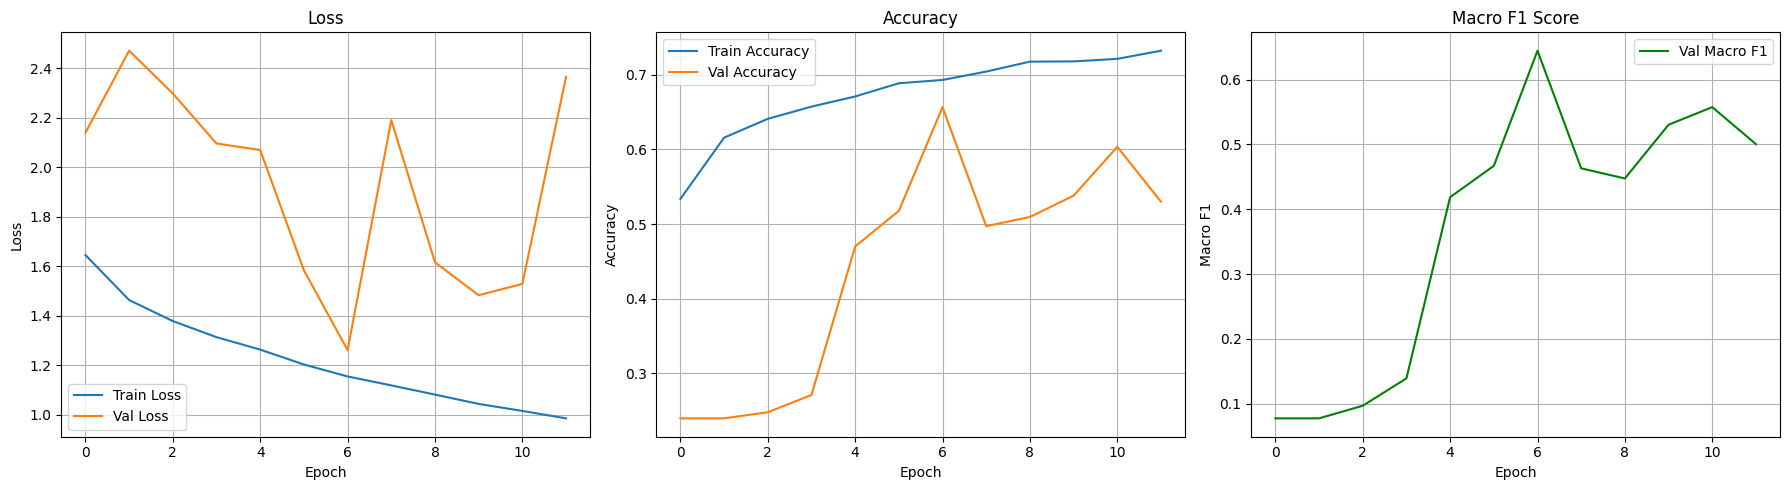

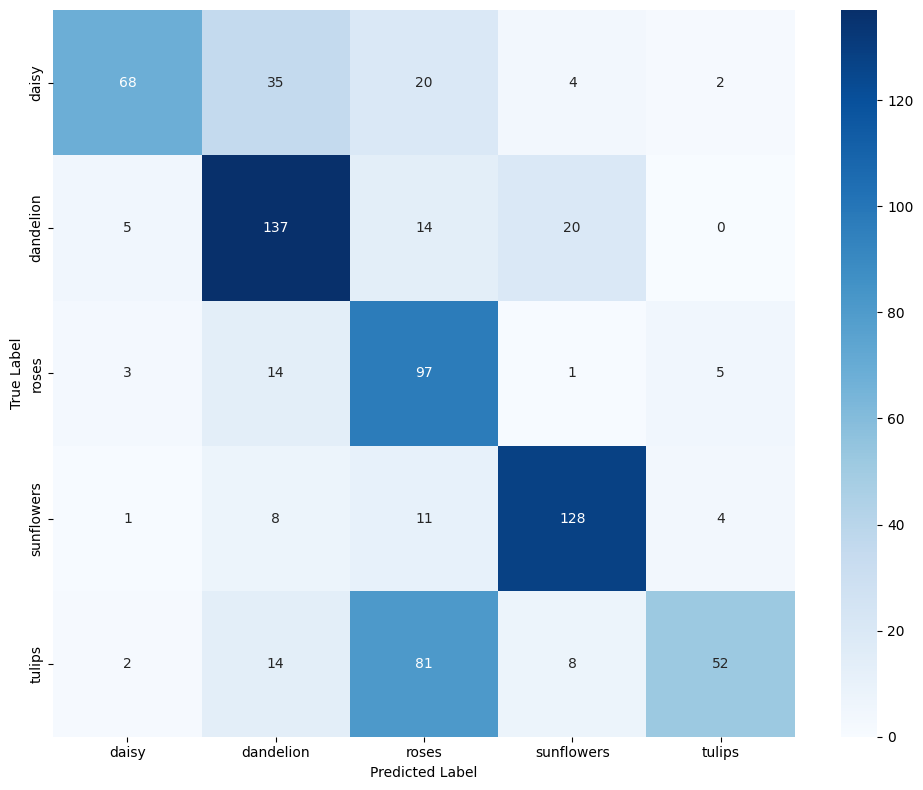



EXPERIMENT 7/7
Config: {'conv_layers': 3, 'dense_layers': 1, 'dense_units': 256, 'activation': 'relu', 'learning_rate': 0.001, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}
Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 1.1838 - accuracy: 0.5337 — val_macro_f1: 0.0774
 — epoch_time: 32.91s (avg: 32.91s)
92/92 [==============================] - 33s 321ms/step - loss: 1.1838 - accuracy: 0.5337 - val_loss: 1.6750 - val_accuracy: 0.2398 - val_macro_f1: 0.0774
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 1.0112 - accuracy: 0.5978 — val_macro_f1: 0.0775
 — epoch_time: 29.22s (avg: 31.06s)
92/92 [==============================] - 29s 318ms/step - loss: 1.0112 - accuracy: 0.5978 - val_loss: 1.8374 - val_accuracy: 0.2371 - val_macro_f1: 0.0775
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 0.9272 - accuracy: 0.6304 — val_macro_f1: 0.2865
 — epoch_time: 29.09s (avg: 30.41s)
92/92 [==============

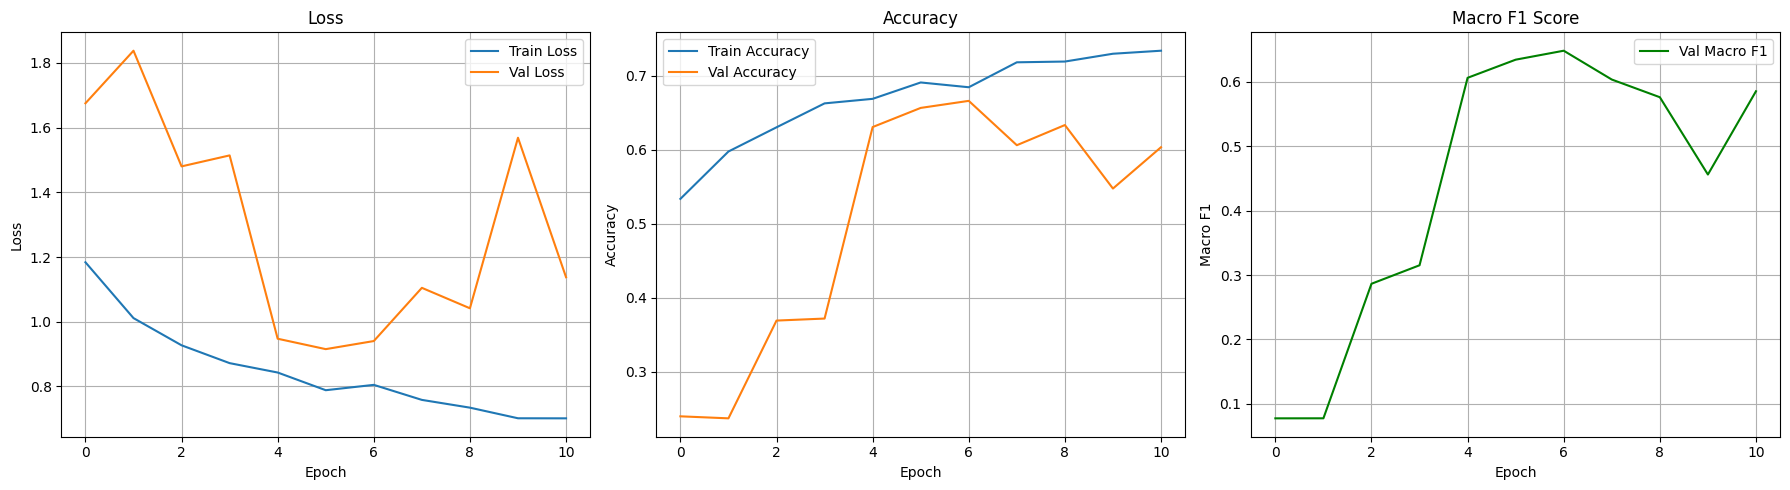

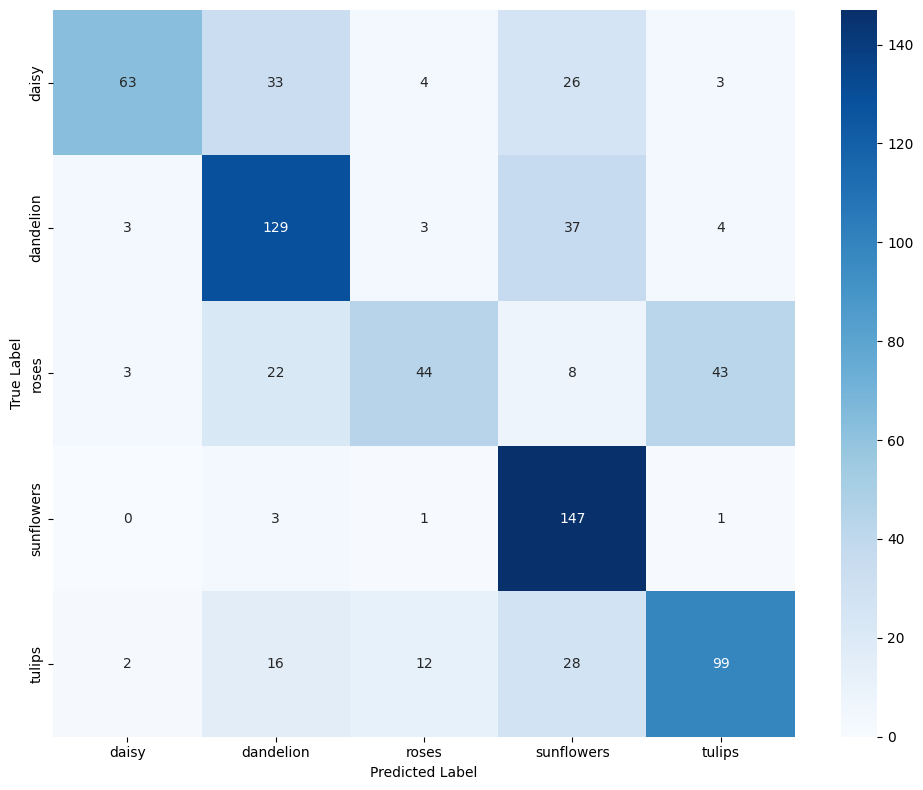

In [ ]:
epochs = 30
for idx, config in enumerate(grid_search_configs):
    print(f"\n\nEXPERIMENT {idx + 1}/{len(grid_search_configs)}")
    print(f"Config: {config}")
    experiment_name = f"exp_{idx+1}"

    model = build_model(**config)
    f1_callback = MacroF1(val_ds)
    early_stopping = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=5, restore_best_weights=True )
    epoch_timer = EpochTimer()

    start_time = time.time()
    with tf.device('/GPU:0'):
        history = model.fit( train_ds, validation_data=val_ds, epochs=epochs, callbacks=[f1_callback, early_stopping, epoch_timer], verbose=1 )
        training_time = time.time() - start_time
        y_true, y_pred, final_f1 = evaluate_model(model, val_ds)

        result = {
            "experiment": idx + 1,
            "config": config,
            "final_macro_f1": final_f1,
            "training_time_seconds": training_time,
            "epochs_trained": len(history.history['loss']),
            "final_val_loss": history.history['val_loss'][-1],
            "final_val_accuracy": history.history['val_accuracy'][-1]
        }
        results.append(result)

        plot_training_history(history, f1_callback)
        plot_confusion_matrix(y_true, y_pred, class_names)

        if final_f1 > best_f1:
            best_f1 = final_f1
            best_model = model
            best_config = config
            best_history = history
            best_f1_callback = f1_callback
        print(f"\nResults: Macro F1 = {final_f1:.4f}, Time = {training_time:.2f}s")


In [12]:
results_df = pd.DataFrame(results)

print(results_df.to_string(index=False))

print(f"Best Macro F1: {best_f1:.4f}")
print(f"Config: {best_config}")

 experiment                                                                                                                                                                                        config  final_macro_f1  training_time_seconds  epochs_trained  final_val_loss  final_val_accuracy
          1     {'conv_layers': 3, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.0003, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}        0.694842             578.689162              19        0.952273            0.664850
          2     {'conv_layers': 3, 'dense_layers': 1, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.0005, 'use_pooling': True, 'use_batchnorm': True, 'regularizer': None, 'reg_value': 0}        0.718978             576.072569              19        1.087927            0.652589
          3      {'conv_layers': 3, 'dense_layers': 2, 'dense_units': 128, 'activation': 'relu', 'learning_rate': 0.001, 